## Importamos librerías

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import shap
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import random
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt import fmin, tpe, STATUS_OK, Trials
from datetime import timedelta

np.random.seed(42)
random.seed(42)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Obtenemos datos y los persistimos en la carpeta ./data/

In [2]:
start = "2001-01-02"
end = "2023-06-02"

In [3]:
cotizacion = yf.download('ELE.MC', start=start, end=end)
cotizacion.to_csv('./data/cotizacion.csv')

cotizacion.head()

[*********************100%%**********************]  1 of 1 completed


Open       High        Low  Close  Adj Close    Volume
Date                                                                   
2001-01-02  18.150000  18.770000  17.700001  18.68   2.334867   3900039
2001-01-03  18.379999  20.070000  18.379999  19.90   2.487359  10223480
2001-01-04  20.000000  20.100000  18.900000  19.00   2.374865   7637974
2001-01-05  19.180000  19.180000  18.330000  18.68   2.334867   6998680
2001-01-08  18.719999  19.049999  18.500000  18.82   2.352366   4031715

## Comprobamos qué días existen descuadres entre el cierre del día anterior y la apertura del día corriente. 
Estos descuadres pueden deberse a Información después del cierre del mercado, Operaciones fuera del horario de mercado (after-hours trading), ordenes acumuladas, operaciones internacionales... Y en cualquier caso queremos una lista con los descuadres superiores al 2% para tratar de encontrar algún patrón.

In [4]:
cotizacion['Diff_Percent'] = ((cotizacion['Open'] - cotizacion['Close'].shift(1)) / cotizacion['Close'].shift(1)) * 100
dias_superiores_2_pc = cotizacion[cotizacion['Diff_Percent'].abs() > 2]

lista_dias_superiores_2_pc = dias_superiores_2_pc.index.strftime('%Y-%m-%d').tolist()
print(lista_dias_superiores_2_pc)

['2001-02-06', '2001-05-02', '2001-09-12', '2001-10-17', '2002-06-26', '2002-07-01', '2002-07-11', '2002-07-24', '2002-07-25', '2002-08-06', '2002-08-08', '2002-08-14', '2002-08-16', '2002-09-17', '2002-09-26', '2002-09-30', '2002-10-02', '2002-10-11', '2002-11-04', '2003-01-07', '2003-01-30', '2003-01-31', '2003-02-26', '2003-03-17', '2003-03-31', '2003-06-03', '2004-03-15', '2005-07-01', '2005-09-06', '2006-02-21', '2006-07-03', '2006-07-28', '2006-09-26', '2006-09-27', '2007-02-05', '2007-03-26', '2007-07-02', '2007-10-03', '2007-10-08', '2008-01-22', '2008-01-24', '2008-03-17', '2008-03-18', '2008-03-25', '2008-07-08', '2008-07-23', '2008-09-15', '2008-09-30', '2008-10-06', '2008-10-08', '2008-10-10', '2008-10-13', '2008-10-14', '2008-10-16', '2008-10-17', '2008-10-21', '2008-10-24', '2008-10-27', '2008-10-29', '2008-11-04', '2008-11-06', '2008-11-10', '2008-11-11', '2008-11-12', '2008-11-14', '2008-12-03', '2008-12-04', '2008-12-08', '2008-12-12', '2009-02-23', '2009-03-02', '2009

## Contamos 'descuadres' en cada año

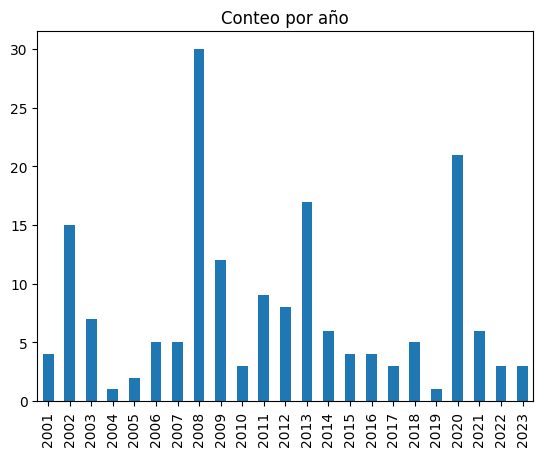

In [5]:
dates_series = pd.Series(pd.to_datetime(lista_dias_superiores_2_pc))

year_counts = dates_series.dt.year.value_counts().sort_index()
year_counts.plot(kind='bar', title='Conteo por año')

plt.show()

## Contamos 'descuadres' por weekday

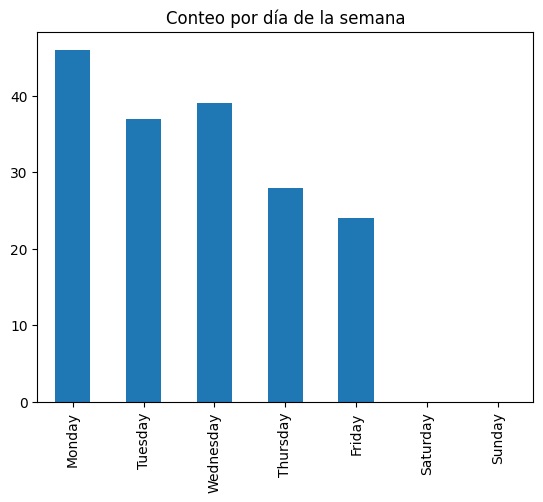

In [6]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = dates_series.dt.day_name().value_counts().reindex(weekday_order).fillna(0)

weekday_counts.plot(kind='bar', title='Conteo por día de la semana')
plt.show()

## Contamos 'descuadres' por mes

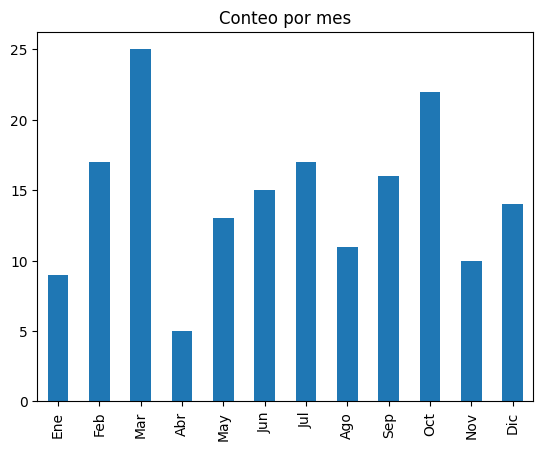

In [7]:
month_counts = dates_series.dt.month.value_counts().sort_index()
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
month_counts.index = month_names
month_counts.plot(kind='bar', title='Conteo por mes')
plt.show()

In [8]:
cotizacion.nlargest(5, 'Diff_Percent')

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2005-09-06  21.250000  21.270000  20.299999  20.549999   2.932246   57627240   
2006-02-21  27.500000  27.940001  27.400000  27.549999   3.985776   51632444   
2006-09-26  31.709999  33.099998  31.650000  32.500000   4.931657  211188464   
2006-09-27  35.009998  35.250000  34.549999  35.000000   5.311016   35571756   
2020-05-05  21.000000  21.000000  20.240000  20.240000  15.341814    1102381   

            Diff_Percent  
Date                      
2005-09-06     11.314824  
2006-02-21      7.927788  
2006-09-26      7.857141  
2006-09-27      7.723072  
2020-05-05      7.416884

### Si observamos uno a uno los descuadres más importantes, encontramos un patrón de noticias que respaldan cada fecha, si bien pueden no ser fácilmente predecibles:
Interesante, entre otros: https://www.elmundo.es/mundodinero/2007/01/31/economia/1170245949.html

## 2005-09-06
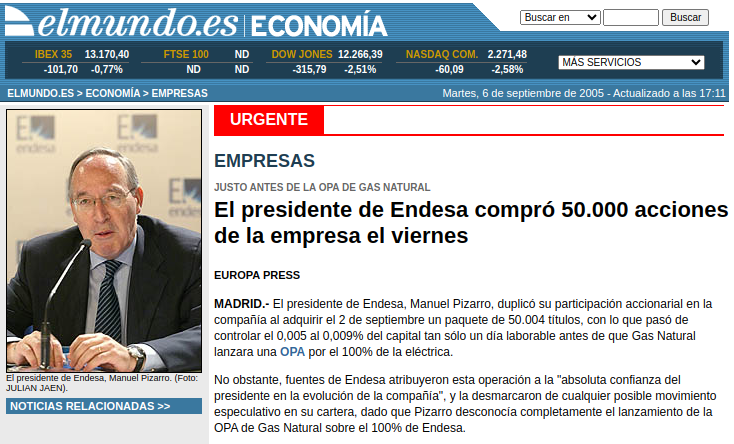

## 2006-02-21
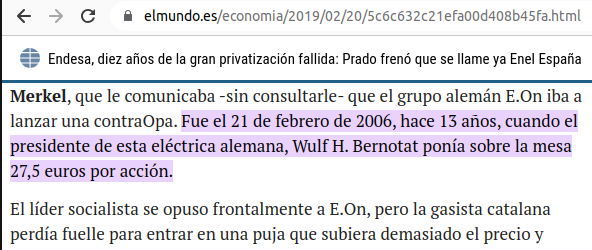

## 2006-09-26 y 2006-09-27
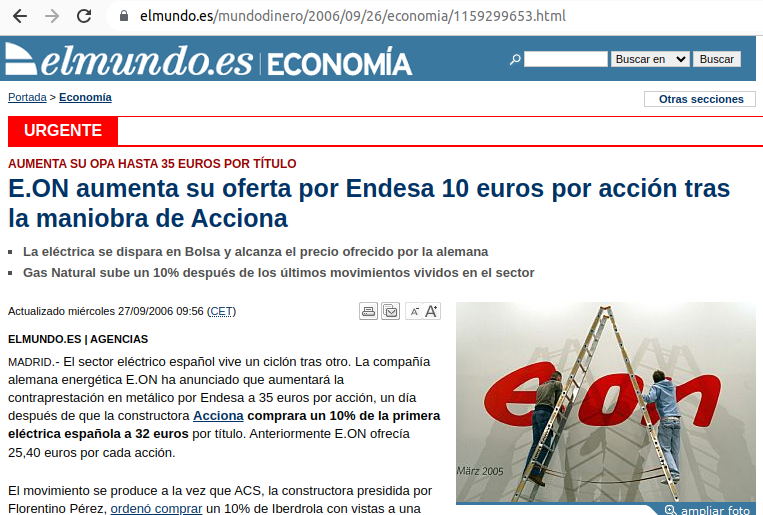

## 2020-05-05
https://www.endesa.com/content/dam/enel-es/home/inversores/informe2020/ia-2020.pdf <br>
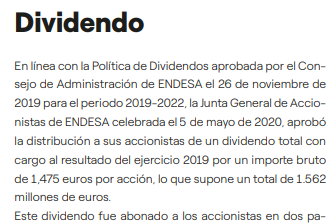

In [9]:
cotizacion.nsmallest(5, 'Diff_Percent')

Open    High        Low      Close  Adj Close    Volume  \
Date                                                                       
2014-10-29  15.800000  16.000  14.890000  15.130000   8.196055   9657735   
2009-03-16  14.040000  15.050  14.020000  14.700000   3.387701   3415061   
2016-06-24  14.965000  16.465  14.690000  16.165001   9.367686   3388533   
2008-10-10  18.209999  20.740  18.010000  18.629999   3.055947   1896132   
2006-07-03  25.209999  25.400  25.110001  25.260000   3.833035  14952236   

            Diff_Percent  
Date                      
2014-10-29    -45.704467  
2009-03-16    -31.378296  
2016-06-24    -15.116274  
2008-10-10     -9.267567  
2006-07-03     -7.282094

Eventos como la devolución de cantidades mal cobradas:<br>
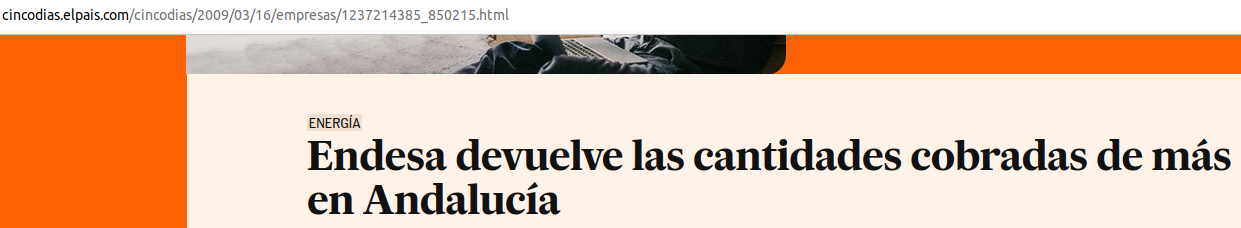
<br>afectan de forma negativa, como en el segundo caso.

## Otro efecto interesante es el de los dividendos, que podemos comprobar gráficamente mediante un formato de 'velas', que tiene en cuenta todos los valores del dataframe y nos ayuda a detectar grandes cambios en los valores de un día a otro. Por ejemplo, en este caso estamos observando el reparto del que se consideraba el 'dividendo más grande de la historia de España'.
https://cincodias.elpais.com/cincodias/2014/10/08/mercados/1412788567_849485.html

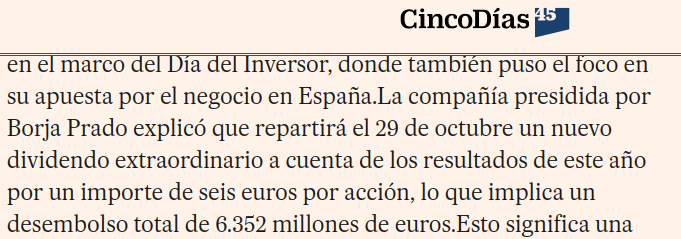

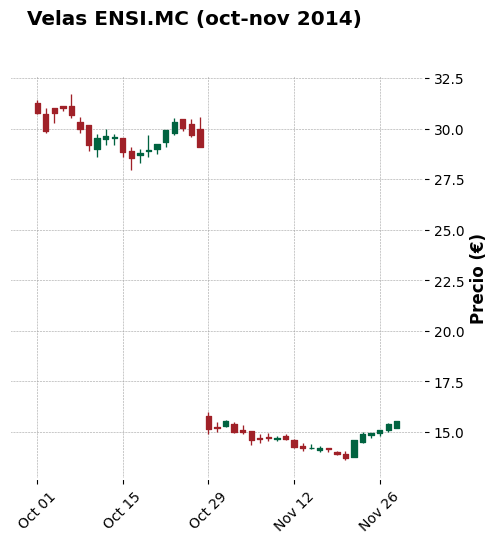

In [10]:
mpf.plot(cotizacion[(cotizacion.index >= '2014-10-01') & (cotizacion.index <= '2014-11-30')], type='candle', style='charles', 
         title='Velas ENSI.MC (oct-nov 2014)', 
         ylabel='Precio (€)', 
         volume=False, 
         figratio=(10,10),
         warn_too_much_data=10000)

En cuanto el accionista pierde el derecho de recibir un dividendo (fecha ex-dividendo), la acción baja aproximadamente el mismo valor que el propio dividendo. Aun así, es interesante conocer el efecto de este reparto en cómo se comporta el precio del valor.

In [11]:
dividendos = yf.Ticker('ELE.MC').dividends.loc[start:end]
dividendos.head()

Date
2001-01-02 00:00:00+01:00    0.2400
2001-07-02 00:00:00+02:00    0.4100
2002-01-02 00:00:00+01:00    0.2640
2002-07-01 00:00:00+02:00    0.4185
2003-01-02 00:00:00+01:00    0.2640
Name: Dividends, dtype: float64

Comprobamos que existe, entre otros muchos, el correspondiente al 29 de octubre que observamos más arriba.

In [12]:
dividendos.loc['2014-10-28':'2014-10-30']

Date
2014-10-29 00:00:00+01:00    13.795
Name: Dividends, dtype: float64

Y que la diferencia entre el cierre del día 28 y la apertura del 29 coincide, aproximadamente, con el valor del dividendo.

In [13]:
cotizacion.loc['2014-10-28':'2014-10-30']

Open    High    Low  Close  Adj Close   Volume  Diff_Percent
Date                                                                         
2014-10-28  29.969999  30.580  29.10  29.10   8.290854  5616528      0.909086
2014-10-29  15.800000  16.000  14.89  15.13   8.196055  9657735    -45.704467
2014-10-30  15.250000  15.495  15.01  15.22   8.244809  2681242      0.793125

## Pero para nuestro cometido 'predictivo' tomaremos únicamente el valor 'Close' de cada sesión, al que superponemos en este gráfico los valores de los dividendos repartidos.

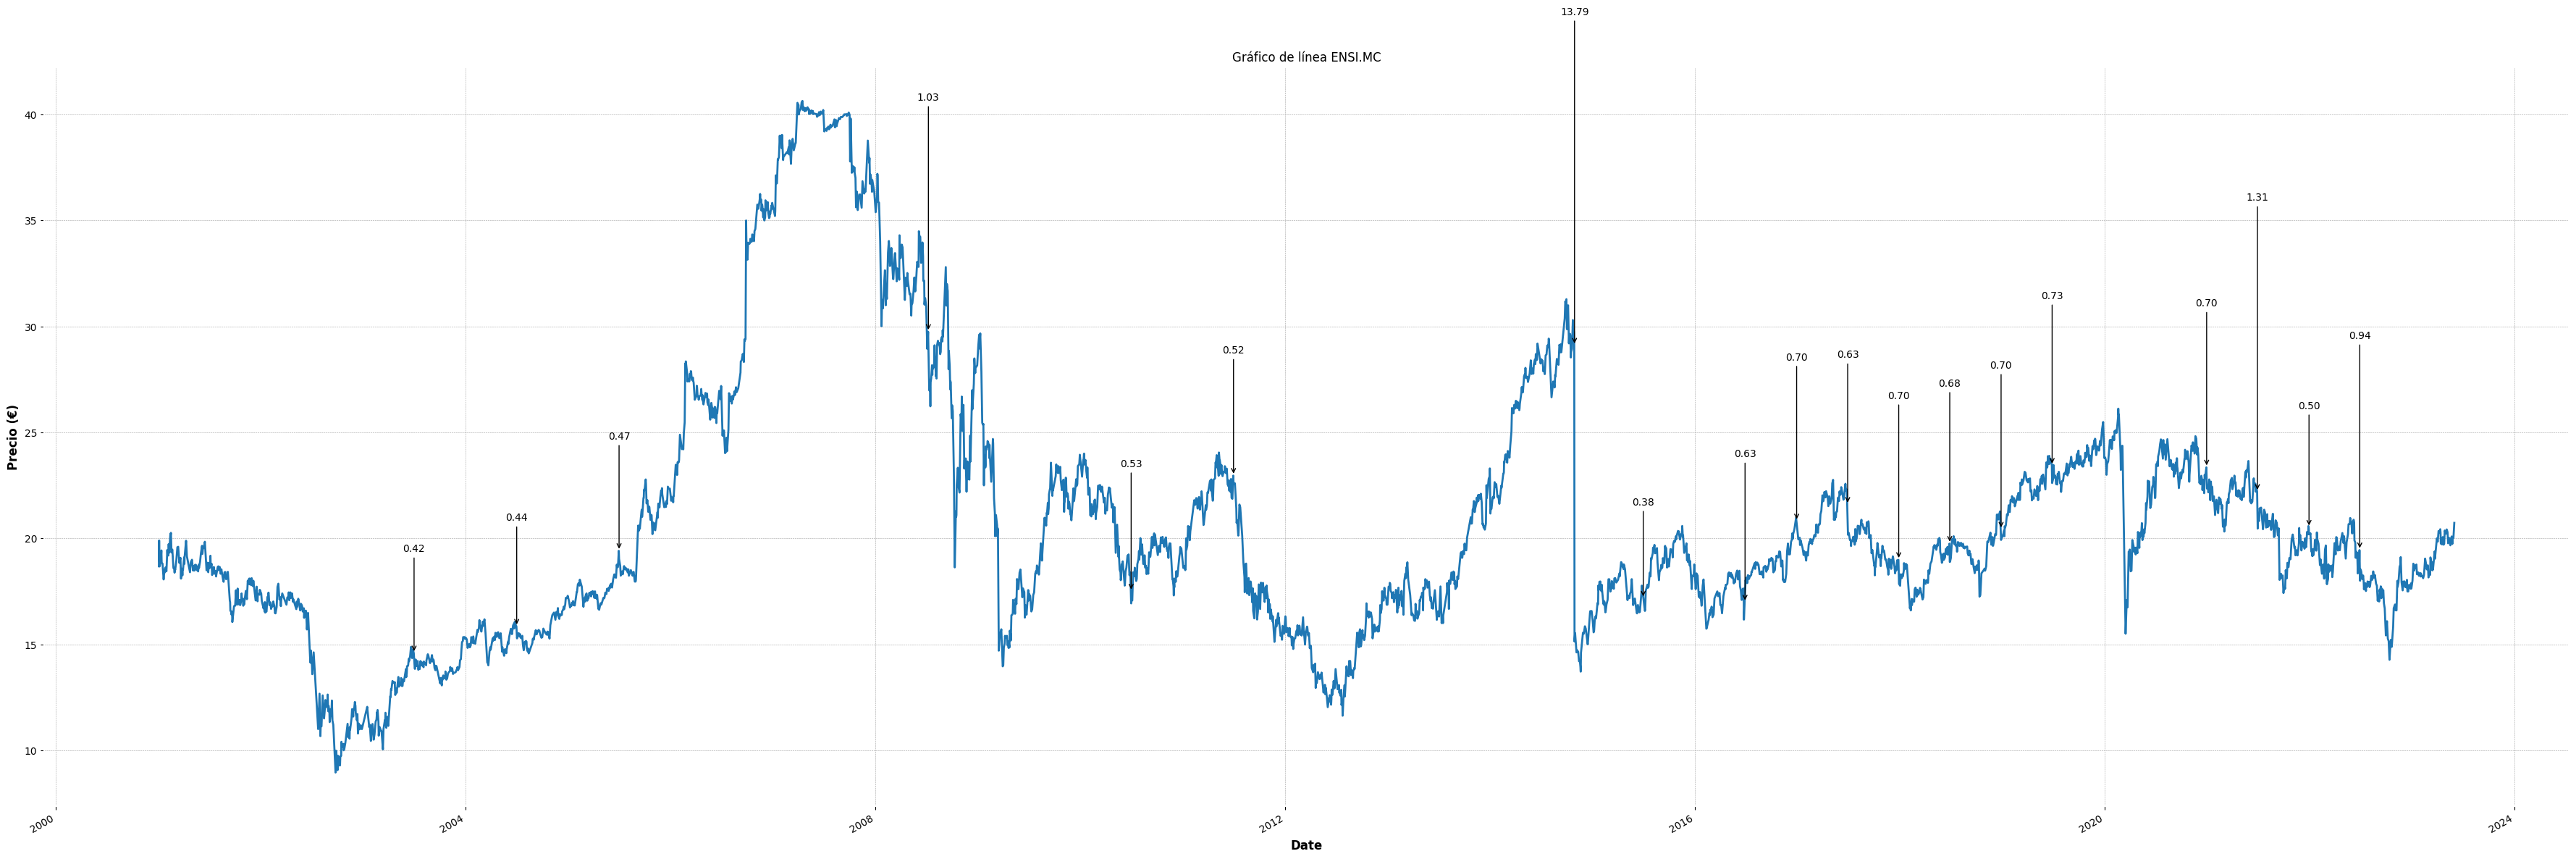

In [14]:
fechas_str = [ts.strftime('%Y-%m-%d') for ts in dividendos.index.tolist()]
sizes = dividendos.tolist()

plt.figure(figsize=(45,15))
ax = cotizacion['Close'].plot(title='Gráfico de línea ENSI.MC', ylabel='Precio (€)')

for idx, date in enumerate(fechas_str):
    previous_close = cotizacion['Close'].get(pd.Timestamp(date) - pd.Timedelta(days=1))
    if previous_close is not None:
        end_point = previous_close + sizes[idx] * 10 
        
        if sizes[idx] > 1.5:
            end_point = previous_close + 1.5 * 10

        ax.annotate(f'{sizes[idx]:.2f}', xy=(date, previous_close), xytext=(date, end_point + 0.5), 
                    arrowprops=dict(facecolor='red', arrowstyle="->"),
                    horizontalalignment='center', verticalalignment='bottom')

plt.show()

## Si los valores de los dividendos se 'restan aritméticamente' del precio de la acción, podríamos pensar que su efecto se puede revertir a la hora de manejar la serie temporal, teniendo en cuenta restarle el valor total de los dividendos para obtener la versión real.

In [15]:
print(f"El valor total de los dividendos hasta el momento es de {dividendos.sum()}")

El valor total de los dividendos hasta el momento es de 42.89566


In [16]:
dividendos_resampled = dividendos.resample('D').sum().fillna(0)
dividendos_acumulados = dividendos_resampled.cumsum()

dividendos_acumulados.index = dividendos_acumulados.index.tz_localize(None)

end_date = pd.Timestamp('2023-06-30').tz_localize(None)
new_index = pd.date_range(dividendos_acumulados.index[0], end_date)

dividendos_acumulados = dividendos_acumulados.reindex(new_index, method='ffill')

print(dividendos_acumulados)

2001-01-02     0.24000
2001-01-03     0.24000
2001-01-04     0.24000
2001-01-05     0.24000
2001-01-06     0.24000
                ...   
2023-06-26    42.89566
2023-06-27    42.89566
2023-06-28    42.89566
2023-06-29    42.89566
2023-06-30    42.89566
Freq: D, Name: Dividends, Length: 8215, dtype: float64


In [17]:
dividendos_acumulados.index = dividendos_acumulados.index.tz_localize(None)
cotizacion['Close'] += dividendos_acumulados.reindex(cotizacion.index, fill_value=0)

print(cotizacion['Close'])

Date
2001-01-02    18.92000
2001-01-03    20.14000
2001-01-04    19.24000
2001-01-05    18.92000
2001-01-08    19.06000
                ...   
2023-05-26    62.87566
2023-05-29    62.91566
2023-05-30    63.21566
2023-05-31    63.12566
2023-06-01    63.62566
Name: Close, Length: 5699, dtype: float64


## Esta sería la serie temporal de Close restando el impacto de los dividendos.
### La resampleamos además a su media mensual, restando así complejidad al dataset y evitando el efecto de pequeños 'movimientos' bursátiles que el propio mercado compense a corto plazo (mensual).

In [18]:
cotizacion_mensual = cotizacion['Close'].resample('M').median().to_frame(name='Close')

print(cotizacion_mensual)

                Close
Date                 
2001-01-31  18.920000
2001-02-28  19.580000
2001-03-31  19.115000
2001-04-30  19.119999
2001-05-31  18.920000
...               ...
2023-02-28  61.410660
2023-03-31  61.830659
2023-04-30  62.888160
2023-05-31  62.898161
2023-06-30  63.625660

[270 rows x 1 columns]


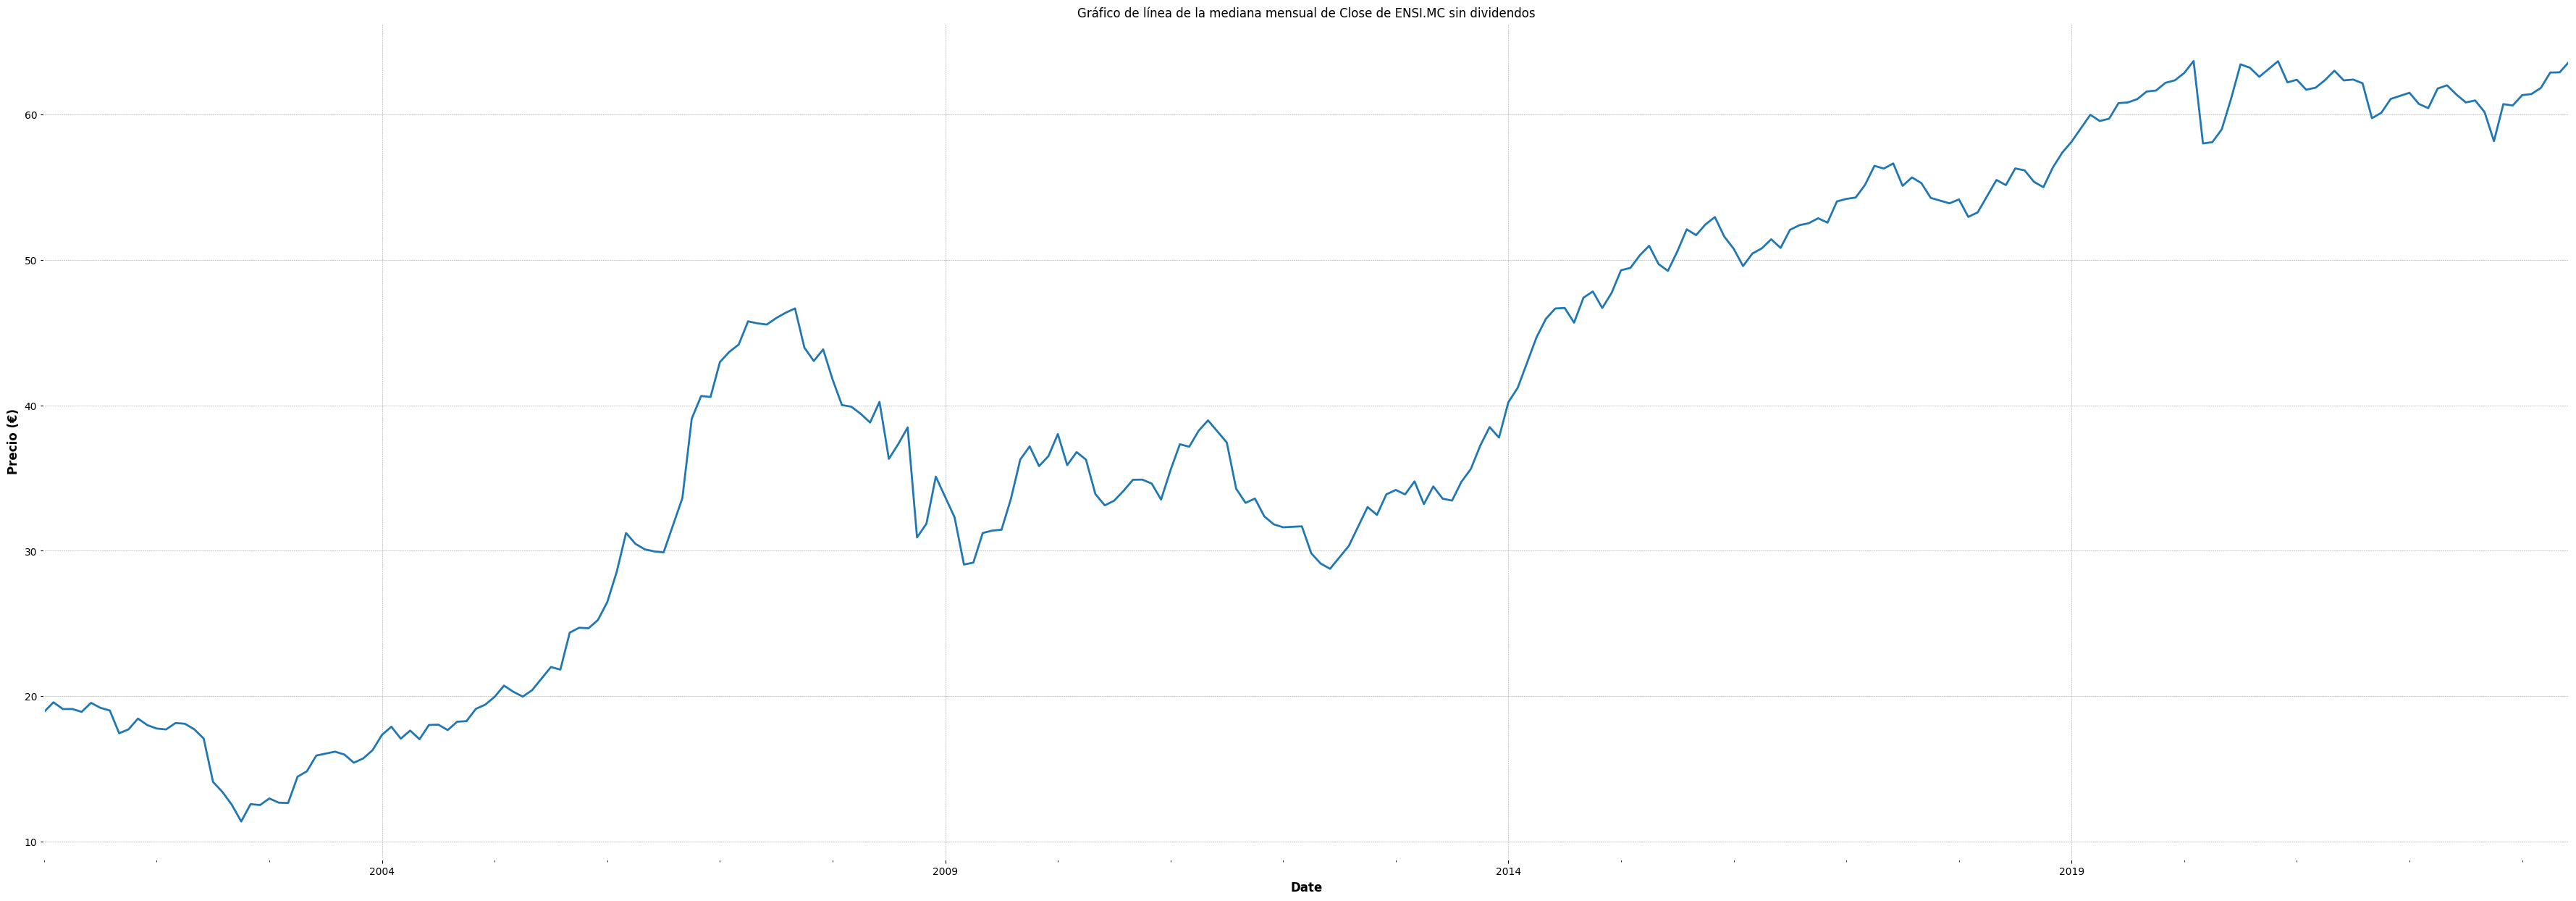

In [19]:
fechas_str = [ts.strftime('%Y-%m-%d') for ts in dividendos.index.tolist()]

plt.figure(figsize=(45,15))
ax = cotizacion_mensual['Close'].plot(title='Gráfico de línea de la mediana mensual de Close de ENSI.MC sin dividendos', ylabel='Precio (€)')

plt.show()

## Se propone:
Probar dos métodos de predicción de serie temporal que predigan el precio de la acción 12 meses más adelante de la última fecha conocida (mes del 2023-06).

# $\color{red}{\text{Esta fucnión la traslado desde abajo}}$

In [20]:
#tscv = TimeSeriesSplit(n_splits=5) # No personaliza suficientemente los cortes

def custom_time_series_split(df, train_months, test_months):
    ventanas = []
    
    total_months = train_months + test_months
    
    n_splits = int((len(df) - train_months) / test_months)
    
    for split in range(n_splits):
        start_train = split * test_months
        end_train = start_train + train_months
        
        start_test = end_train
        end_test = start_test + test_months
        
        if end_test > len(df):
            end_test = len(df)
        
        ventanas.append((
            df.index[start_train],
            df.index[end_train - 1], 
            df.index[start_test],
            df.index[end_test - 1] ))
    
    return ventanas

# $\color{red}{\text{A partir de aquí holtwinters}}$

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_months = 36
test_months = 12

cotizacion_temp = cotizacion_mensual['Close']
cotizacion_temp

Date
2001-01-31    18.920000
2001-02-28    19.580000
2001-03-31    19.115000
2001-04-30    19.119999
2001-05-31    18.920000
                ...    
2023-02-28    61.410660
2023-03-31    61.830659
2023-04-30    62.888160
2023-05-31    62.898161
2023-06-30    63.625660
Freq: M, Name: Close, Length: 270, dtype: float64

In [22]:
ventanas = custom_time_series_split(cotizacion_temp, train_months, test_months)

resultados = []

for ventana in ventanas:
    start_train, end_train, start_test, end_test = ventana

    train_data = cotizacion_temp[start_train:end_train].asfreq('M')
    test_data = cotizacion_temp[start_test:end_test].asfreq('M')

    if train_data.isna().any() or test_data.isna().any():
        print("Se encontraron valores NaN. Revisa tus datos.")
        continue

    model = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=12).fit()
    
    predictions = model.forecast(len(test_data))

    mse = mean_squared_error(test_data, predictions)

    resultados.append({
        'Ventana': ventana, 
        'MSE': mse, 
        'real': test_data.tolist(), 
        'prediccion': predictions.tolist()
    })

In [23]:
df_resultadosholtwinters = pd.DataFrame(resultados)
df_resultadosholtwinters

Ventana        MSE  \
0   (2001-01-31 00:00:00, 2003-12-31 00:00:00, 200...   3.151619   
1   (2002-01-31 00:00:00, 2004-12-31 00:00:00, 200...  11.840223   
2   (2003-01-31 00:00:00, 2005-12-31 00:00:00, 200...  78.149793   
3   (2004-01-31 00:00:00, 2006-12-31 00:00:00, 200...  27.739198   
4   (2005-01-31 00:00:00, 2007-12-31 00:00:00, 200...  55.481546   
5   (2006-01-31 00:00:00, 2008-12-31 00:00:00, 200...  12.623541   
6   (2007-01-31 00:00:00, 2009-12-31 00:00:00, 201...   4.642787   
7   (2008-01-31 00:00:00, 2010-12-31 00:00:00, 201...  17.500362   
8   (2009-01-31 00:00:00, 2011-12-31 00:00:00, 201...   4.103148   
9   (2010-01-31 00:00:00, 2012-12-31 00:00:00, 201...   4.526795   
10  (2011-01-31 00:00:00, 2013-12-31 00:00:00, 201...  66.632932   
11  (2012-01-31 00:00:00, 2014-12-31 00:00:00, 201...  12.210791   
12  (2013-01-31 00:00:00, 2015-12-31 00:00:00, 201...   2.993666   
13  (2014-01-31 00:00:00, 2016-12-31 00:00:00, 201...   1.387505   
14  (2015-01-31 00:00:00, 2017-12-31 00:00:00, 201...   2.777410   
15  (2016-01-31 00:00:00, 2018-12-31 00:00:00, 201...  12.939492   
16  (2017-01-31 00:00:00, 2019-12-31 00:00:00, 202...   6.396092   
17  (2018-01-31 00:00:00, 2020-12-31 00:00:00, 202...   1.666215   
18  (2019-01-31 00:00:00, 2021-12-31 00:00:00, 202...   1.613606   

                                                 real  \
0   [17.34400005722046, 17.89900036239624, 17.0790...   
1   [19.954999198913576, 20.724999656677248, 20.29...   
2   [26.47119908447266, 28.536199618530276, 31.221...   
3   [42.977858855590824, 43.67786152587891, 44.177...   
4   [41.782861678466794, 40.01785847412109, 39.907...   
5   [33.64886076293945, 32.298859427795406, 29.052...   
6   [38.02586030517578, 35.88585996185303, 36.7858...   
7   [35.53385984741211, 37.32385980926514, 37.1538...   
8   [31.613360324249268, 31.64086, 31.680859961853...   
9   [34.18185946594238, 33.876860114440916, 34.771...   
10  [40.21935984741211, 41.21435973297119, 43.0068...   
11  [49.2918608392334, 49.44936015258789, 50.31686...   
12  [50.77185969482422, 49.57686, 50.4418597711181...   
13  [54.19535954223633, 54.29035980926514, 55.1678...   
14  [54.163359771118174, 52.95835984741212, 53.270...   
15  [58.13286034332277, 59.07786003814699, 59.9828...   
16  [62.8548594659424, 63.67986022888185, 58.00986...   
17  [62.3898598855591, 61.7048594659424, 61.844860...   
18  [61.493459847412126, 60.72846045776369, 60.438...   

                                           prediccion  
0   [16.4998212591159, 16.670375649241226, 16.7225...  
1   [20.076135250778133, 20.080565162215876, 19.88...  
2   [25.50907490290599, 25.505661816179735, 24.735...  
3   [40.498944208220394, 40.98581274354187, 40.822...  
4   [44.63675971271292, 45.129542549558394, 45.363...  
5   [34.9145426303509, 35.0133124975623, 35.803774...  
6   [35.07993656227327, 34.49432208804337, 33.7615...  
7   [34.34447845560334, 32.79881480405018, 32.1859...  
8   [33.589686922866775, 33.024745580650205, 32.18...  
9   [34.91041630715261, 34.889415679803335, 35.232...  
10  [37.738648517472505, 38.181522595798924, 38.37...  
11  [48.40838945763364, 48.18097040517148, 48.6235...  
12  [52.823808876591585, 52.588498168521745, 53.25...  
13  [53.817559137962874, 53.425730557452056, 54.22...  
14  [53.39018051846958, 52.96217526277721, 53.7182...  
15  [57.29395186577931, 56.34417400428267, 56.8477...  
16  [62.51915923842787, 62.23279912347158, 62.6997...  
17  [62.49522091170306, 62.45210367229936, 60.7365...  
18  [61.49583715550679, 61.76409313444048, 60.1290...

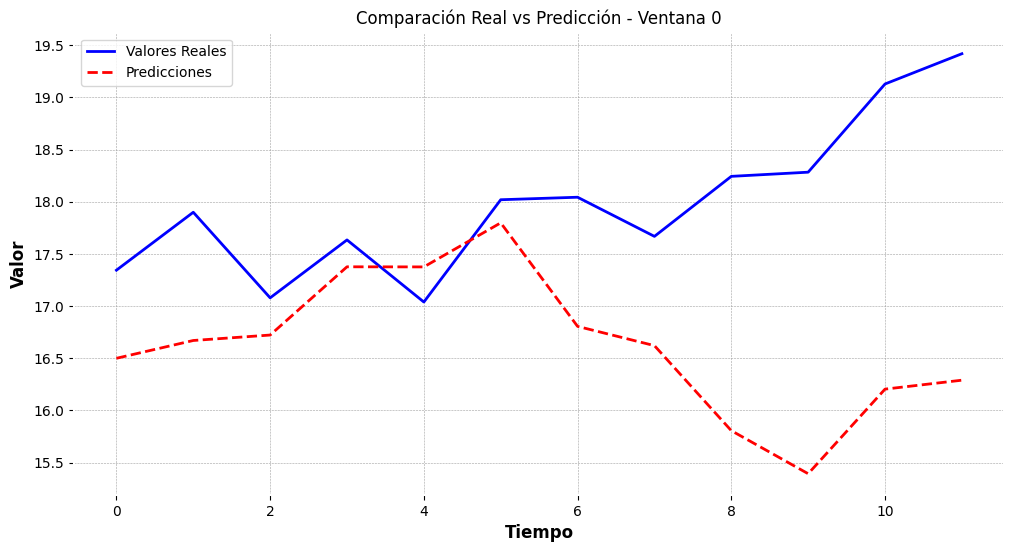

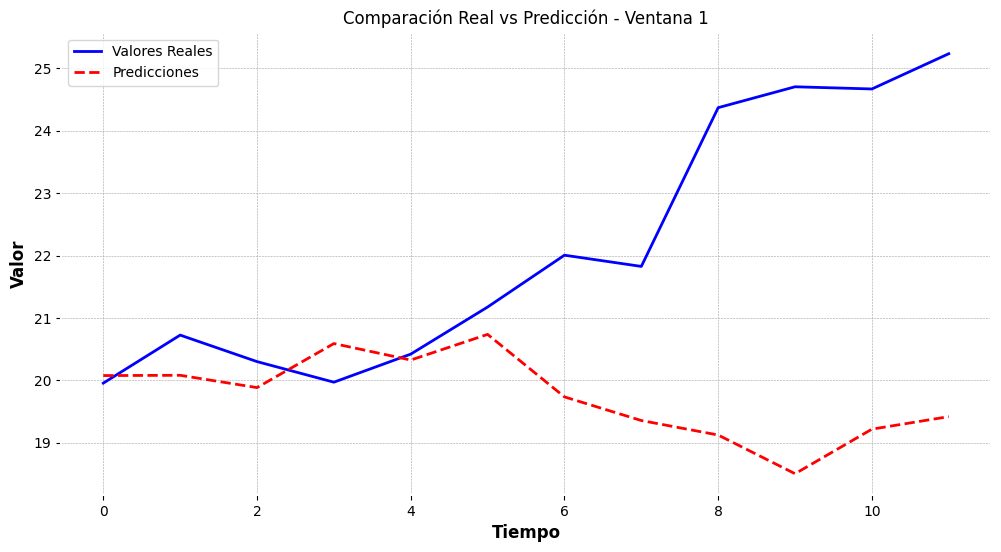

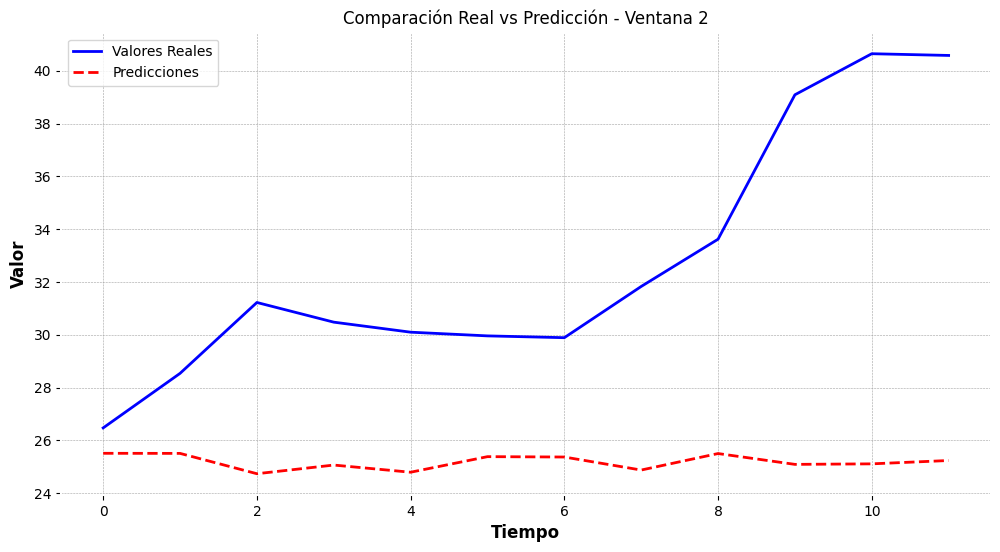

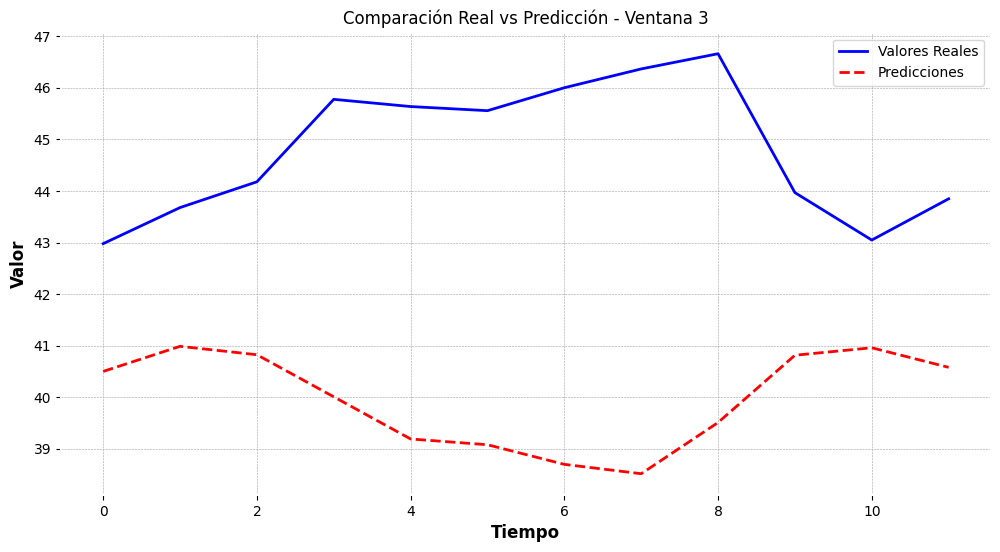

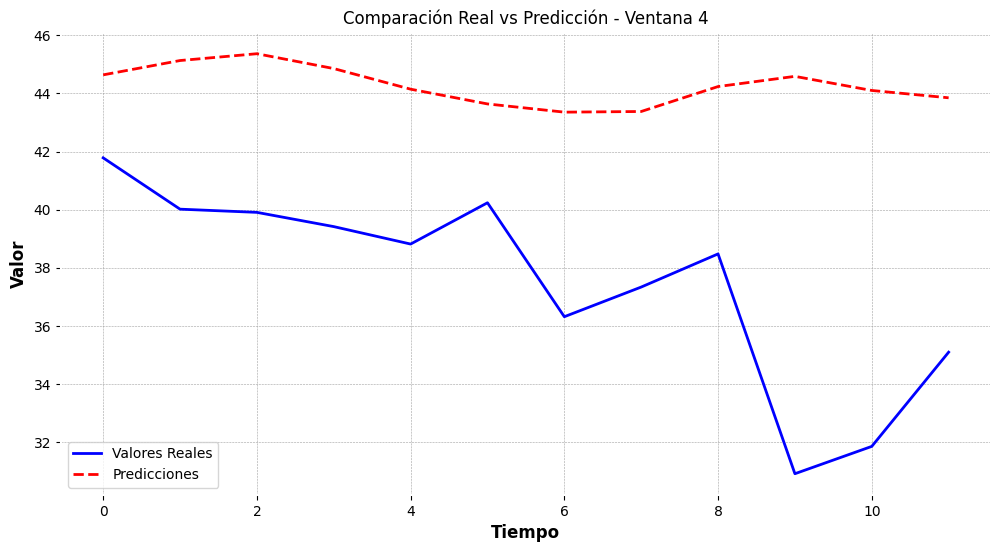

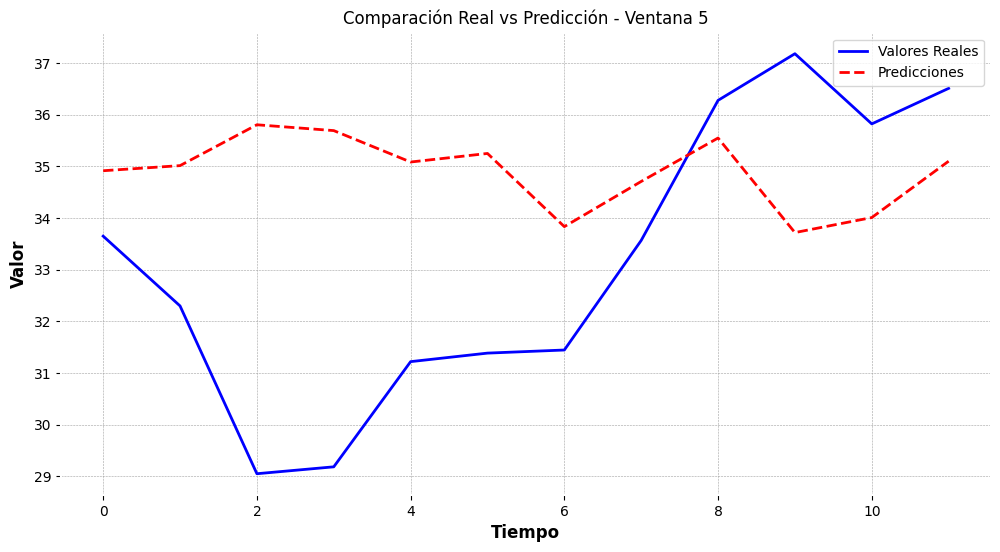

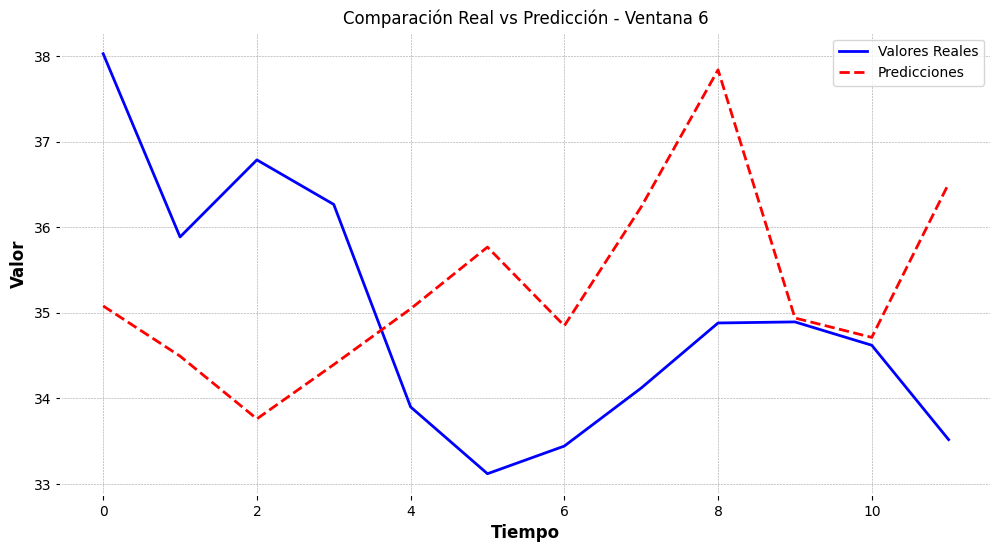

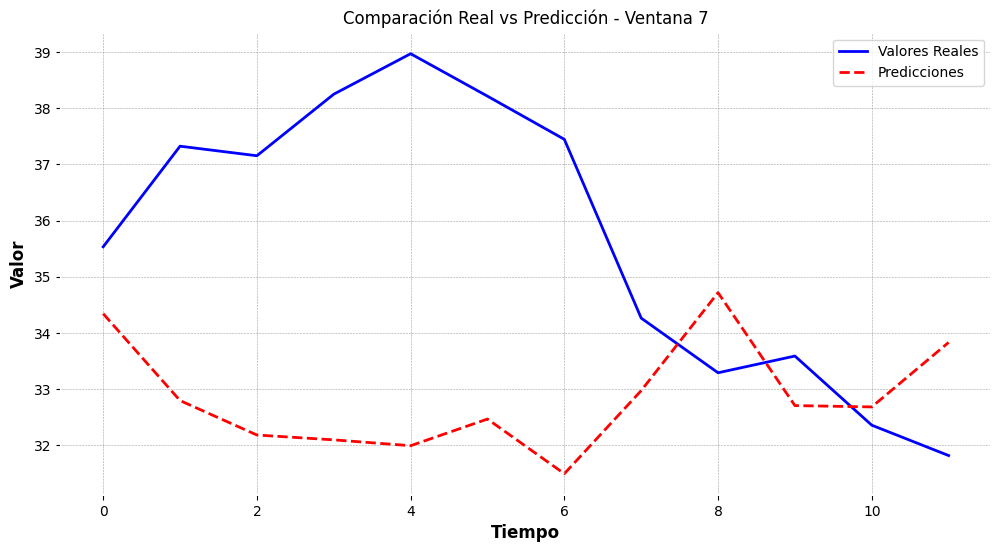

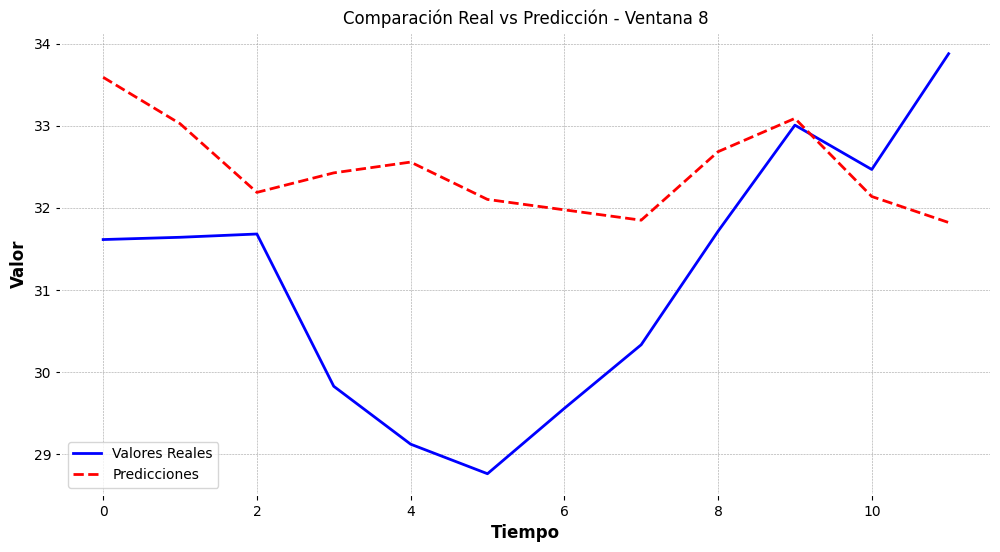

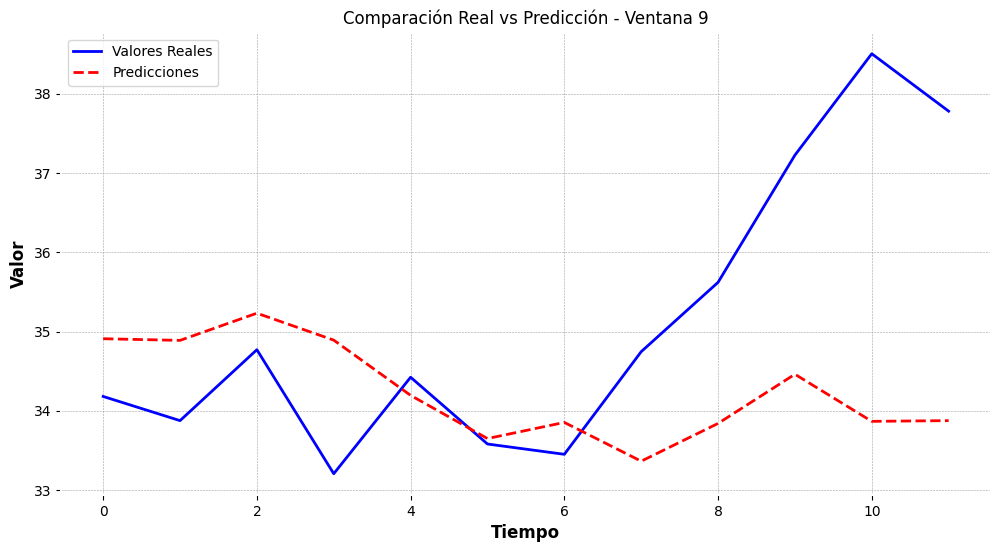

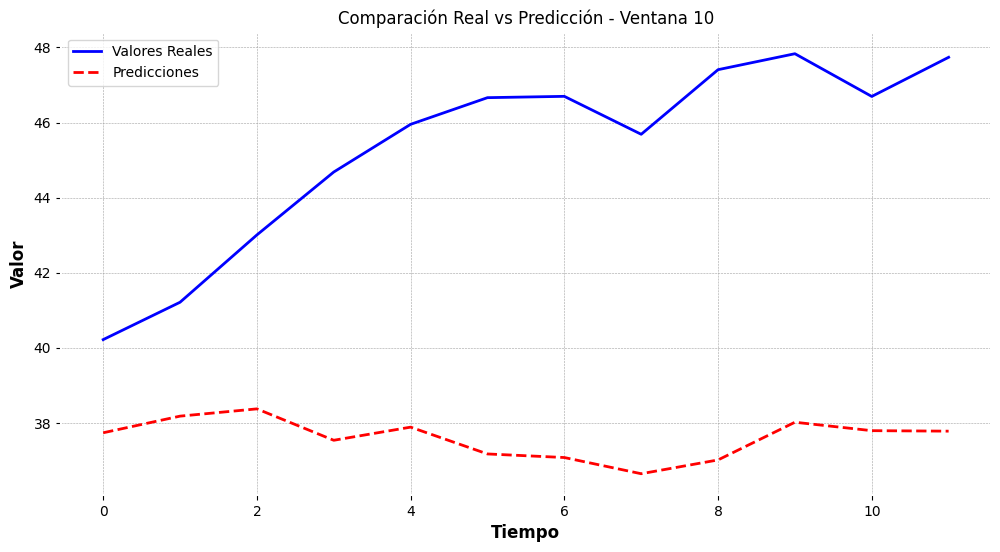

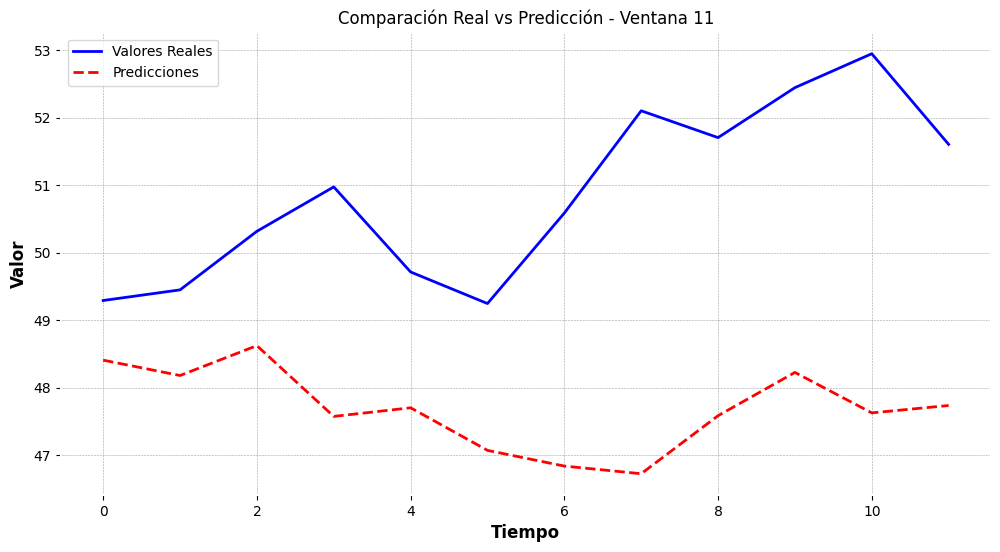

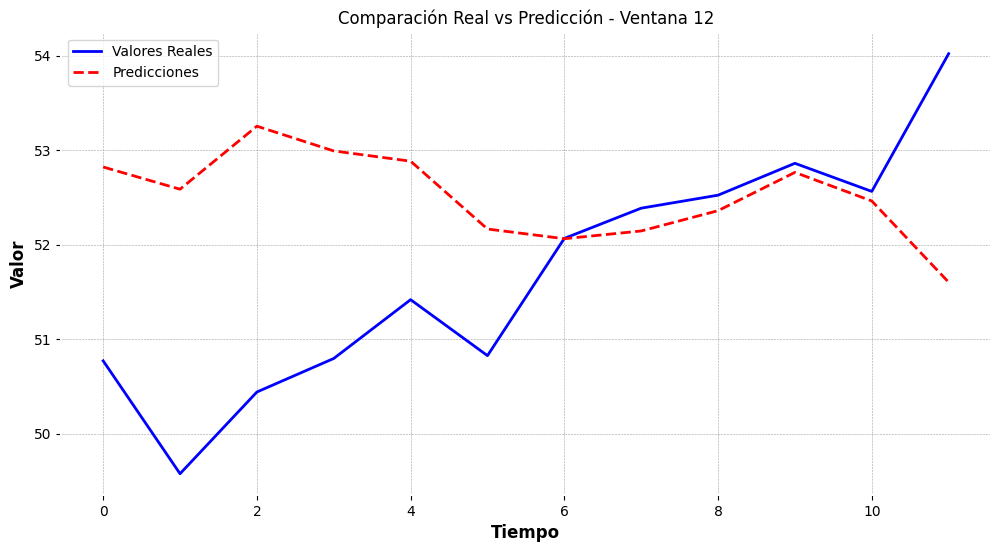

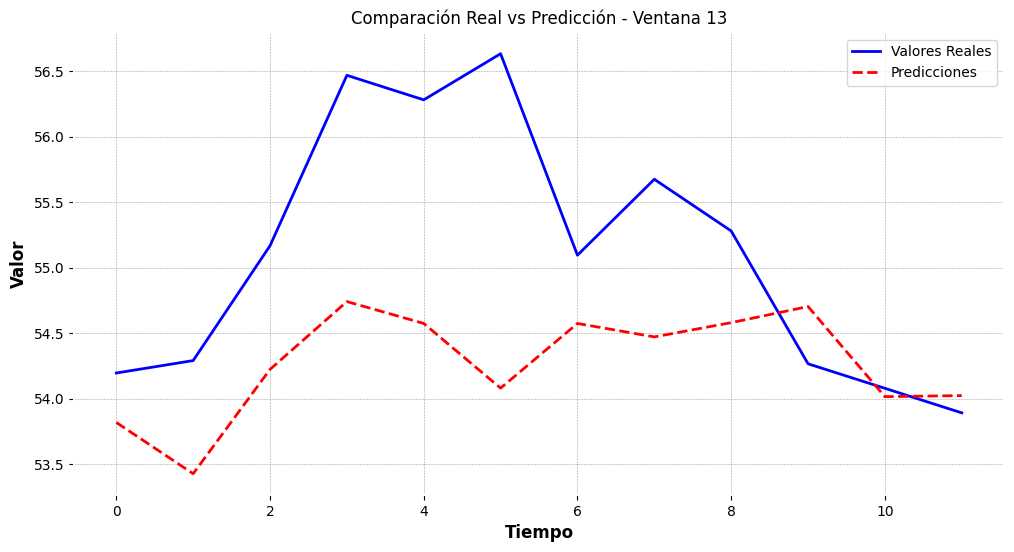

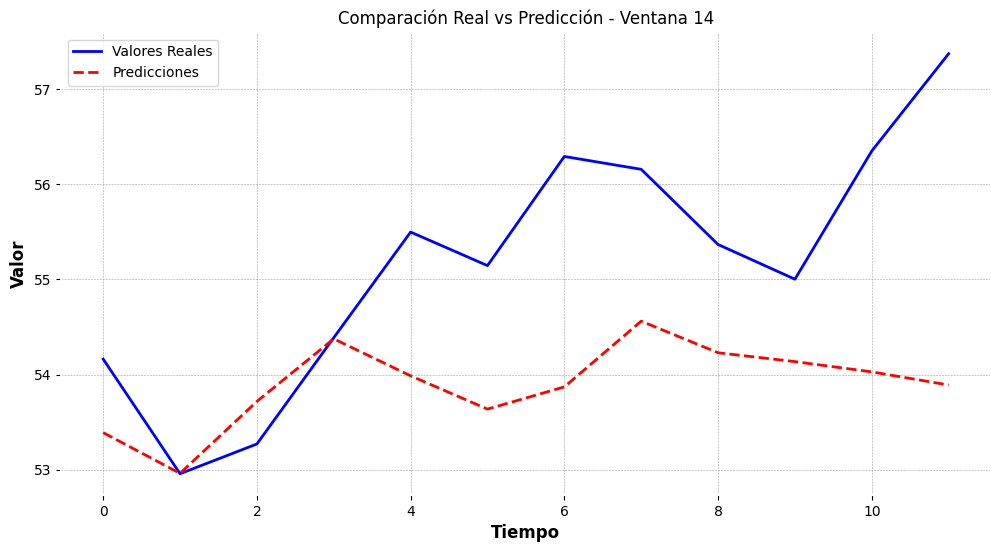

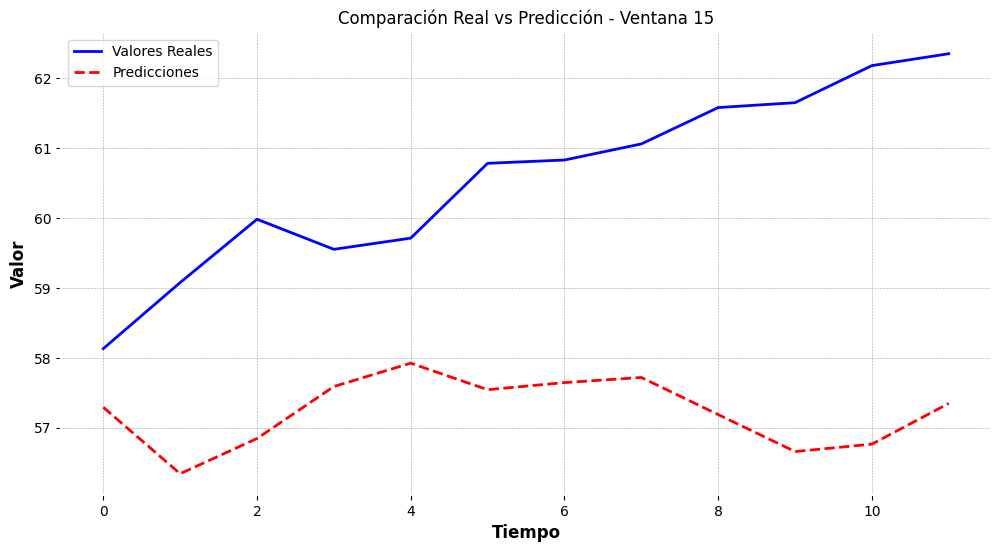

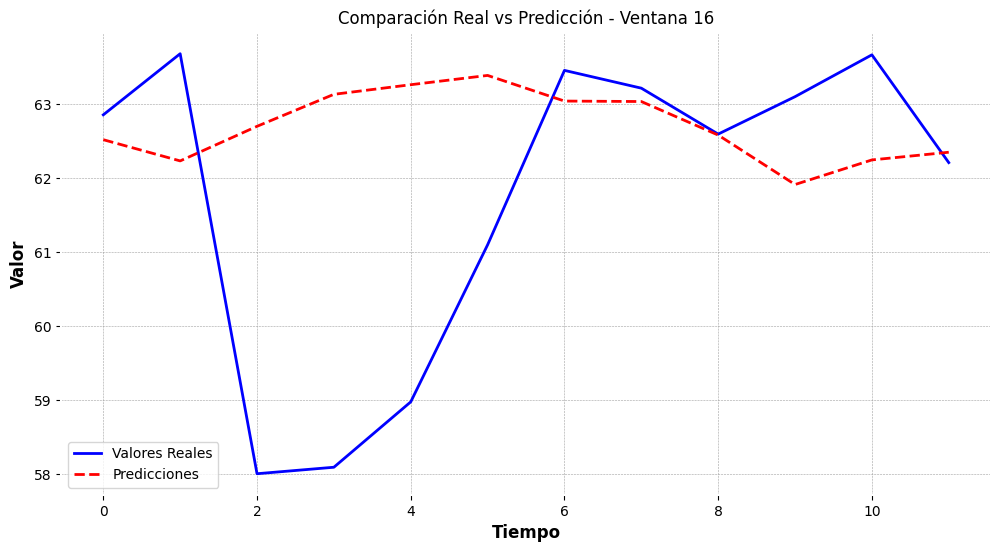

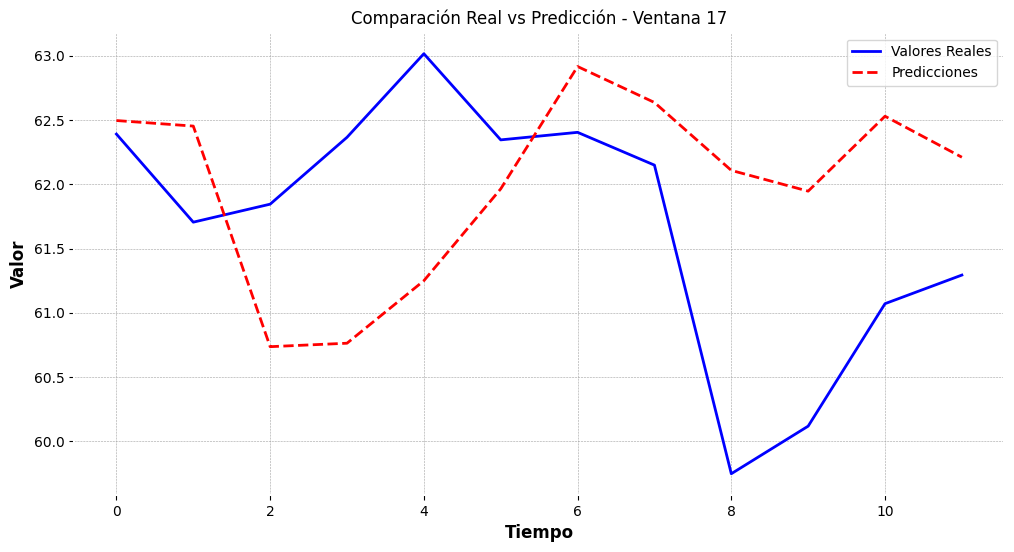

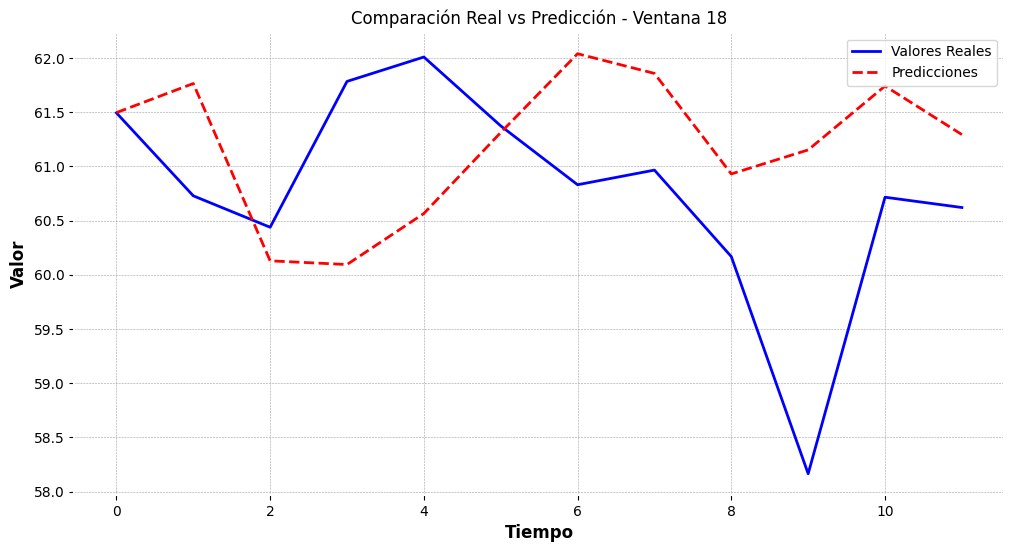

In [24]:
for index, row in df_resultadosholtwinters.iterrows():
    plt.figure(figsize=(12, 6))
    plt.plot(row['real'], label='Valores Reales', color='blue')
    plt.plot(row['prediccion'], label='Predicciones', color='red', linestyle='--')
    
    plt.title(f'Comparación Real vs Predicción - Ventana {index}')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

# $\color{red}{\text{Hasta aquí holtwinters}}$

## XGBoost Regressor con Cross Validation e hiperparametrización

Preparamos el dataframe obteniendo 'lags', es decir, pasos para atrás y mantenemos la columna "Close" como variable independiente.

In [25]:
num_lags = 20
for lag in range(1, num_lags + 1):
    cotizacion_mensual[f'lag_{lag}'] = cotizacion_mensual['Close'].shift(lag)

cotizacion_mensual = cotizacion_mensual.dropna()

In [26]:
cotizacion_mensual.head()

Close    lag_1    lag_2    lag_3      lag_4      lag_5  \
Date                                                                   
2002-09-30  12.5325  13.4125  14.1025  17.0890  17.723999  18.104001   
2002-10-31  11.3825  12.5325  13.4125  14.1025  17.089000  17.723999   
2002-11-30  12.5775  11.3825  12.5325  13.4125  14.102500  17.089000   
2002-12-31  12.5125  12.5775  11.3825  12.5325  13.412500  14.102500   
2003-01-31  12.9665  12.5125  12.5775  11.3825  12.532500  13.412500   

                lag_6      lag_7      lag_8      lag_9  ...     lag_11  \
Date                                                    ...              
2002-09-30  18.154000  17.713999  17.774001  18.010000  ...  17.720000   
2002-10-31  18.104001  18.154000  17.713999  17.774001  ...  18.460000   
2002-11-30  17.723999  18.104001  18.154000  17.713999  ...  18.010000   
2002-12-31  17.089000  17.723999  18.104001  18.154000  ...  17.774001   
2003-01-31  14.102500  17.089000  17.723999  18.104001  ...  17.713999   

               lag_12     lag_13     lag_14     lag_15     lag_16     lag_17  \
Date                                                                           
2002-09-30  17.449999  19.015000  19.199999  19.539999  18.920000  19.119999   
2002-10-31  17.720000  17.449999  19.015000  19.199999  19.539999  18.920000   
2002-11-30  18.460000  17.720000  17.449999  19.015000  19.199999  19.539999   
2002-12-31  18.010000  18.460000  17.720000  17.449999  19.015000  19.199999   
2003-01-31  17.774001  18.010000  18.460000  17.720000  17.449999  19.015000   

               lag_18     lag_19     lag_20  
Date                                         
2002-09-30  19.115000  19.580000  18.920000  
2002-10-31  19.119999  19.115000  19.580000  
2002-11-30  18.920000  19.119999  19.115000  
2002-12-31  19.539999  18.920000  19.119999  
2003-01-31  19.199999  19.539999  18.920000  

[5 rows x 21 columns]

### Creamos ventanas para la cross validation, que utilizaremos más adelante en la prueba de otros modelos

In [27]:
train_months = 36
test_months = 12

ventanas = custom_time_series_split(cotizacion_mensual, train_months, test_months)

for i, ventana in enumerate(ventanas):
    print(f"Ventana {i}: {[timest.strftime('%Y-%m-%d') for timest in ventana]}")

Ventana 0: ['2002-09-30', '2005-08-31', '2005-09-30', '2006-08-31']
Ventana 1: ['2003-09-30', '2006-08-31', '2006-09-30', '2007-08-31']
Ventana 2: ['2004-09-30', '2007-08-31', '2007-09-30', '2008-08-31']
Ventana 3: ['2005-09-30', '2008-08-31', '2008-09-30', '2009-08-31']
Ventana 4: ['2006-09-30', '2009-08-31', '2009-09-30', '2010-08-31']
Ventana 5: ['2007-09-30', '2010-08-31', '2010-09-30', '2011-08-31']
Ventana 6: ['2008-09-30', '2011-08-31', '2011-09-30', '2012-08-31']
Ventana 7: ['2009-09-30', '2012-08-31', '2012-09-30', '2013-08-31']
Ventana 8: ['2010-09-30', '2013-08-31', '2013-09-30', '2014-08-31']
Ventana 9: ['2011-09-30', '2014-08-31', '2014-09-30', '2015-08-31']
Ventana 10: ['2012-09-30', '2015-08-31', '2015-09-30', '2016-08-31']
Ventana 11: ['2013-09-30', '2016-08-31', '2016-09-30', '2017-08-31']
Ventana 12: ['2014-09-30', '2017-08-31', '2017-09-30', '2018-08-31']
Ventana 13: ['2015-09-30', '2018-08-31', '2018-09-30', '2019-08-31']
Ventana 14: ['2016-09-30', '2019-08-31', '20

Obtenemos 30 combinaciones distintas para la búsqueda, dentro del marco definido en 'space'

In [28]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 100),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2)
}

samples = [sample(space) for _ in range(30)]

for sample_ in samples:
    sample_['max_depth'] = int(sample_['max_depth'])
    sample_['min_child_weight'] = int(sample_['min_child_weight'])
    sample_['n_estimators'] = int(sample_['n_estimators'])

for i, params in enumerate(samples):
    print(f"Sample {i+1}: {params}")

Sample 1: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Sample 2: {'learning_rate': 0.12117387490693916, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6837763318116481}
Sample 3: {'learning_rate': 0.11058159057960458, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8214834332824965}
Sample 4: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Sample 5: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}
Sample 6: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Sample 7: {'learning_rate': 0.12916000012007, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9223672345036704}
Sample 8: {'

In [29]:
lags = [5, 10, 20]

resultados_xgb = []
for start_train_date, end_train_date, start_test_date, end_test_date in ventanas:
    for hyper in samples:
        for lg in lags:
            print(f"Probamos con Train desde {start_train_date} hasta {end_train_date} y con Test desde {start_test_date} hasta {end_test_date}")
            print(f"Con {lg} lags.")
            print(f"Con los siguientes hiperparámetros: {hyper}")

            train = cotizacion_mensual[(cotizacion_mensual.index >= start_train_date) & (cotizacion_mensual.index <= end_train_date)]
            test = cotizacion_mensual[(cotizacion_mensual.index > end_train_date) & (cotizacion_mensual.index <= end_test_date)]

            X_train, y_train = train.drop('Close', axis=1), train['Close']
            X_test, y_test = test.drop('Close', axis=1), test['Close'].tolist()
            
            X_train = X_train[X_train.columns[:lg]]
            X_test = X_test[X_test.columns[:lg]]

            model = xgb.XGBRegressor(**hyper)
            model.fit(X_train, y_train)

            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            print(f"Obteniendo un MSE de: {mse}")
            print("*"*50)

            iteracion = {
                'start_train_date': start_train_date, 
                'end_train_date': end_train_date, 
                'start_test_date': start_test_date, 
                'end_test_date': end_test_date,
                'lags': lg,
                'hyper': hyper,
                'real': y_test,
                'preds': preds,
                'mse': mse 
            }
            resultados_xgb.append(iteracion)

resultados_xgb = pd.DataFrame(resultados_xgb)

Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 46.946409385685904
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 46.38735169820989
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learn

Obteniendo un MSE de: 49.92672786312196
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17944272845863346, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.6397193584944393}
Obteniendo un MSE de: 45.91083177277432
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17944272845863346, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.6397193584944393}
Obteniendo un MSE de: 63.39687908774399
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-3

Obteniendo un MSE de: 60.62547837468793
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10962829909001076, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9142229997468755}
Obteniendo un MSE de: 46.90181875375492
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10962829909001076, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9142229997468755}
Obteniendo un MSE de: 46.829490452704285
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-3

Obteniendo un MSE de: 45.75943525497797
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08363549996324043, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.6221501044008744}
Obteniendo un MSE de: 62.92845396652436
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30 00:00:00 hasta 2006-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 46.96897826187277
**************************************************
Probamos con Train desde 2002-09-30 00:00:00 hasta 2005-08-31 00:00:00 y con Test desde 2005-09-30

Obteniendo un MSE de: 165.61037221728515
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12117387490693916, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6837763318116481}
Obteniendo un MSE de: 177.56193008286425
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12117387490693916, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6837763318116481}
Obteniendo un MSE de: 176.42367684035244
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09

Obteniendo un MSE de: 175.8237253254072
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}
Obteniendo un MSE de: 164.06110112621187
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}
Obteniendo un MSE de: 172.01651190633865
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-3

Obteniendo un MSE de: 166.48252493465995
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 166.61968012028203
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 163.63556886436794
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-0

Obteniendo un MSE de: 174.90759702794415
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 162.24407308477967
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-30 00:00:00 hasta 2007-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10235330968403245, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8432514768712326}
Obteniendo un MSE de: 176.2131049579459
**************************************************
Probamos con Train desde 2003-09-30 00:00:00 hasta 2006-08-31 00:00:00 y con Test desde 2006-09-

Obteniendo un MSE de: 11.614613389300715
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11058159057960458, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8214834332824965}
Obteniendo un MSE de: 8.129181245759414
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11058159057960458, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8214834332824965}
Obteniendo un MSE de: 9.389425785213527
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-3

Obteniendo un MSE de: 11.111891170870804
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}
Obteniendo un MSE de: 11.52234433777326
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}
Obteniendo un MSE de: 19.41960510090653
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 

Obteniendo un MSE de: 9.20478402818417
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 12.79913468754802
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 14.211274507906856
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-3

Obteniendo un MSE de: 11.166940836688894
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 11.852414230964884
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-30 00:00:00 hasta 2008-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10235330968403245, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8432514768712326}
Obteniendo un MSE de: 9.612627779586687
**************************************************
Probamos con Train desde 2004-09-30 00:00:00 hasta 2007-08-31 00:00:00 y con Test desde 2007-09-

Obteniendo un MSE de: 18.862963455162813
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Obteniendo un MSE de: 13.69384999411092
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Obteniendo un MSE de: 12.889921189610073
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-

Obteniendo un MSE de: 13.850858150934153
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}
Obteniendo un MSE de: 14.536251789756845
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}
Obteniendo un MSE de: 14.971922403446714
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-3

Obteniendo un MSE de: 13.883711917863552
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 15.838188346969673
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 16.441795848145123
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09

Obteniendo un MSE de: 13.797217000429397
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 13.624571323520149
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09-30 00:00:00 hasta 2009-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 13.293700412577316
**************************************************
Probamos con Train desde 2005-09-30 00:00:00 hasta 2008-08-31 00:00:00 y con Test desde 2008-09

Obteniendo un MSE de: 28.721975968799274
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11058159057960458, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8214834332824965}
Obteniendo un MSE de: 5.28853243330004
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11058159057960458, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8214834332824965}
Obteniendo un MSE de: 0.9772124753562944
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-3

Obteniendo un MSE de: 30.014974952132224
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}
Obteniendo un MSE de: 7.803168397225607
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}
Obteniendo un MSE de: 2.43013191901019
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30

Obteniendo un MSE de: 7.70337176337813
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10962829909001076, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9142229997468755}
Obteniendo un MSE de: 3.001558582699266
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10962829909001076, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9142229997468755}
Obteniendo un MSE de: 10.196936846562126
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-3

Obteniendo un MSE de: 22.128808710470423
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 6.742879779497923
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-30 00:00:00 hasta 2010-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 2.420903324624932
**************************************************
Probamos con Train desde 2006-09-30 00:00:00 hasta 2009-08-31 00:00:00 y con Test desde 2009-09-3

Obteniendo un MSE de: 3.129524872085879
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Obteniendo un MSE de: 3.626767778733304
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Obteniendo un MSE de: 3.4717726505708395
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-

Obteniendo un MSE de: 3.9125516093801322
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 4.305152130751747
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 4.283880268830158
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-

Obteniendo un MSE de: 4.183202672689375
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}
Obteniendo un MSE de: 3.429112161186404
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}
Obteniendo un MSE de: 3.409803481365804
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 0

Obteniendo un MSE de: 3.7147428249123102
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12065069745007591, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.9530923257578611}
Obteniendo un MSE de: 3.3792854382618125
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09-30 00:00:00 hasta 2011-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}
Obteniendo un MSE de: 4.0328333986822384
**************************************************
Probamos con Train desde 2007-09-30 00:00:00 hasta 2010-08-31 00:00:00 y con Test desde 2010-09

Obteniendo un MSE de: 8.49717493096613
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 1.9364682229240946
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 4.486980802695618
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 0

Obteniendo un MSE de: 8.163723284922929
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 2.730127867520857
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 6.51148127838323
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 

Obteniendo un MSE de: 9.707932676458773
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}
Obteniendo un MSE de: 2.212737015480563
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}
Obteniendo un MSE de: 4.293051128740609
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:

Obteniendo un MSE de: 5.375007034639377
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12065069745007591, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.9530923257578611}
Obteniendo un MSE de: 13.21302585702509
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-30 00:00:00 hasta 2012-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}
Obteniendo un MSE de: 2.4580160633673076
**************************************************
Probamos con Train desde 2008-09-30 00:00:00 hasta 2011-08-31 00:00:00 y con Test desde 2011-09-3

Obteniendo un MSE de: 1.559533564722711
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}
Obteniendo un MSE de: 3.110047787754652
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}
Obteniendo un MSE de: 1.0542425405679154
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30

Obteniendo un MSE de: 0.8784829995669784
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 3.200995959228622
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 3.1327142179319813
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-

Obteniendo un MSE de: 0.8369422915680124
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}
Obteniendo un MSE de: 2.8103338642758353
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}
Obteniendo un MSE de: 2.6463513805587318
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09

Obteniendo un MSE de: 3.350100333742116
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}
Obteniendo un MSE de: 0.9789816737182632
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 00:00:00 hasta 2013-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}
Obteniendo un MSE de: 1.0616099868833
**************************************************
Probamos con Train desde 2009-09-30 00:00:00 hasta 2012-08-31 00:00:00 y con Test desde 2012-09-30 

Obteniendo un MSE de: 50.832786822144186
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 50.99470873635219
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 48.73799391910486
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30

Obteniendo un MSE de: 45.168784828242366
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 48.21335941987798
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 51.357894910057865
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09

Obteniendo un MSE de: 48.52328448632846
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}
Obteniendo un MSE de: 43.217474066379815
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}
Obteniendo un MSE de: 47.84670344503446
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 0

Obteniendo un MSE de: 52.5866983597125
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}
Obteniendo un MSE de: 47.788346686307726
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30 00:00:00 hasta 2014-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}
Obteniendo un MSE de: 50.71693788429986
**************************************************
Probamos con Train desde 2010-09-30 00:00:00 hasta 2013-08-31 00:00:00 y con Test desde 2013-09-30

Obteniendo un MSE de: 11.708717439155201
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}
Obteniendo un MSE de: 14.551945286368586
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}
Obteniendo un MSE de: 13.490348624632515
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-

Obteniendo un MSE de: 12.087318592895416
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 34.25942914181718
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10710844180420977, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.6365872911102188}
Obteniendo un MSE de: 11.732445177307783
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-

Obteniendo un MSE de: 12.43699192314004
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}
Obteniendo un MSE de: 13.33501079650266
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}
Obteniendo un MSE de: 21.333050572208908
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-

Obteniendo un MSE de: 13.27321838090743
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}
Obteniendo un MSE de: 19.628566916618617
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-30 00:00:00 hasta 2015-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}
Obteniendo un MSE de: 15.074578107208746
**************************************************
Probamos con Train desde 2011-09-30 00:00:00 hasta 2014-08-31 00:00:00 y con Test desde 2014-09-

Obteniendo un MSE de: 0.9654877979683233
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 00:00:00 hasta 2016-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 0.8638601632413224
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 00:00:00 hasta 2016-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12916000012007, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9223672345036704}
Obteniendo un MSE de: 2.1821469235164836
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 

Obteniendo un MSE de: 1.8182667427359513
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 00:00:00 hasta 2016-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10710844180420977, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.6365872911102188}
Obteniendo un MSE de: 1.0317497478828324
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 00:00:00 hasta 2016-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10710844180420977, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.6365872911102188}
Obteniendo un MSE de: 0.8825959011489656
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-0

Obteniendo un MSE de: 0.9026971835728944
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 00:00:00 hasta 2016-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08225614224702102, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7271161056133516}
Obteniendo un MSE de: 0.9509521580704089
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-30 00:00:00 hasta 2016-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1805988094762621, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9821482990344976}
Obteniendo un MSE de: 2.101728264794222
**************************************************
Probamos con Train desde 2012-09-30 00:00:00 hasta 2015-08-31 00:00:00 y con Test desde 2015-09-3

Obteniendo un MSE de: 0.876363661154477
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 12.920960713562556
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 14.75274935997728
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 

Obteniendo un MSE de: 15.056041872092878
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}
Obteniendo un MSE de: 13.585367848488259
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}
Obteniendo un MSE de: 15.507033935834306
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09

Obteniendo un MSE de: 14.162044165437264
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10962829909001076, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9142229997468755}
Obteniendo un MSE de: 15.408009133438746
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 13.216839845052933
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09

Obteniendo un MSE de: 15.325562669197913
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 12.26687843859785
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-30 00:00:00 hasta 2017-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}
Obteniendo un MSE de: 14.99122829730883
**************************************************
Probamos con Train desde 2013-09-30 00:00:00 hasta 2016-08-31 00:00:00 y con Test desde 2016-09-3

Obteniendo un MSE de: 0.6079004565494605
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Obteniendo un MSE de: 0.7946084628675449
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07335501555800325, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 200, 'subsample': 0.6917348693589089}
Obteniendo un MSE de: 0.812405674660872
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-

Obteniendo un MSE de: 0.6787332037792345
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 2.194965192687655
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11132709354713555, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.6110338193608387}
Obteniendo un MSE de: 2.277766307205724
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-3

Obteniendo un MSE de: 0.875776149595529
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}
Obteniendo un MSE de: 0.6224950049828856
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}
Obteniendo un MSE de: 1.0731991948069068
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30

Obteniendo un MSE de: 1.171851165525512
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}
Obteniendo un MSE de: 1.2803342383895062
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09-30 00:00:00 hasta 2018-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}
Obteniendo un MSE de: 1.0111133939583914
**************************************************
Probamos con Train desde 2014-09-30 00:00:00 hasta 2017-08-31 00:00:00 y con Test desde 2017-09

Obteniendo un MSE de: 16.153036582952875
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 19.72303015840346
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0563878810957137, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6075438433093854}
Obteniendo un MSE de: 14.73546424543764
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30

Obteniendo un MSE de: 17.1049174926691
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10710844180420977, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.6365872911102188}
Obteniendo un MSE de: 18.69068175188313
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10710844180420977, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.6365872911102188}
Obteniendo un MSE de: 14.580002639757211
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-3

Obteniendo un MSE de: 16.160047313596902
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08225614224702102, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7271161056133516}
Obteniendo un MSE de: 19.17437312549716
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08225614224702102, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7271161056133516}
Obteniendo un MSE de: 15.745803452114982
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09

Obteniendo un MSE de: 17.902809925033953
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}
Obteniendo un MSE de: 19.91232078068227
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09-30 00:00:00 hasta 2019-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}
Obteniendo un MSE de: 10.704111038298315
**************************************************
Probamos con Train desde 2015-09-30 00:00:00 hasta 2018-08-31 00:00:00 y con Test desde 2018-09

Obteniendo un MSE de: 5.302153115719324
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12916000012007, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9223672345036704}
Obteniendo un MSE de: 4.891704248302822
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12916000012007, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9223672345036704}
Obteniendo un MSE de: 4.578069302827566
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00

Obteniendo un MSE de: 4.607356456664797
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1719786002406973, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.7653401807055831}
Obteniendo un MSE de: 4.780200497892124
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1719786002406973, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.7653401807055831}
Obteniendo un MSE de: 4.147706117836514
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 0

Obteniendo un MSE de: 4.744376444450759
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1805988094762621, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9821482990344976}
Obteniendo un MSE de: 4.858313088796563
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1805988094762621, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9821482990344976}
Obteniendo un MSE de: 4.4237572204085955
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 

Obteniendo un MSE de: 3.83363154155739
**************************************************
Probamos con Train desde 2016-09-30 00:00:00 hasta 2019-08-31 00:00:00 y con Test desde 2019-09-30 00:00:00 hasta 2020-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19140651720691315, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7546857856809531}
Obteniendo un MSE de: 3.9648807054942465
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 6.008828526442329
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 

Obteniendo un MSE de: 9.524732543720097
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17944272845863346, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.6397193584944393}
Obteniendo un MSE de: 5.516454909979399
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17944272845863346, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.6397193584944393}
Obteniendo un MSE de: 3.1932460425757263
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-

Obteniendo un MSE de: 3.433369776370688
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.055421956381793154, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.7114032321128949}
Obteniendo un MSE de: 0.6168033367496549
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10962829909001076, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9142229997468755}
Obteniendo un MSE de: 5.2200901458316356
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09

Obteniendo un MSE de: 7.499351656903655
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08363549996324043, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.6221501044008744}
Obteniendo un MSE de: 5.531295782975061
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-30 00:00:00 hasta 2021-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08363549996324043, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.6221501044008744}
Obteniendo un MSE de: 1.4019390932425984
**************************************************
Probamos con Train desde 2017-09-30 00:00:00 hasta 2020-08-31 00:00:00 y con Test desde 2020-09-

Obteniendo un MSE de: 0.8829810357926071
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 2.0273312369291063
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0727860495194819, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.7179594178625166}
Obteniendo un MSE de: 3.0050827934003705
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-

Obteniendo un MSE de: 2.407870630077348
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}
Obteniendo un MSE de: 2.7749409987472347
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}
Obteniendo un MSE de: 1.142195901790129
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30

Obteniendo un MSE de: 0.9538043592302453
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 1.7260527289184708
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}
Obteniendo un MSE de: 3.856168110805134
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09

Obteniendo un MSE de: 2.1907162300567493
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10235330968403245, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8432514768712326}
Obteniendo un MSE de: 3.1580555160364887
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09-30 00:00:00 hasta 2022-08-31 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.12065069745007591, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.9530923257578611}
Obteniendo un MSE de: 0.9191126570204741
**************************************************
Probamos con Train desde 2018-09-30 00:00:00 hasta 2021-08-31 00:00:00 y con Test desde 2021-09

### Las mejores gráficas resultantes para cada rango de fechas es el siguiente:

Índice: 12
Fecha de inicio de TEST: 2005-09-30 00:00:00
Fecha de finalización de TEST: 2006-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 43.90558174390577
Hiperparámetros: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}


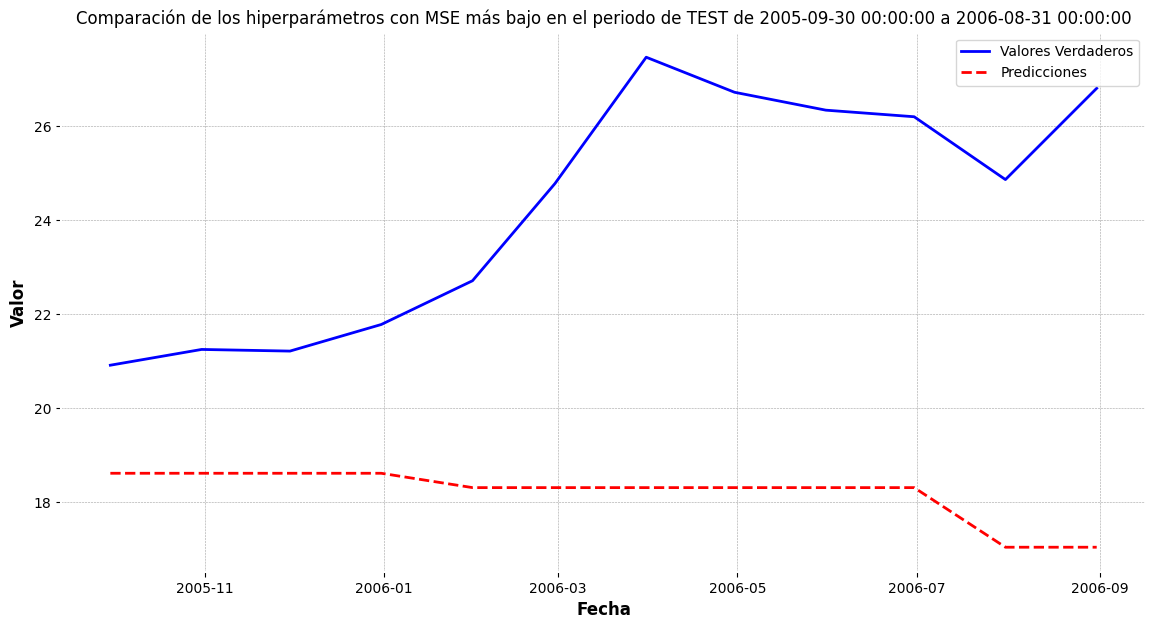

**************************************************
Índice: 155
Fecha de inicio de TEST: 2006-09-30 00:00:00
Fecha de finalización de TEST: 2007-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 146.6417878375174
Hiperparámetros: {'learning_rate': 0.08225614224702102, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7271161056133516}


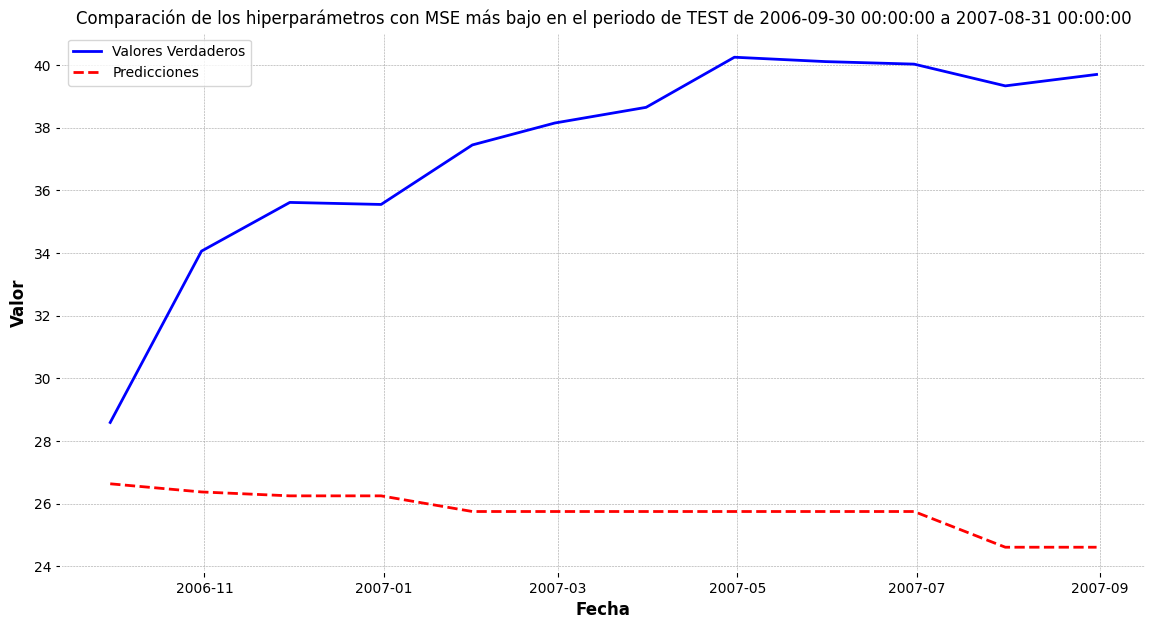

**************************************************
Índice: 267
Fecha de inicio de TEST: 2007-09-30 00:00:00
Fecha de finalización de TEST: 2008-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 7.826760801832346
Hiperparámetros: {'learning_rate': 0.19140651720691315, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7546857856809531}


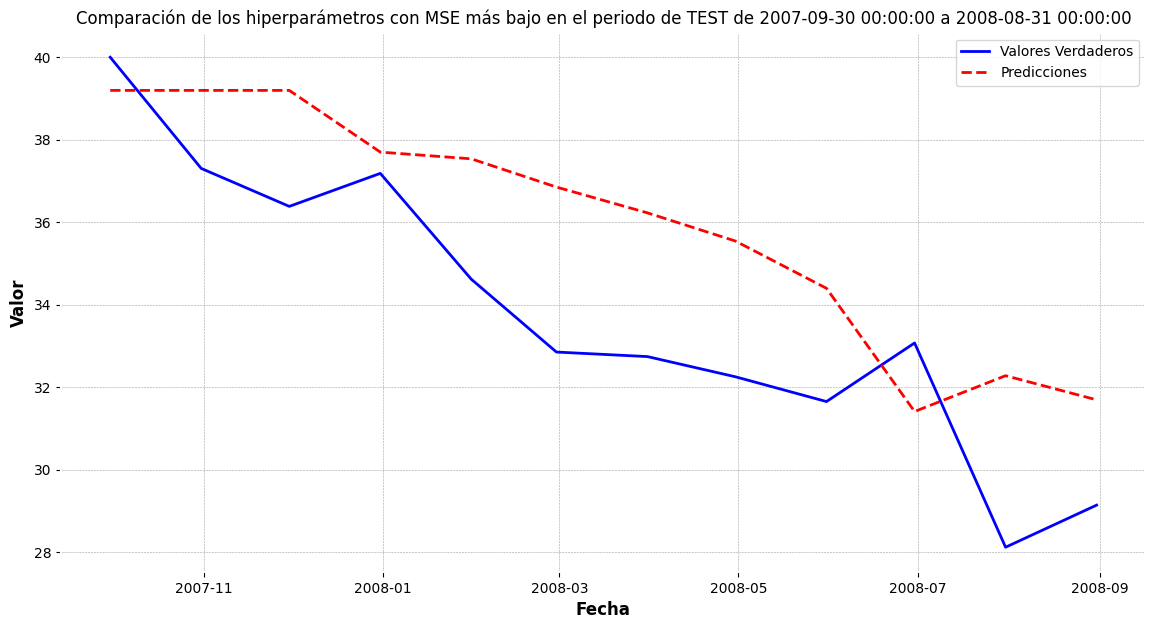

**************************************************
Índice: 332
Fecha de inicio de TEST: 2008-09-30 00:00:00
Fecha de finalización de TEST: 2009-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 10.04018208815658
Hiperparámetros: {'learning_rate': 0.10039167499119235, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7006391828973145}


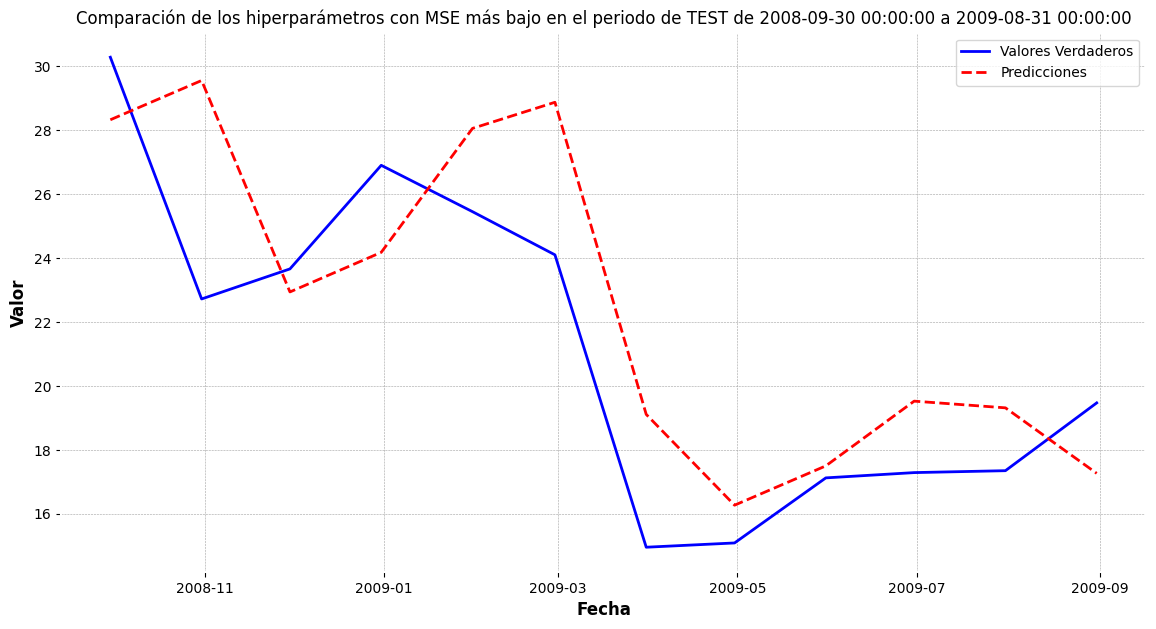

**************************************************
Índice: 448
Fecha de inicio de TEST: 2009-09-30 00:00:00
Fecha de finalización de TEST: 2010-08-31 00:00:00
Lags utilizados: 10
MSE más bajo: 0.7720105784011609
Hiperparámetros: {'learning_rate': 0.19140651720691315, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7546857856809531}


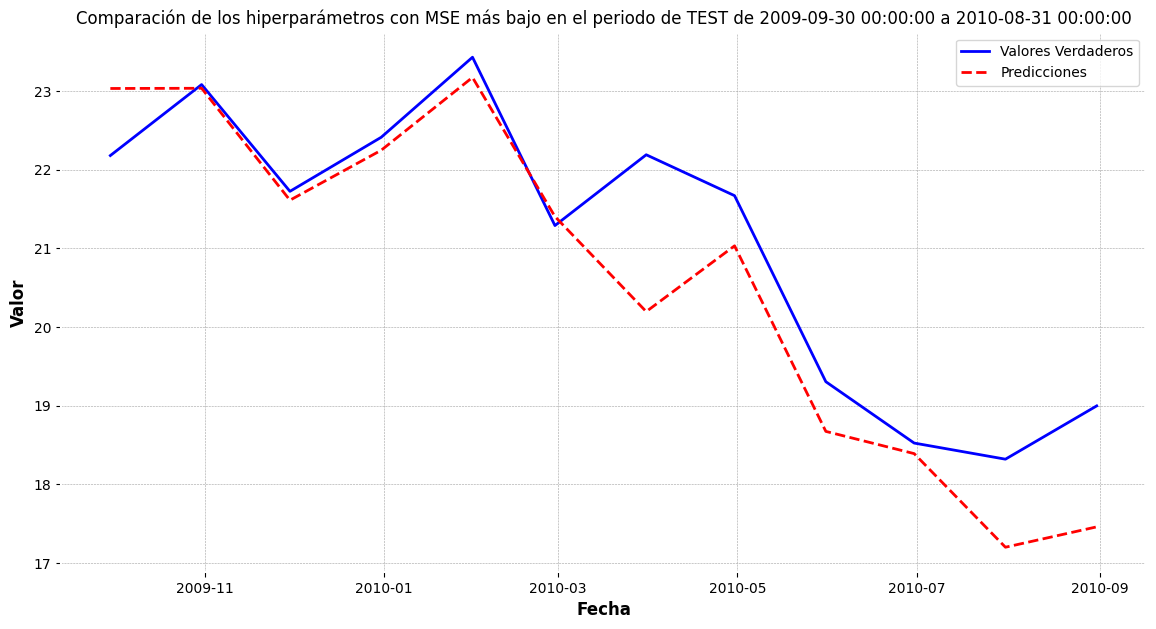

**************************************************
Índice: 477
Fecha de inicio de TEST: 2010-09-30 00:00:00
Fecha de finalización de TEST: 2011-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 1.8939219448527334
Hiperparámetros: {'learning_rate': 0.09743498396263106, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.9119665047902361}


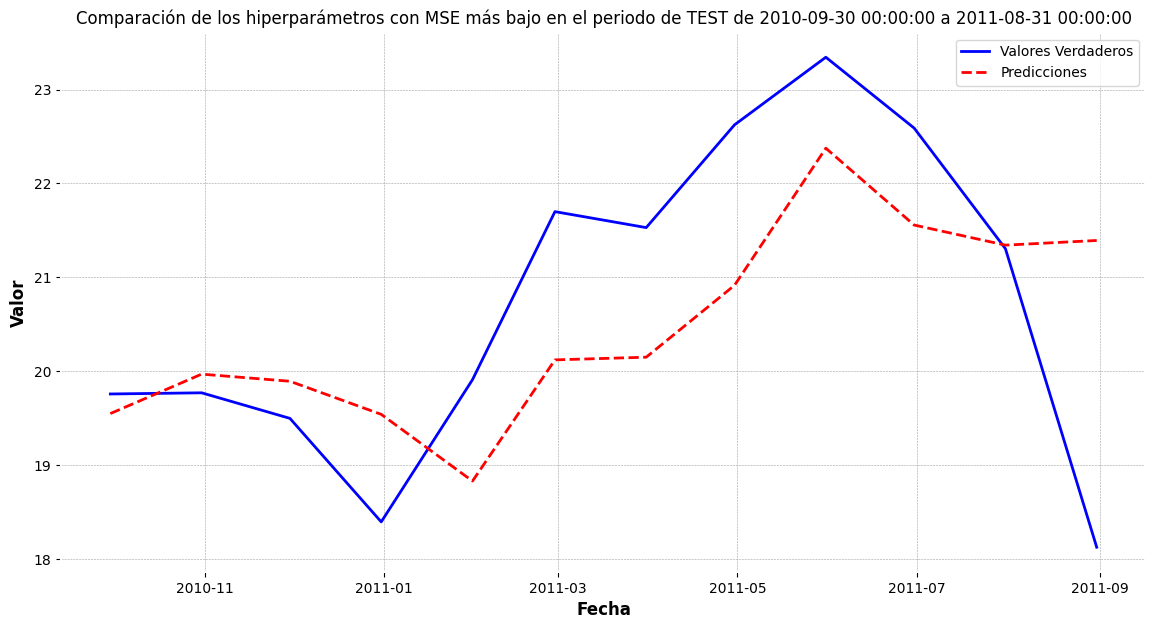

**************************************************
Índice: 612
Fecha de inicio de TEST: 2011-09-30 00:00:00
Fecha de finalización de TEST: 2012-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 1.6943051798871736
Hiperparámetros: {'learning_rate': 0.19137962279321052, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.9628313506952073}


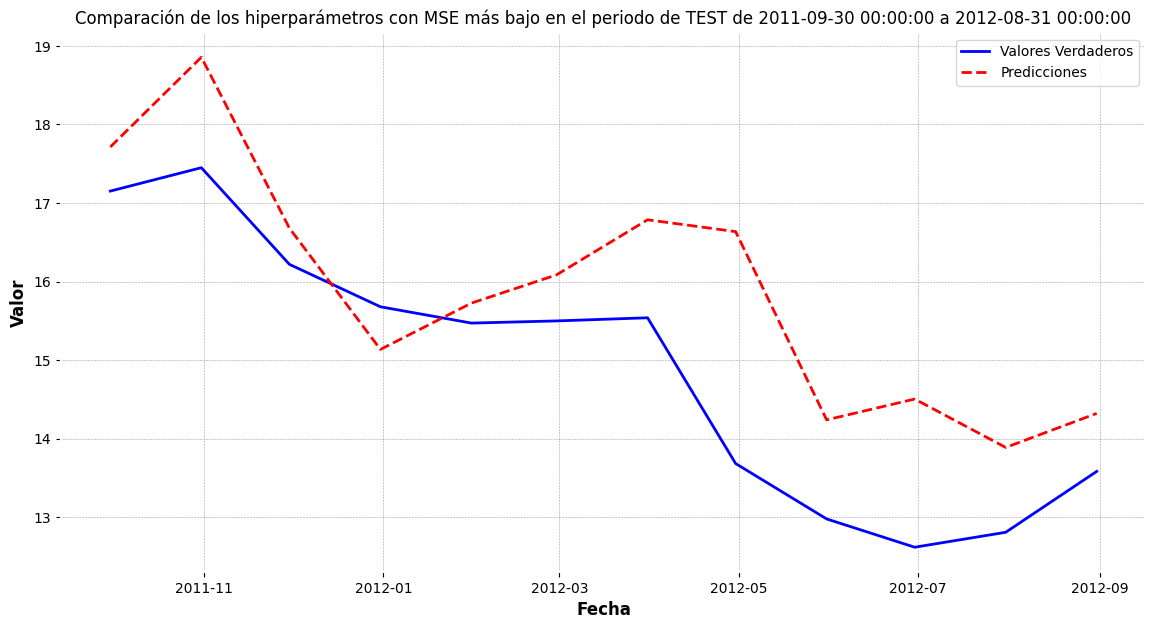

**************************************************
Índice: 689
Fecha de inicio de TEST: 2012-09-30 00:00:00
Fecha de finalización de TEST: 2013-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 0.8369422915680124
Hiperparámetros: {'learning_rate': 0.1987621188937611, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.978238213533159}


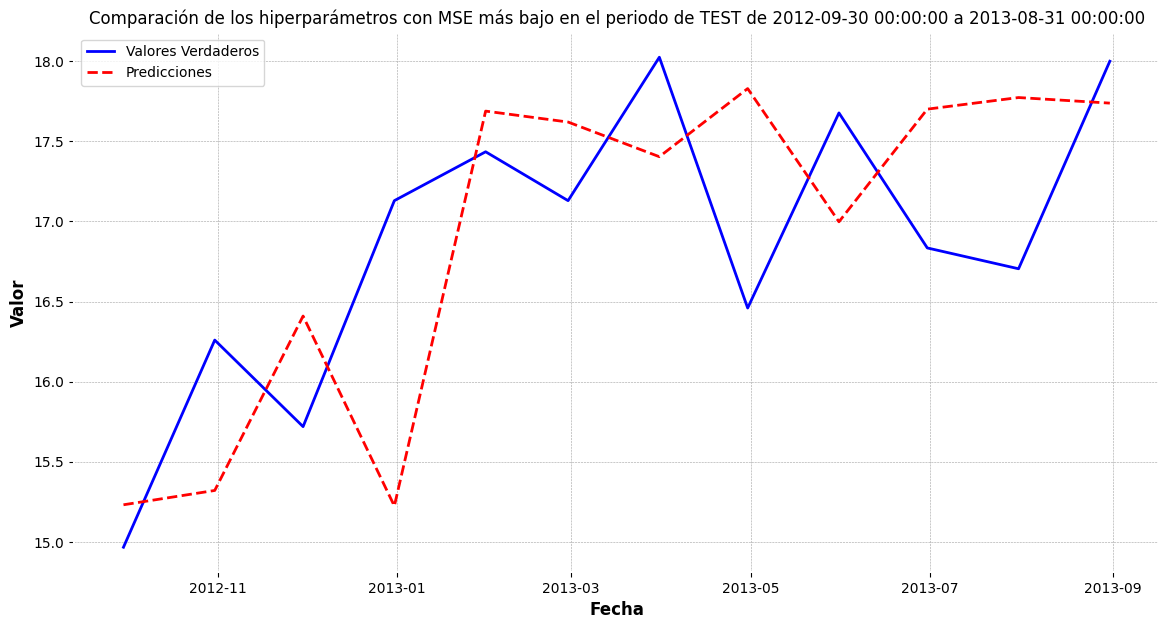

**************************************************
Índice: 750
Fecha de inicio de TEST: 2013-09-30 00:00:00
Fecha de finalización de TEST: 2014-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 40.697707171519276
Hiperparámetros: {'learning_rate': 0.1866777753021937, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.6265687369986416}


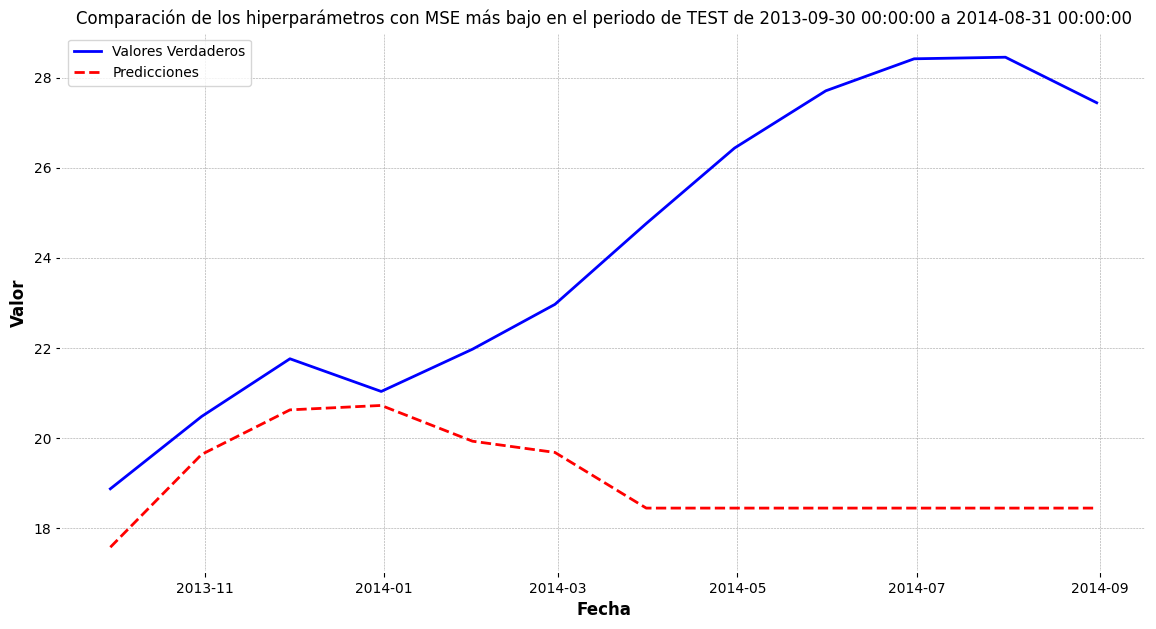

**************************************************
Índice: 879
Fecha de inicio de TEST: 2014-09-30 00:00:00
Fecha de finalización de TEST: 2015-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 10.673589544321088
Hiperparámetros: {'learning_rate': 0.08363549996324043, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.6221501044008744}


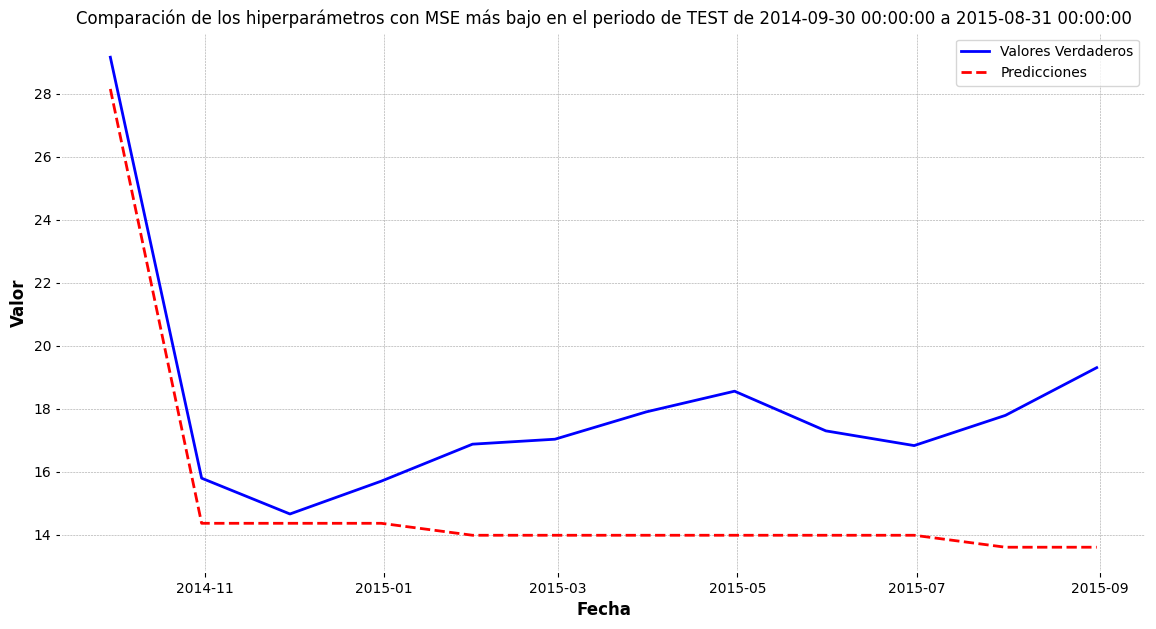

**************************************************
Índice: 977
Fecha de inicio de TEST: 2015-09-30 00:00:00
Fecha de finalización de TEST: 2016-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 0.8499104353394915
Hiperparámetros: {'learning_rate': 0.10235330968403245, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8432514768712326}


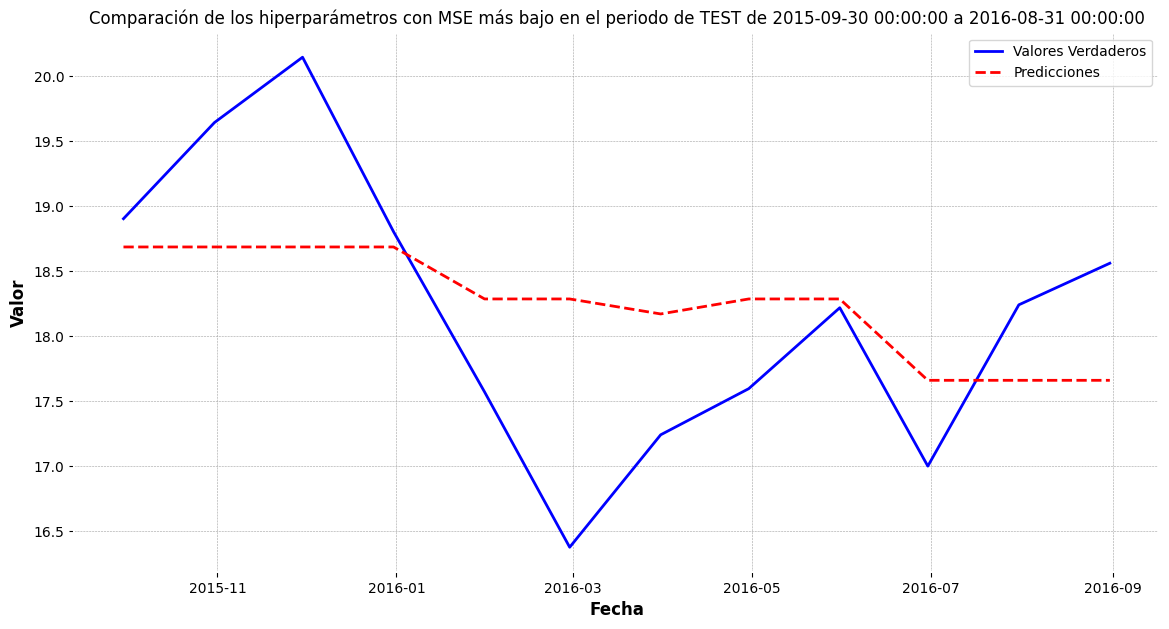

**************************************************
Índice: 1034
Fecha de inicio de TEST: 2016-09-30 00:00:00
Fecha de finalización de TEST: 2017-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 12.057906428028403
Hiperparámetros: {'learning_rate': 0.1719786002406973, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.7653401807055831}


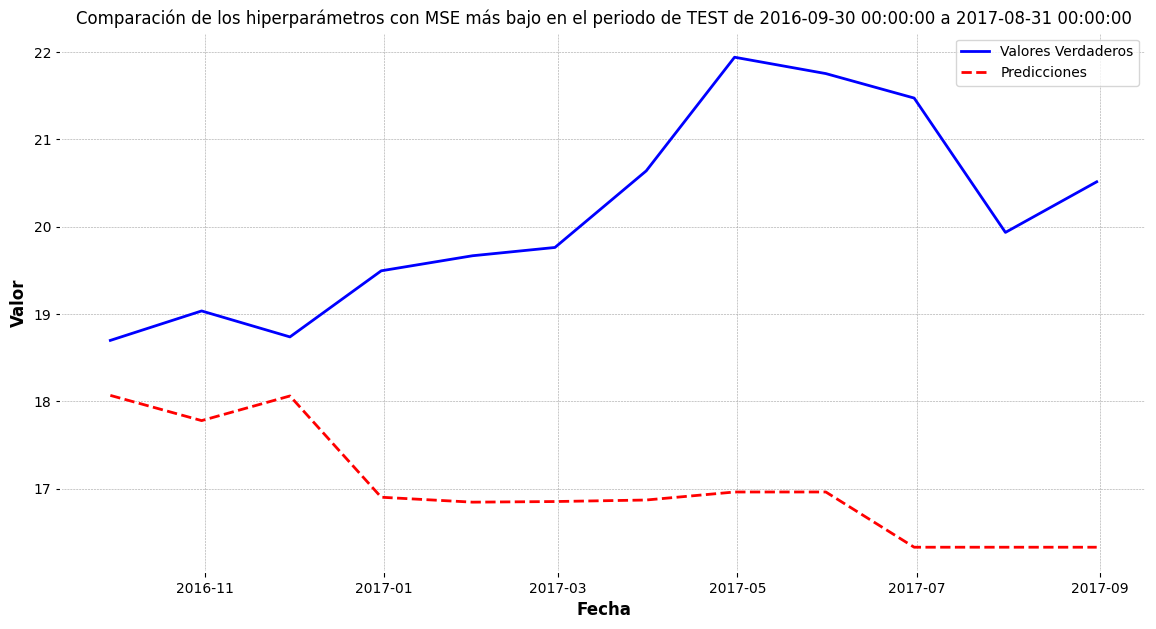

**************************************************
Índice: 1103
Fecha de inicio de TEST: 2017-09-30 00:00:00
Fecha de finalización de TEST: 2018-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 0.5481289900799682
Hiperparámetros: {'learning_rate': 0.06947608221473132, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8781229252715306}


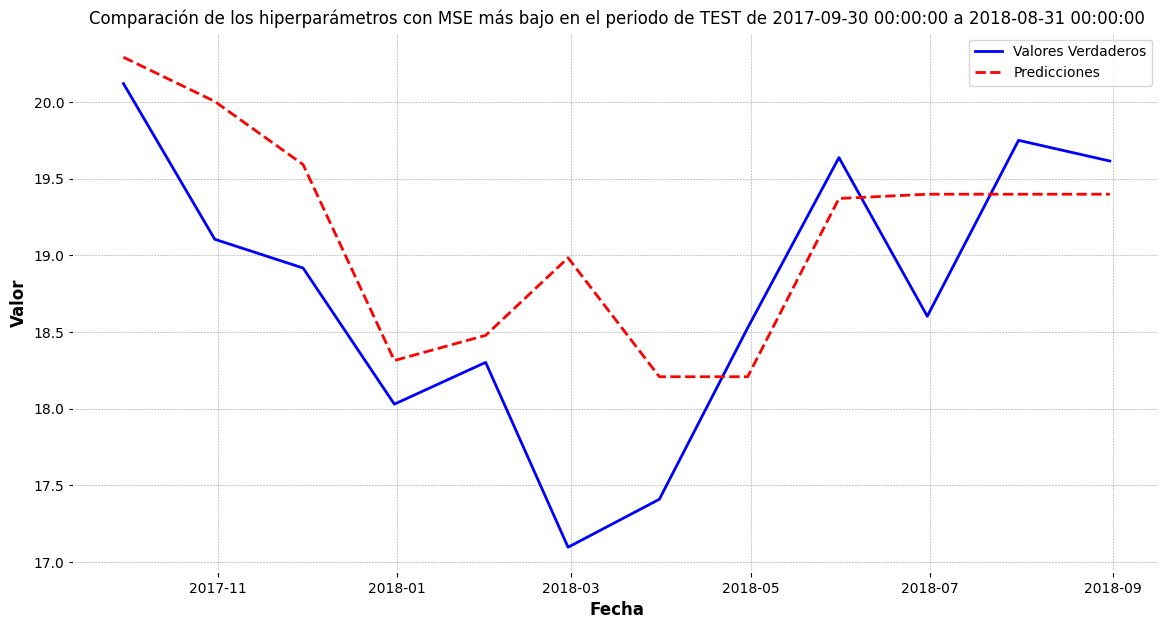

**************************************************
Índice: 1256
Fecha de inicio de TEST: 2018-09-30 00:00:00
Fecha de finalización de TEST: 2019-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 10.704111038298315
Hiperparámetros: {'learning_rate': 0.19325075279317233, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8655163130693553}


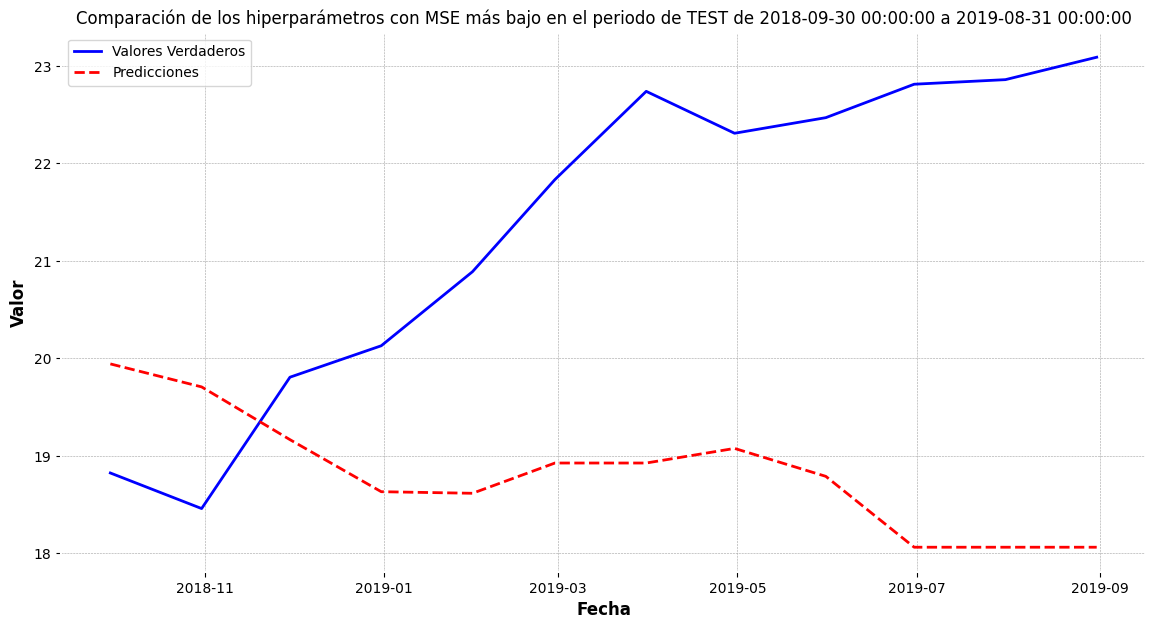

**************************************************
Índice: 1312
Fecha de inicio de TEST: 2019-09-30 00:00:00
Fecha de finalización de TEST: 2020-08-31 00:00:00
Lags utilizados: 10
MSE más bajo: 3.598898601644917
Hiperparámetros: {'learning_rate': 0.17371310095079479, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8893977943764468}


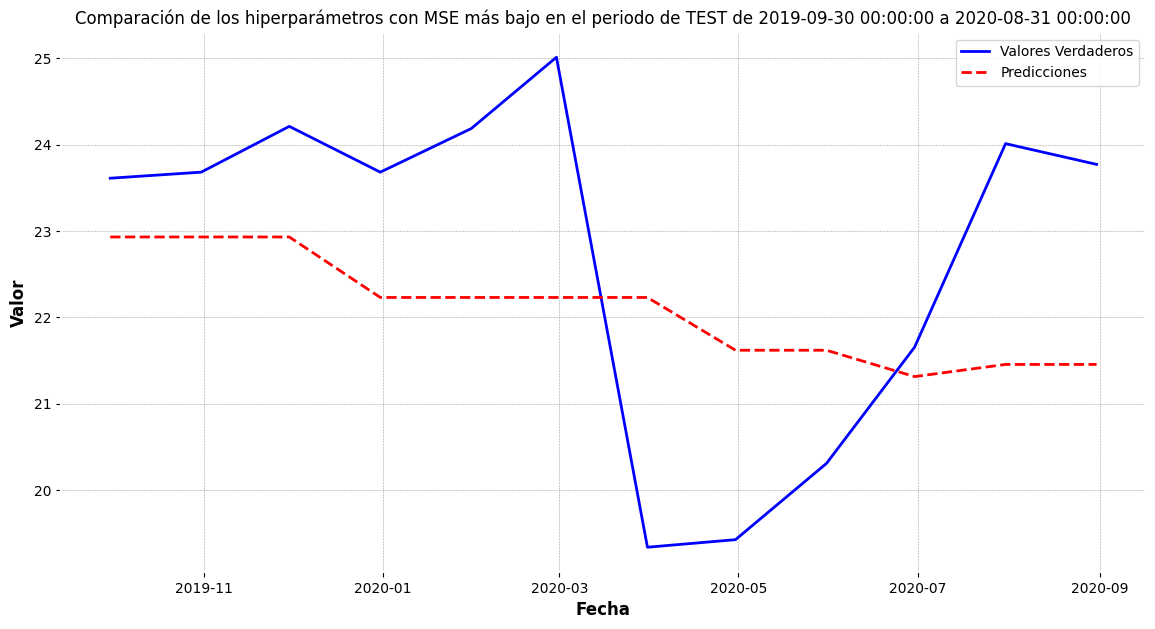

**************************************************
Índice: 1433
Fecha de inicio de TEST: 2020-09-30 00:00:00
Fecha de finalización de TEST: 2021-08-31 00:00:00
Lags utilizados: 20
MSE más bajo: 0.2149177969047591
Hiperparámetros: {'learning_rate': 0.10899057363797315, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.7007275899527052}


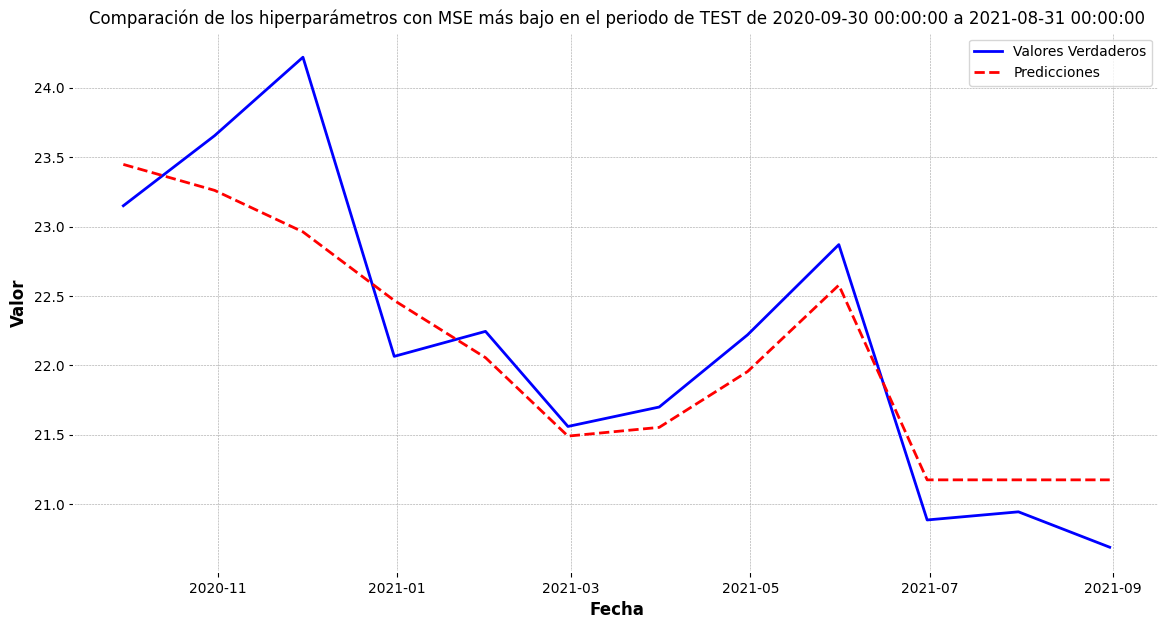

**************************************************
Índice: 1452
Fecha de inicio de TEST: 2021-09-30 00:00:00
Fecha de finalización de TEST: 2022-08-31 00:00:00
Lags utilizados: 5
MSE más bajo: 0.7540667609647408
Hiperparámetros: {'learning_rate': 0.1985601852649278, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.6502201199602563}


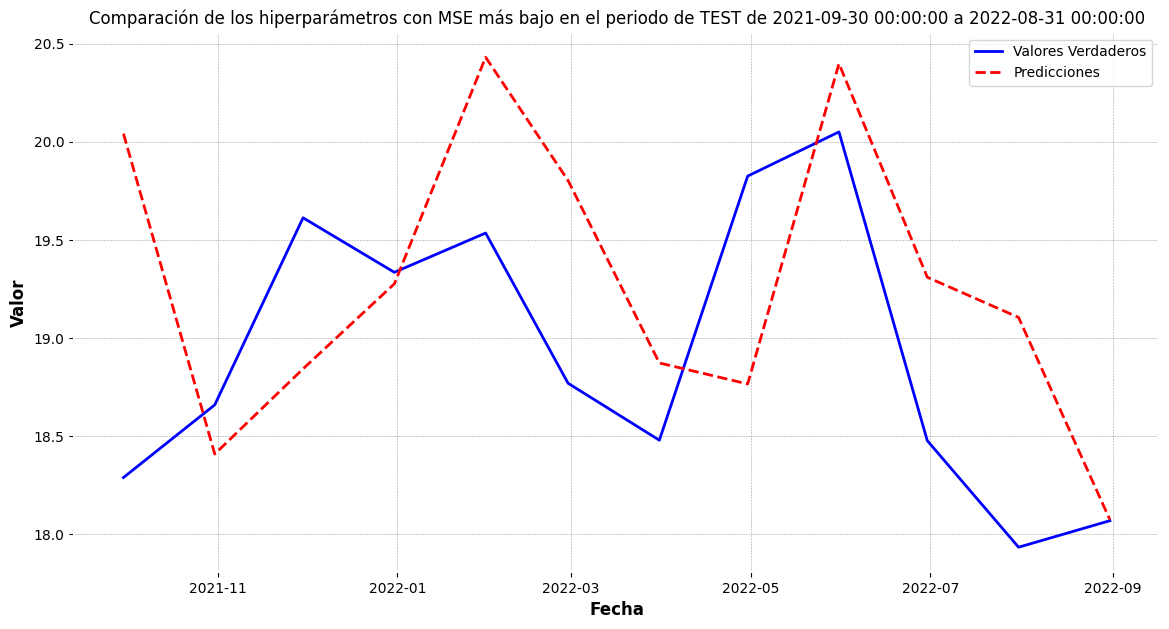

**************************************************


In [30]:
resultados_mse_minimos = resultados_xgb.loc[resultados_xgb.groupby(['start_test_date', 'end_test_date'])
                                            ['mse'].idxmin()]

resultados_mse_minimos_sorted = resultados_mse_minimos.sort_values(by='start_test_date')

for index, row in resultados_mse_minimos_sorted.iterrows():
    print(f"Índice: {index}")
    print(f"Fecha de inicio de TEST: {row['start_test_date']}")
    print(f"Fecha de finalización de TEST: {row['end_test_date']}")
    print(f"Lags utilizados: {row['lags']}")
    print(f"MSE más bajo: {row['mse']}")
    print(f"Hiperparámetros: {row['hyper']}")
    
    dates = pd.date_range(start=row['start_test_date'], end=row['end_test_date'], freq='M')
    
    lista_dividendos = dividendos_acumulados.reindex(dates, fill_value=0)
    
    row_real = row['real'] - lista_dividendos.values
    row_preds = row['preds'] - lista_dividendos.values
    
    plt.figure(figsize=(14, 7)) 
    plt.plot(dates, row_real, label='Valores Verdaderos', color='blue')
    plt.plot(dates, row_preds, label='Predicciones', color='red', linestyle='--')

    plt.title(f"Comparación de los hiperparámetros con MSE más bajo en el periodo de TEST de {row['start_test_date']} a {row['end_test_date']}")
    plt.xlabel('Fecha')
    plt.ylabel('Valor')

    plt.legend()

    plt.grid(True)

    plt.show()

    print("*"*50)

Analizamos los hiperparámetros que han tenido buenos resultados en los modelos anteriores, más en concreto en aquellos con MSE inferior a 3.

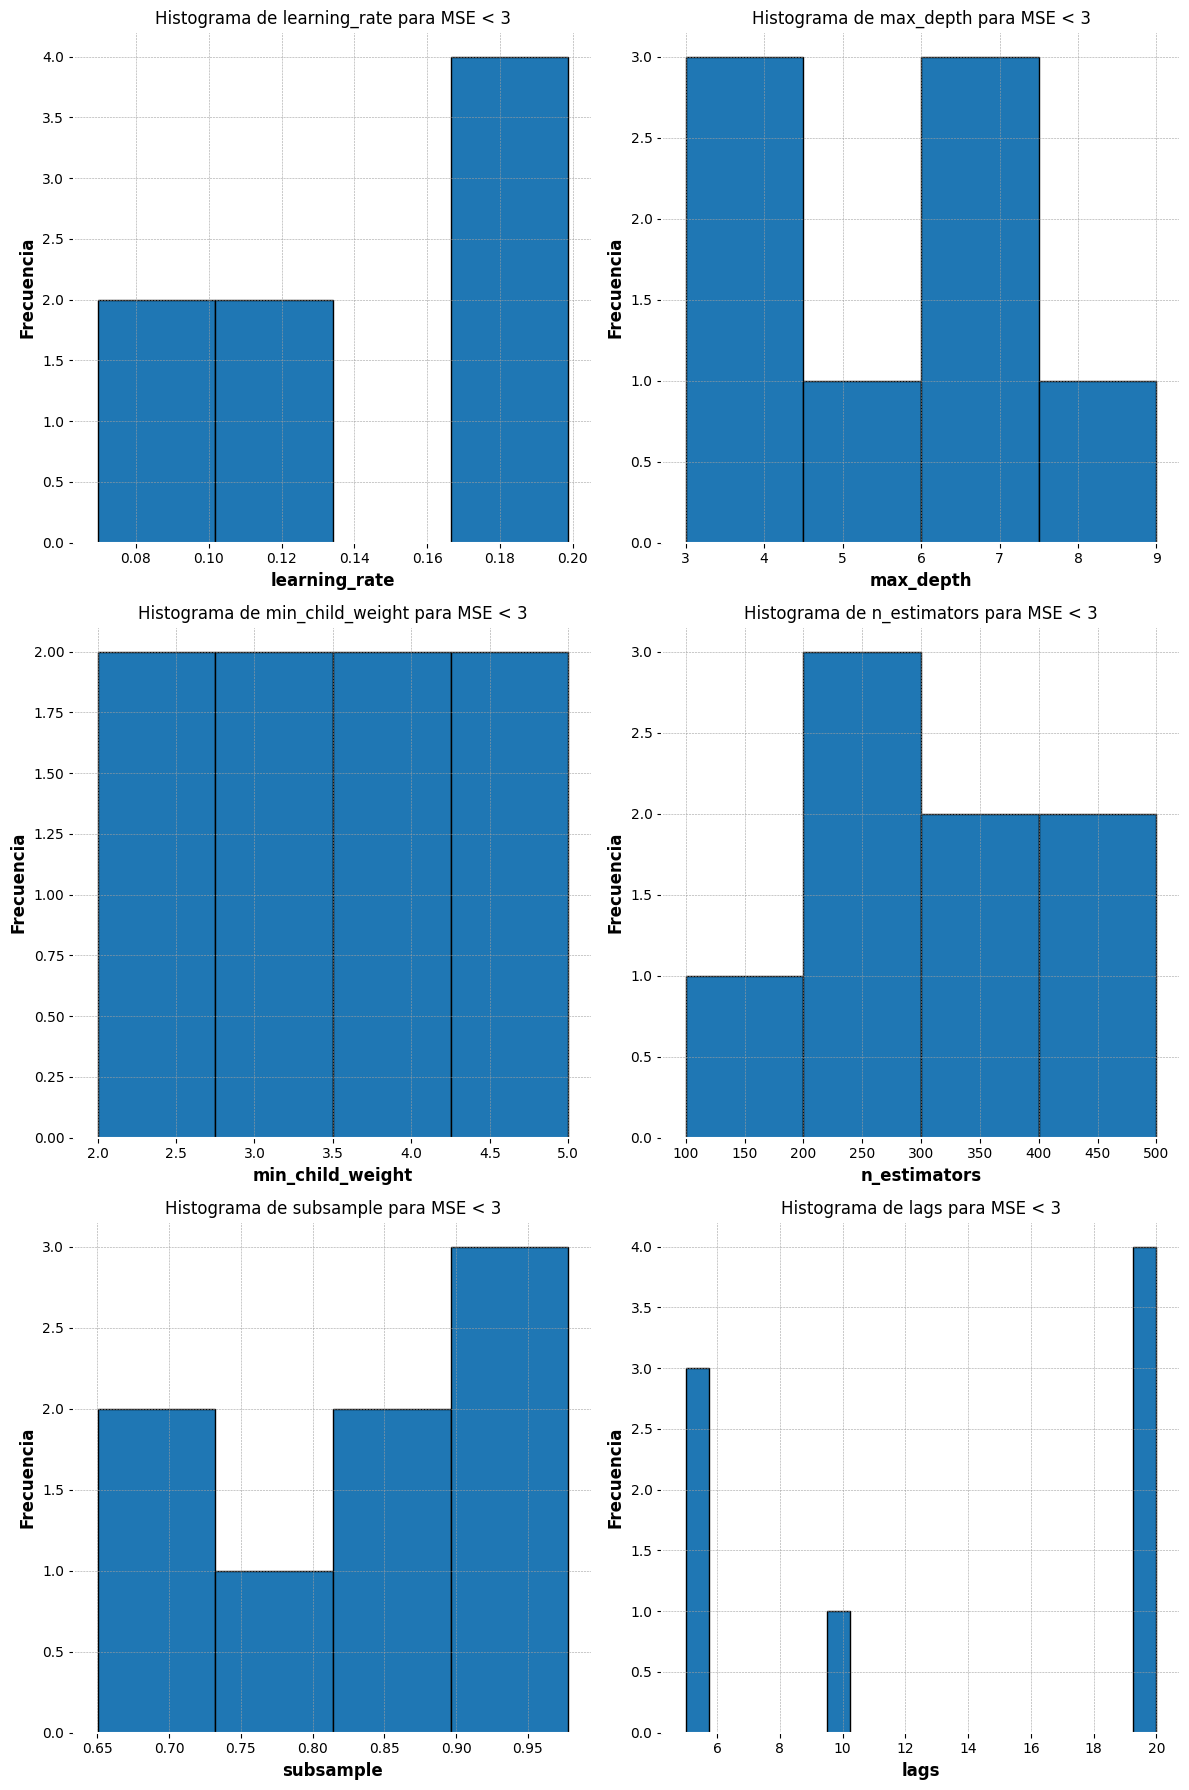

In [31]:
learning_rates = resultados_mse_minimos_sorted[resultados_mse_minimos_sorted['mse'] < 3]['hyper'].apply(lambda x: x['learning_rate'])
max_depth = resultados_mse_minimos_sorted[resultados_mse_minimos_sorted['mse'] < 3]['hyper'].apply(lambda x: x['max_depth'])
min_child_weight = resultados_mse_minimos_sorted[resultados_mse_minimos_sorted['mse'] < 3]['hyper'].apply(lambda x: x['min_child_weight'])
n_estimators = resultados_mse_minimos_sorted[resultados_mse_minimos_sorted['mse'] < 3]['hyper'].apply(lambda x: x['n_estimators'])
subsample = resultados_mse_minimos_sorted[resultados_mse_minimos_sorted['mse'] < 3]['hyper'].apply(lambda x: x['subsample'])
lags = resultados_mse_minimos_sorted[resultados_mse_minimos_sorted['mse'] < 3]['lags']

plt.figure(figsize=(12, 18))

# Histograma de learning_rate
plt.subplot(3, 2, 1)  
learning_rates.hist(bins=4, edgecolor='black')
plt.xlabel('learning_rate')
plt.ylabel('Frecuencia')
plt.title('Histograma de learning_rate para MSE < 3')
plt.grid(True)

# Histograma de max_depth
plt.subplot(3, 2, 2)  
max_depth.hist(bins=4, edgecolor='black')
plt.xlabel('max_depth')
plt.ylabel('Frecuencia')
plt.title('Histograma de max_depth para MSE < 3')
plt.grid(True)

# Histograma de min_child_weight
plt.subplot(3, 2, 3)  
min_child_weight.hist(bins=4, edgecolor='black')
plt.xlabel('min_child_weight')
plt.ylabel('Frecuencia')
plt.title('Histograma de min_child_weight para MSE < 3')
plt.grid(True)

# Histograma de n_estimators
plt.subplot(3, 2, 4)  
n_estimators.hist(bins=4, edgecolor='black')
plt.xlabel('n_estimators')
plt.ylabel('Frecuencia')
plt.title('Histograma de n_estimators para MSE < 3')
plt.grid(True)

# Histograma de subsample
plt.subplot(3, 2, 5)  
subsample.hist(bins=4, edgecolor='black')
plt.xlabel('subsample')
plt.ylabel('Frecuencia')
plt.title('Histograma de subsample para MSE < 3')
plt.grid(True)

# Histograma de lags
plt.subplot(3, 2, 6)  
lags.hist(bins=20, edgecolor='black')
plt.xlabel('lags')
plt.ylabel('Frecuencia')
plt.title('Histograma de lags para MSE < 3')
plt.grid(True)

plt.tight_layout()

plt.show()

## XGBoost Regressor con Cross Validation e hiperparametrización y noticias evaludadas por ChatGPT

In [32]:
num_lags = 20
for lag in range(1, num_lags + 1):
    cotizacion_mensual[f'lag_{lag}'] = cotizacion_mensual['Close'].shift(lag)

cotizacion_mensual = cotizacion_mensual.dropna()

In [33]:
cotizacion_mensual.head()

Close   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  \
Date                                                                         
2004-05-31  17.039  17.634  17.079  17.899  17.344  16.290  15.720  15.425   
2004-06-30  18.019  17.039  17.634  17.079  17.899  17.344  16.290  15.720   
2004-07-31  18.043  18.019  17.039  17.634  17.079  17.899  17.344  16.290   
2004-08-31  17.668  18.043  18.019  17.039  17.634  17.079  17.899  17.344   
2004-09-30  18.243  17.668  18.043  18.019  17.039  17.634  17.079  17.899   

             lag_8   lag_9  ...   lag_11   lag_12   lag_13   lag_14   lag_15  \
Date                        ...                                                
2004-05-31  15.985  16.185  ...  15.9165  14.8365  14.4615  12.6565  12.6765   
2004-06-30  15.425  15.985  ...  16.0650  15.9165  14.8365  14.4615  12.6565   
2004-07-31  15.720  15.425  ...  16.1850  16.0650  15.9165  14.8365  14.4615   
2004-08-31  16.290  15.720  ...  15.9850  16.1850  16.0650  15.9165  14.8365   
2004-09-30  17.344  16.290  ...  15.4250  15.9850  16.1850  16.0650  15.9165   

             lag_16   lag_17   lag_18   lag_19   lag_20  
Date                                                     
2004-05-31  12.9665  12.5125  12.5775  11.3825  12.5325  
2004-06-30  12.6765  12.9665  12.5125  12.5775  11.3825  
2004-07-31  12.6565  12.6765  12.9665  12.5125  12.5775  
2004-08-31  14.4615  12.6565  12.6765  12.9665  12.5125  
2004-09-30  14.8365  14.4615  12.6565  12.6765  12.9665  

[5 rows x 21 columns]

### En este punto, ingestamos el fichero gpt.csv, generado en el Notebook a parte, y que convierte el fichero NOTICIAS.XLSX en un conjunto de ficheros .txt (.json) con la siguiente estructura: 
{  "empresa": "Sector Energético",
  "tipo": "Negocios y Finanzas Corporativas",
  "sentido": 0.8 }
  
Siendo empresa una de las siguientes: 'Sector Energético', 'Iberdrola', 'Endesa', 'Naturgy', 'Abengoa'.
Tipo: Negocios y Finanzas Corporativas, Regulación y Asuntos Legales, Desarrollo de Infraestructura y Proyectos, Estrategia y Planificación Empresarial y Dividendos
Y Sentido, un valor comprendido entre -1 y 1 dependiendo del sentido negativo o positivo de la noticia.

La Date es la fecha mergeada con el fichero original, NOTICIAS, donde se generó la información.

In [34]:
gpt = pd.read_csv('gpt.csv', index_col=0)
gpt

empresa                                       tipo  sentido  \
0     Sector Energético               Regulación y Asuntos Legales      0.7   
1                Endesa               Regulación y Asuntos Legales     -0.5   
2             Iberdrola  Desarrollo de Infraestructura y Proyectos      1.0   
3                Endesa           Negocios y Finanzas Corporativas     -0.5   
4             Iberdrola           Negocios y Finanzas Corporativas     -1.0   
...                 ...                                        ...      ...   
7412          Iberdrola  Desarrollo de Infraestructura y Proyectos      0.8   
7413  Sector Energético               Regulación y Asuntos Legales     -1.0   
7414  Sector Energético           Negocios y Finanzas Corporativas      0.8   
7415  Sector Energético               Regulación y Asuntos Legales     -0.8   
7416  Sector Energético               Regulación y Asuntos Legales      0.8   

      prefijo                 Date  
0        2162  2008-04-11 00:00:00  
1        1930  2007-10-23 00:00:00  
2        2025  2008-02-05 00:00:00  
3        1972  2007-12-17 00:00:00  
4        3669  2011-07-29 07:00:00  
...       ...                  ...  
7412     6699  2021-05-19 10:58:52  
7413     1149  2006-04-04 11:11:00  
7414     2725  2009-04-08 00:00:00  
7415     3495  2010-12-11 07:00:00  
7416     6203  2020-04-23 08:09:04  

[7417 rows x 5 columns]

Como podemos observar, hay varias fechas en las que las noticias aparecen en diferentes ocasiones.
En primer lugar, aplicaremos un OneHotEncoder sobre las columnas 'empresa' y 'tipo'. 

In [35]:
gpt['Date'].value_counts()

2007-03-29 00:00:00    9
2006-02-25 00:00:00    8
2005-11-24 00:00:00    6
2005-11-15 00:00:00    6
2005-09-07 00:00:00    6
                      ..
2008-02-28 16:41:00    1
2007-03-29 13:38:00    1
2007-06-14 00:00:00    1
2021-04-14 13:48:01    1
2020-04-23 08:09:04    1
Name: Date, Length: 6540, dtype: int64

In [36]:
encoder = OneHotEncoder(sparse_output=False)

encoded_cols = encoder.fit_transform(gpt[['empresa', 'tipo']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['empresa', 'tipo']))
gpt.reset_index(drop=True, inplace=True)
gpt_encoded = pd.concat([gpt[['Date', 'sentido']], encoded_df], axis=1)
gpt_encoded

Date  sentido  empresa_Abengoa  empresa_Endesa  \
0     2008-04-11 00:00:00      0.7              0.0             0.0   
1     2007-10-23 00:00:00     -0.5              0.0             1.0   
2     2008-02-05 00:00:00      1.0              0.0             0.0   
3     2007-12-17 00:00:00     -0.5              0.0             1.0   
4     2011-07-29 07:00:00     -1.0              0.0             0.0   
...                   ...      ...              ...             ...   
7412  2021-05-19 10:58:52      0.8              0.0             0.0   
7413  2006-04-04 11:11:00     -1.0              0.0             0.0   
7414  2009-04-08 00:00:00      0.8              0.0             0.0   
7415  2010-12-11 07:00:00     -0.8              0.0             0.0   
7416  2020-04-23 08:09:04      0.8              0.0             0.0   

      empresa_Iberdrola  empresa_Naturgy  empresa_Sector Energético  \
0                   0.0              0.0                        1.0   
1                   0.0              0.0                        0.0   
2                   1.0              0.0                        0.0   
3                   0.0              0.0                        0.0   
4                   1.0              0.0                        0.0   
...                 ...              ...                        ...   
7412                1.0              0.0                        0.0   
7413                0.0              0.0                        1.0   
7414                0.0              0.0                        1.0   
7415                0.0              0.0                        1.0   
7416                0.0              0.0                        1.0   

      tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
0                                                0.0              0.0   
1                                                0.0              0.0   
2                                                1.0              0.0   
3                                                0.0              0.0   
4                                                0.0              0.0   
...                                              ...              ...   
7412                                             1.0              0.0   
7413                                             0.0              0.0   
7414                                             0.0              0.0   
7415                                             0.0              0.0   
7416                                             0.0              0.0   

      tipo_Estrategia y Planificación Empresarial  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
...                                           ...   
7412                                          0.0   
7413                                          0.0   
7414                                          0.0   
7415                                          0.0   
7416                                          0.0   

      tipo_Negocios y Finanzas Corporativas  tipo_Regulación y Asuntos Legales  
0                                       0.0                                1.0  
1                                       0.0                                1.0  
2                                       0.0                                0.0  
3                                       1.0                                0.0  
4                                       1.0                                0.0  
...                                     ...                                ...  
7412                                    0.0                                0.0  
7413                                    0.0                                1.0  
7414                                    1.0                             

In [37]:
gpt_encoded['Date'] = pd.to_datetime(gpt_encoded['Date'])
gpt_encoded['Date'] = gpt_encoded['Date'].dt.date
gpt_encoded_grouped = gpt_encoded.groupby('Date').sum()

## Tras esto, únicamente hay un registro para cada día, que acumula toda la información del dataframe original.

In [38]:
gpt_encoded_grouped.head()

sentido  empresa_Abengoa  empresa_Endesa  empresa_Iberdrola  \
Date                                                                      
2002-10-26   -0.500              0.0             0.0                1.0   
2002-10-29    1.500              0.0             2.0                0.0   
2002-10-30   -0.878              0.0             1.0                0.0   
2002-11-07    2.400              0.0             1.0                0.0   
2002-11-08    1.800              0.0             0.0                0.0   

            empresa_Naturgy  empresa_Sector Energético  \
Date                                                     
2002-10-26              0.0                        0.0   
2002-10-29              0.0                        0.0   
2002-10-30              0.0                        1.0   
2002-11-07              0.0                        2.0   
2002-11-08              1.0                        1.0   

            tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
Date                                                                          
2002-10-26                                             0.0              0.0   
2002-10-29                                             0.0              0.0   
2002-10-30                                             0.0              0.0   
2002-11-07                                             0.0              0.0   
2002-11-08                                             0.0              0.0   

            tipo_Estrategia y Planificación Empresarial  \
Date                                                      
2002-10-26                                          0.0   
2002-10-29                                          1.0   
2002-10-30                                          1.0   
2002-11-07                                          0.0   
2002-11-08                                          0.0   

            tipo_Negocios y Finanzas Corporativas  \
Date                                                
2002-10-26                                    0.0   
2002-10-29                                    1.0   
2002-10-30                                    1.0   
2002-11-07                                    3.0   
2002-11-08                                    1.0   

            tipo_Regulación y Asuntos Legales  
Date                                           
2002-10-26                                1.0  
2002-10-29                                0.0  
2002-10-30                                0.0  
2002-11-07                                0.0  
2002-11-08                                1.0

In [39]:
gpt_encoded_grouped.index.value_counts()

2002-10-26    1
2016-11-14    1
2016-10-25    1
2016-10-26    1
2016-10-28    1
             ..
2009-02-17    1
2009-02-18    1
2009-02-19    1
2009-02-20    1
2023-11-24    1
Name: Date, Length: 4082, dtype: int64

 ### Unimos ambos dataframes

In [40]:
cotizacion_gpt = cotizacion_mensual.merge(gpt_encoded_grouped, left_index=True, right_index=True, how='left')
cotizacion_gpt.fillna(0, inplace=True)
cotizacion_gpt

Close      lag_1      lag_2      lag_3     lag_4     lag_5  \
Date                                                                         
2004-05-31  17.039000  17.634000  17.079000  17.899000  17.34400  16.29000   
2004-06-30  18.019000  17.039000  17.634000  17.079000  17.89900  17.34400   
2004-07-31  18.043000  18.019000  17.039000  17.634000  17.07900  17.89900   
2004-08-31  17.668000  18.043000  18.019000  17.039000  17.63400  17.07900   
2004-09-30  18.243000  17.668000  18.043000  18.019000  17.03900  17.63400   
...               ...        ...        ...        ...       ...       ...   
2023-02-28  61.410660  61.328160  60.620660  60.715660  58.16566  60.16816   
2023-03-31  61.830659  61.410660  61.328160  60.620660  60.71566  58.16566   
2023-04-30  62.888160  61.830659  61.410660  61.328160  60.62066  60.71566   
2023-05-31  62.898161  62.888160  61.830659  61.410660  61.32816  60.62066   
2023-06-30  63.625660  62.898161  62.888160  61.830659  61.41066  61.32816   

               lag_6      lag_7      lag_8      lag_9  ...  empresa_Abengoa  \
Date                                                   ...                    
2004-05-31  15.72000  15.425000  15.985000  16.185000  ...              0.0   
2004-06-30  16.29000  15.720000  15.425000  15.985000  ...              0.0   
2004-07-31  17.34400  16.290000  15.720000  15.425000  ...              0.0   
2004-08-31  17.89900  17.344000  16.290000  15.720000  ...              0.0   
2004-09-30  17.07900  17.899000  17.344000  16.290000  ...              0.0   
...              ...        ...        ...        ...  ...              ...   
2023-02-28  60.96566  60.830659  61.373460  62.008460  ...              0.0   
2023-03-31  60.16816  60.965660  60.830659  61.373460  ...              0.0   
2023-04-30  58.16566  60.168160  60.965660  60.830659  ...              0.0   
2023-05-31  60.71566  58.165660  60.168160  60.965660  ...              0.0   
2023-06-30  60.62066  60.715660  58.165660  60.168160  ...              0.0   

            empresa_Endesa  empresa_Iberdrola  empresa_Naturgy  \
Date                                                             
2004-05-31             0.0                0.0              0.0   
2004-06-30             1.0                0.0              0.0   
2004-07-31             0.0                0.0              0.0   
2004-08-31             0.0                0.0              0.0   
2004-09-30             0.0                0.0              0.0   
...                    ...                ...              ...   
2023-02-28             0.0                0.0              0.0   
2023-03-31             0.0                0.0              0.0   
2023-04-30             0.0                0.0              0.0   
2023-05-31             0.0                0.0              0.0   
2023-06-30             0.0                0.0              0.0   

            empresa_Sector Energético  \
Date                                    
2004-05-31                        2.0   
2004-06-30                        1.0   
2004-07-31                        0.0   
2004-08-31                        0.0   
2004-09-30                        0.0   
...                               ...   
2023-02-28                        0.0   
2023-03-31                        0.0   
2023-04-30                        0.0   
2023-05-31                        0.0   
2023-06-30                        0.0   

            tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
Date                                                                          
2004-05-31                                             1.0              0.0   
2004-06-30                                             1.0              0.0   
2004-07-31                                             0.0              0.0   
2004-08-31                                             0.0              0.0   
2004-09-30                                             0.0              0.0   
...                        

## Repetimos la metodología de predicción anterior, mediante XGBoost e hiperparametrización pero con datos enriquecidos por ChatGPT.

In [41]:
#tscv = TimeSeriesSplit(n_splits=5) # No personaliza suficientemente los cortes

def custom_time_series_split(df, train_months, test_months):
    ventanas = []
    
    total_months = train_months + test_months
    
    n_splits = int((len(df) - train_months) / test_months)
    
    for split in range(n_splits):
        start_train = split * test_months
        end_train = start_train + train_months
        
        start_test = end_train
        end_test = start_test + test_months
        
        if end_test > len(df):
            end_test = len(df)
        
        ventanas.append((
            df.index[start_train],
            df.index[end_train - 1], 
            df.index[start_test],
            df.index[end_test - 1] ))
    
    return ventanas

train_months = 36
test_months = 12

ventanas = custom_time_series_split(cotizacion_gpt, train_months, test_months)

for i, ventana in enumerate(ventanas):
    print(f"Ventana {i}: {[timest.strftime('%Y-%m-%d') for timest in ventana]}")

Ventana 0: ['2004-05-31', '2007-04-30', '2007-05-31', '2008-04-30']
Ventana 1: ['2005-05-31', '2008-04-30', '2008-05-31', '2009-04-30']
Ventana 2: ['2006-05-31', '2009-04-30', '2009-05-31', '2010-04-30']
Ventana 3: ['2007-05-31', '2010-04-30', '2010-05-31', '2011-04-30']
Ventana 4: ['2008-05-31', '2011-04-30', '2011-05-31', '2012-04-30']
Ventana 5: ['2009-05-31', '2012-04-30', '2012-05-31', '2013-04-30']
Ventana 6: ['2010-05-31', '2013-04-30', '2013-05-31', '2014-04-30']
Ventana 7: ['2011-05-31', '2014-04-30', '2014-05-31', '2015-04-30']
Ventana 8: ['2012-05-31', '2015-04-30', '2015-05-31', '2016-04-30']
Ventana 9: ['2013-05-31', '2016-04-30', '2016-05-31', '2017-04-30']
Ventana 10: ['2014-05-31', '2017-04-30', '2017-05-31', '2018-04-30']
Ventana 11: ['2015-05-31', '2018-04-30', '2018-05-31', '2019-04-30']
Ventana 12: ['2016-05-31', '2019-04-30', '2019-05-31', '2020-04-30']
Ventana 13: ['2017-05-31', '2020-04-30', '2020-05-31', '2021-04-30']
Ventana 14: ['2018-05-31', '2021-04-30', '20

In [42]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 100),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2)
}

samples = [sample(space) for _ in range(30)]

for sample_ in samples:
    sample_['max_depth'] = int(sample_['max_depth'])
    sample_['min_child_weight'] = int(sample_['min_child_weight'])
    sample_['n_estimators'] = int(sample_['n_estimators'])

for i, params in enumerate(samples):
    print(f"Sample {i+1}: {params}")

Sample 1: {'learning_rate': 0.13539466313640403, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.9227006778970348}
Sample 2: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Sample 3: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Sample 4: {'learning_rate': 0.05932698714205117, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6870254705516132}
Sample 5: {'learning_rate': 0.16233182956977532, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.7145975110379919}
Sample 6: {'learning_rate': 0.18978115379676513, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7013802243030709}
Sample 7: {'learning_rate': 0.07996097609829443, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6331569470777237}
Sample 

In [43]:
lags = [5, 10, 20]

resultados_xgb_gpt = []
for start_train_date, end_train_date, start_test_date, end_test_date in ventanas:
    for hyper in samples:
        for lg in lags:
            print(f"Probamos con Train desde {start_train_date} hasta {end_train_date} y con Test desde {start_test_date} hasta {end_test_date}")
            print(f"Con {lg} lags.")
            print(f"Con los siguientes hiperparámetros: {hyper}")

            train = cotizacion_gpt[(cotizacion_gpt.index >= start_train_date) & (cotizacion_gpt.index <= end_train_date)]
            test = cotizacion_gpt[(cotizacion_gpt.index > end_train_date) & (cotizacion_gpt.index <= end_test_date)]

            X_train, y_train = train.drop('Close', axis=1), train['Close']
            X_test, y_test = test.drop('Close', axis=1), test['Close'].tolist()
            
            X_train = X_train.iloc[:, list(range(lg)) + list(range(20, 31))]
            X_test = X_test.iloc[:, list(range(lg)) + list(range(20, 31))]

            model = xgb.XGBRegressor(**hyper)
            model.fit(X_train, y_train)

            preds = model.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            print(f"Obteniendo un MSE de: {mse}")
            print("*"*50)

            iteracion = {
                'start_train_date': start_train_date, 
                'end_train_date': end_train_date, 
                'start_test_date': start_test_date, 
                'end_test_date': end_test_date,
                'lags': lg,
                'hyper': hyper,
                'real': y_test,
                'preds': preds,
                'mse': mse 
            }
            resultados_xgb_gpt.append(iteracion)

resultados_xgb_gpt = pd.DataFrame(resultados_xgb_gpt)

Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.13539466313640403, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.9227006778970348}
Obteniendo un MSE de: 8.12880110894931
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.13539466313640403, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.9227006778970348}
Obteniendo un MSE de: 7.856030976050424
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learn

Obteniendo un MSE de: 7.628063043144746
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09647981828596877, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6315140256438713}
Obteniendo un MSE de: 7.568721426540893
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09647981828596877, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6315140256438713}
Obteniendo un MSE de: 7.192246498889776
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-3

Obteniendo un MSE de: 10.217445418287584
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19779336287032617, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7284120706415728}
Obteniendo un MSE de: 8.675068401531279
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19779336287032617, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7284120706415728}
Obteniendo un MSE de: 7.998904434309639
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-

Obteniendo un MSE de: 5.601806416670674
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11935964523907905, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.8664863581265723}
Obteniendo un MSE de: 6.368801445332053
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11935964523907905, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.8664863581265723}
Obteniendo un MSE de: 6.503926854034812
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-3

Obteniendo un MSE de: 8.263481844802987
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09923702572172174, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 400, 'subsample': 0.9640226215169574}
Obteniendo un MSE de: 8.069148707854431
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-31 00:00:00 hasta 2008-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09923702572172174, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 400, 'subsample': 0.9640226215169574}
Obteniendo un MSE de: 7.927707684085317
**************************************************
Probamos con Train desde 2004-05-31 00:00:00 hasta 2007-04-30 00:00:00 y con Test desde 2007-05-3

Obteniendo un MSE de: 21.605600709831123
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07996097609829443, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6331569470777237}
Obteniendo un MSE de: 14.722757386849176
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.07996097609829443, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.6331569470777237}
Obteniendo un MSE de: 18.705178316890237
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05

Obteniendo un MSE de: 21.950033832883847
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10783679049980166, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400, 'subsample': 0.9366250853923946}
Obteniendo un MSE de: 22.33665906837513
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.19779336287032617, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7284120706415728}
Obteniendo un MSE de: 16.148391811396632
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-

Obteniendo un MSE de: 18.08355014460886
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11935964523907905, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.8664863581265723}
Obteniendo un MSE de: 19.583774704634585
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11935964523907905, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.8664863581265723}
Obteniendo un MSE de: 16.959908729034634
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05

Obteniendo un MSE de: 18.45380124905184
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09923702572172174, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 400, 'subsample': 0.9640226215169574}
Obteniendo un MSE de: 17.842698571726014
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31 00:00:00 hasta 2009-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1283285535119302, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.9819632841612259}
Obteniendo un MSE de: 16.74286910422529
**************************************************
Probamos con Train desde 2005-05-31 00:00:00 hasta 2008-04-30 00:00:00 y con Test desde 2008-05-31

Obteniendo un MSE de: 3.093436527856897
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-31 00:00:00 hasta 2010-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09647981828596877, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6315140256438713}
Obteniendo un MSE de: 1.7361106005369404
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-31 00:00:00 hasta 2010-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10651931470693583, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.9289180867330892}
Obteniendo un MSE de: 2.5801182440471493
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-

Obteniendo un MSE de: 7.9323606155071404
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-31 00:00:00 hasta 2010-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08330775273235311, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6652987045021121}
Obteniendo un MSE de: 4.280138773948224
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-31 00:00:00 hasta 2010-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08330775273235311, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6652987045021121}
Obteniendo un MSE de: 2.6716234090804125
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-

Obteniendo un MSE de: 2.4086731313811254
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-31 00:00:00 hasta 2010-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1921293196194629, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6279408787904085}
Obteniendo un MSE de: 2.3353433947217765
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-31 00:00:00 hasta 2010-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1921293196194629, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6279408787904085}
Obteniendo un MSE de: 5.571560458981676
**************************************************
Probamos con Train desde 2006-05-31 00:00:00 hasta 2009-04-30 00:00:00 y con Test desde 2009-05-3

Obteniendo un MSE de: 4.984841640665925
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.13539466313640403, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.9227006778970348}
Obteniendo un MSE de: 7.104334257656885
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 1.5905001603156732
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31

Obteniendo un MSE de: 2.9637287047067242
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.09647981828596877, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6315140256438713}
Obteniendo un MSE de: 5.148122876853699
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.10651931470693583, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 200, 'subsample': 0.9289180867330892}
Obteniendo un MSE de: 3.770206463789449
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-3

Obteniendo un MSE de: 2.2445201021490226
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.08330775273235311, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6652987045021121}
Obteniendo un MSE de: 6.90985498460924
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.15315842716830272, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.7503458775060543}
Obteniendo un MSE de: 3.783765558934462
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31

Obteniendo un MSE de: 3.195769936864576
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 3.0448967342222772
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-31 00:00:00 hasta 2011-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 8.366315987760588
**************************************************
Probamos con Train desde 2007-05-31 00:00:00 hasta 2010-04-30 00:00:00 y con Test desde 2010-05-

Obteniendo un MSE de: 4.39635062008601
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 8.981355782604728
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 2.0507467300768947
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 

Obteniendo un MSE de: 2.3762770341676265
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 2.495157734302239
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 7.2193842328158135
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05

Obteniendo un MSE de: 2.3940732676535768
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.15315842716830272, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.7503458775060543}
Obteniendo un MSE de: 1.9991346349036203
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.15315842716830272, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.7503458775060543}
Obteniendo un MSE de: 6.403974440608888
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05

Obteniendo un MSE de: 2.5661336962321175
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 7.569481953286228
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-31 00:00:00 hasta 2012-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 2.6510808001668194
**************************************************
Probamos con Train desde 2008-05-31 00:00:00 hasta 2011-04-30 00:00:00 y con Test desde 2011-05-3

Obteniendo un MSE de: 6.771044281695367
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 7.047683435839794
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 1.7573282475474798
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31

Obteniendo un MSE de: 8.342227821564801
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 2.859382678576516
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 7.849525950059298
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31

Obteniendo un MSE de: 7.539598733530579
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 7.944242783037627
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1802774036676481, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7525691423777531}
Obteniendo un MSE de: 1.452103312778024
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 0

Obteniendo un MSE de: 7.890223271209361
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 2.504871284849273
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 00:00:00 hasta 2013-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 6.5019892923529765
**************************************************
Probamos con Train desde 2009-05-31 00:00:00 hasta 2012-04-30 00:00:00 y con Test desde 2012-05-31 

Obteniendo un MSE de: 16.38626369614717
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 13.607426185467832
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 16.69700714894346
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-

Obteniendo un MSE de: 15.603123718249767
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 14.236564111409487
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 15.264834822719507
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-0

Obteniendo un MSE de: 18.364116475274876
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 15.293123167873745
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 13.729247341944378
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-3

Obteniendo un MSE de: 16.749231935809874
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 15.733095396866043
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-31 00:00:00 hasta 2014-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 10.84457893557771
**************************************************
Probamos con Train desde 2010-05-31 00:00:00 hasta 2013-04-30 00:00:00 y con Test desde 2013-05-

Obteniendo un MSE de: 30.973644060263073
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 56.91443340352081
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 25.407805359353436
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-3

Obteniendo un MSE de: 32.111173842745345
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 45.939458578404306
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 60.111930142190204
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-0

Obteniendo un MSE de: 35.37166537547947
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 45.550670368617965
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 72.50063583126546
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31

Obteniendo un MSE de: 16.319663109466294
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 28.738718527083932
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05-31 00:00:00 hasta 2015-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 39.56617283796181
**************************************************
Probamos con Train desde 2011-05-31 00:00:00 hasta 2014-04-30 00:00:00 y con Test desde 2014-05

Obteniendo un MSE de: 1.1822060182365202
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 1.171379766054611
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 1.1277747733304404
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-3

Obteniendo un MSE de: 2.1997218492086916
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 1.3214666154563757
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 4.755696555227793
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-

Obteniendo un MSE de: 3.562662654388273
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 1.2767909136983446
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1802774036676481, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.7525691423777531}
Obteniendo un MSE de: 1.2603431164820278
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31

Obteniendo un MSE de: 1.676437885591457
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 1.3234292418113265
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31 00:00:00 hasta 2016-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17359707614376513, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9635151910763243}
Obteniendo un MSE de: 2.171866590781502
**************************************************
Probamos con Train desde 2012-05-31 00:00:00 hasta 2015-04-30 00:00:00 y con Test desde 2015-05-31

Obteniendo un MSE de: 5.921024823619987
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05932698714205117, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6870254705516132}
Obteniendo un MSE de: 7.782386126053679
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05932698714205117, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6870254705516132}
Obteniendo un MSE de: 6.855427937992711
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31

Obteniendo un MSE de: 5.908905283519547
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 7.570511829169003
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 6.93496156345708
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 

Obteniendo un MSE de: 7.158014980350578
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 6.3797319765863305
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 6.276203025446173
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31

Obteniendo un MSE de: 5.7471487716930385
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 5.595287810637497
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31 00:00:00 hasta 2017-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.17359707614376513, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9635151910763243}
Obteniendo un MSE de: 4.754983849366856
**************************************************
Probamos con Train desde 2013-05-31 00:00:00 hasta 2016-04-30 00:00:00 y con Test desde 2016-05-31

Obteniendo un MSE de: 3.254619867137892
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05932698714205117, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6870254705516132}
Obteniendo un MSE de: 1.103789883157943
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05932698714205117, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6870254705516132}
Obteniendo un MSE de: 1.1319361598352613
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-3

Obteniendo un MSE de: 1.8276322177715674
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 2.6981115235496755
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 1.767506325398504
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05

Obteniendo un MSE de: 2.4727122007892013
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 2.7341986848557944
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 3.2208374733358696
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-

Obteniendo un MSE de: 2.261854604154016
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 1.6361148419243603
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31 00:00:00 hasta 2018-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 2.469999909046178
**************************************************
Probamos con Train desde 2014-05-31 00:00:00 hasta 2017-04-30 00:00:00 y con Test desde 2017-05-31

Obteniendo un MSE de: 7.844321752154147
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 7.737236450167373
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 6.115230879979722
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-3

Obteniendo un MSE de: 8.063081659463236
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 7.910433113613476
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 5.763392814443598
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-3

Obteniendo un MSE de: 6.1578338838470685
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 8.571075798851338
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 8.16701713034171
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 0

Obteniendo un MSE de: 7.079414822570374
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 5.055163987288652
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 00:00:00 hasta 2019-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 8.596802536545992
**************************************************
Probamos con Train desde 2015-05-31 00:00:00 hasta 2018-04-30 00:00:00 y con Test desde 2018-05-31 

Obteniendo un MSE de: 8.50595414430317
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}
Obteniendo un MSE de: 9.468252335055206
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 7.565826795279617
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 0

Obteniendo un MSE de: 5.274809509125217
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 9.10353134382381
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 9.071907856532691
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 

Obteniendo un MSE de: 9.1994564724812
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 10.142729884483934
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 5.474124281416412
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00

Obteniendo un MSE de: 5.5495550440228
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 7.107154337165713
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00:00:00 hasta 2020-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 6.903116081149079
**************************************************
Probamos con Train desde 2016-05-31 00:00:00 hasta 2019-04-30 00:00:00 y con Test desde 2019-05-31 00

Obteniendo un MSE de: 1.431632161764859
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 1.3104191122968616
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 4.381537526603213
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-

Obteniendo un MSE de: 4.013205930829181
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 1.1779361658443546
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}
Obteniendo un MSE de: 0.9984609491340919
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-

Obteniendo un MSE de: 4.22329892631724
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 1.0577575641124748
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 1.2763517765949075
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 

Obteniendo un MSE de: 2.8908299055650395
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 4.4292556037184445
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-31 00:00:00 hasta 2021-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 1.2451713049906592
**************************************************
Probamos con Train desde 2017-05-31 00:00:00 hasta 2020-04-30 00:00:00 y con Test desde 2020-05-

Obteniendo un MSE de: 1.0434451601679964
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 2.200585285208251
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 2.571321798944142
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-

Obteniendo un MSE de: 1.0981264419908905
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 1.770985282725827
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 2.6479331933672823
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05

Obteniendo un MSE de: 2.5853101679277777
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 1.4362993806015545
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 1.6819273924814517
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-3

Obteniendo un MSE de: 1.0317063474416461
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 1.8585129897827788
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05-31 00:00:00 hasta 2022-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 1.829804744054312
**************************************************
Probamos con Train desde 2018-05-31 00:00:00 hasta 2021-04-30 00:00:00 y con Test desde 2021-05

Obteniendo un MSE de: 1.5130492058831322
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 1.5346778129905247
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.05196251434731226, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.8890650394755232}
Obteniendo un MSE de: 1.7435919350124325
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05

Obteniendo un MSE de: 1.2621234159889028
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 10 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 1.2325276868808517
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.06336613483311715, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.6761527448820197}
Obteniendo un MSE de: 1.2858134088471258
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-0

Obteniendo un MSE de: 1.829822297072442
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.15315842716830272, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.7503458775060543}
Obteniendo un MSE de: 1.8241880804365047
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.0636846310584245, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.8811727883507319}
Obteniendo un MSE de: 1.6018988334179778
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-3

Obteniendo un MSE de: 2.0832588226885944
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 20 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}
Obteniendo un MSE de: 2.0060023774372007
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-31 00:00:00 hasta 2023-04-30 00:00:00
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.1757724745316756, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'subsample': 0.8784981174623115}
Obteniendo un MSE de: 1.6727913601311224
**************************************************
Probamos con Train desde 2019-05-31 00:00:00 hasta 2022-04-30 00:00:00 y con Test desde 2022-05-

Índice: 71
Fecha de inicio de TEST: 2007-05-31 00:00:00
Fecha de finalización de TEST: 2008-04-30 00:00:00
Lags utilizados: 20
MSE más bajo: 2.8525874708321086
Hiperparámetros: {'learning_rate': 0.1921293196194629, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6279408787904085}


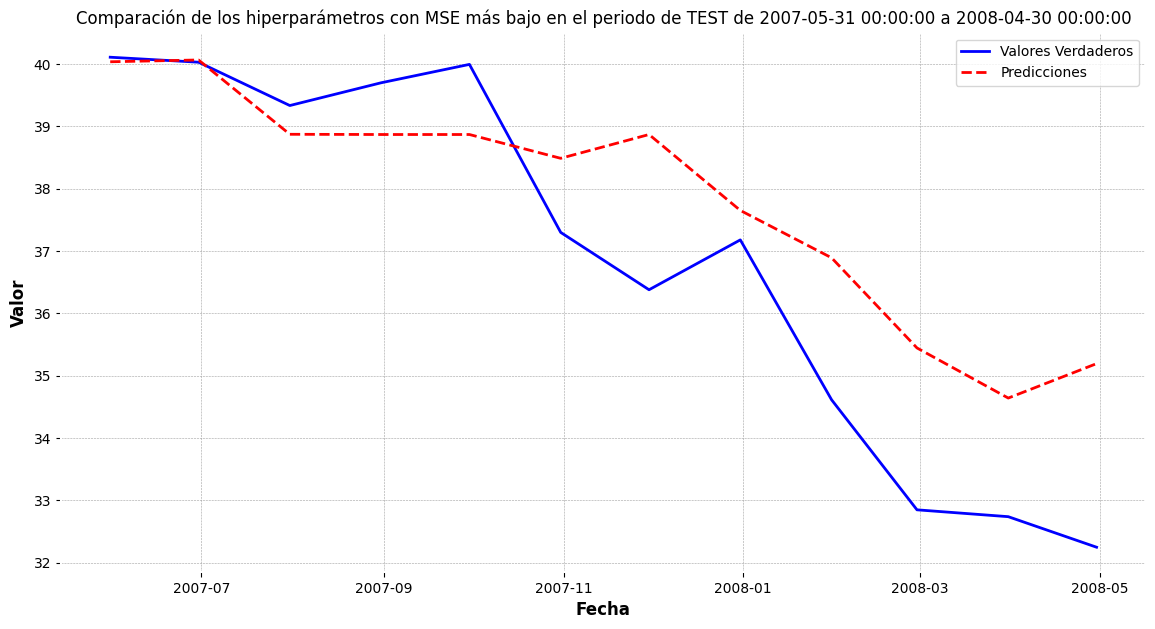

**************************************************
Índice: 93
Fecha de inicio de TEST: 2008-05-31 00:00:00
Fecha de finalización de TEST: 2009-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 12.21209727674489
Hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}


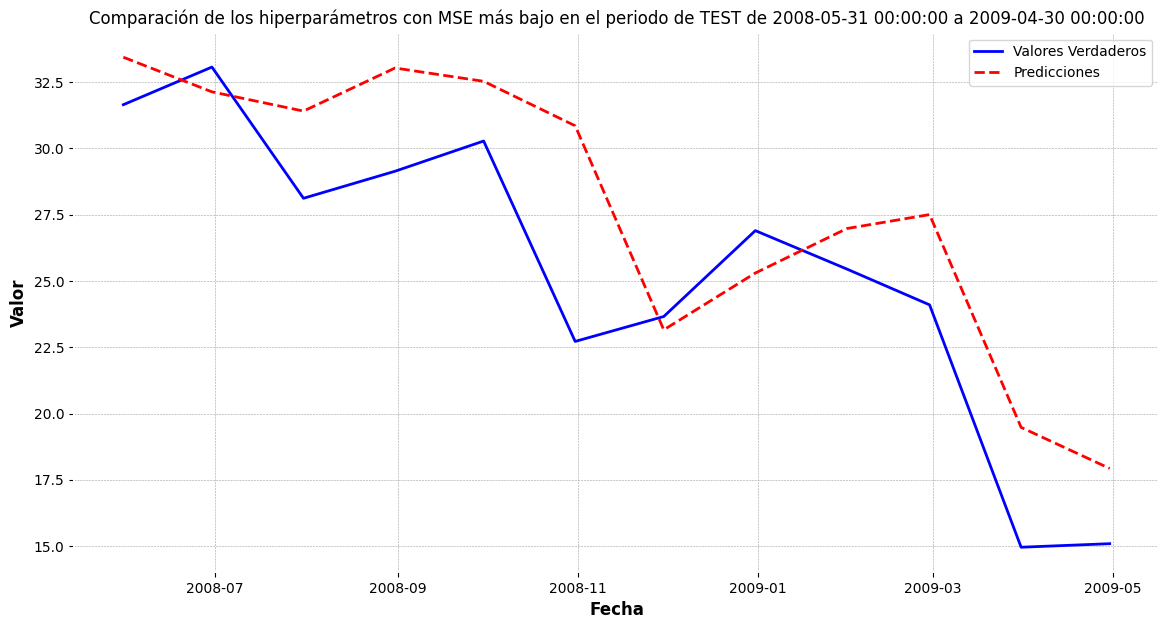

**************************************************
Índice: 196
Fecha de inicio de TEST: 2009-05-31 00:00:00
Fecha de finalización de TEST: 2010-04-30 00:00:00
Lags utilizados: 10
MSE más bajo: 0.9013070018137821
Hiperparámetros: {'learning_rate': 0.18978115379676513, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7013802243030709}


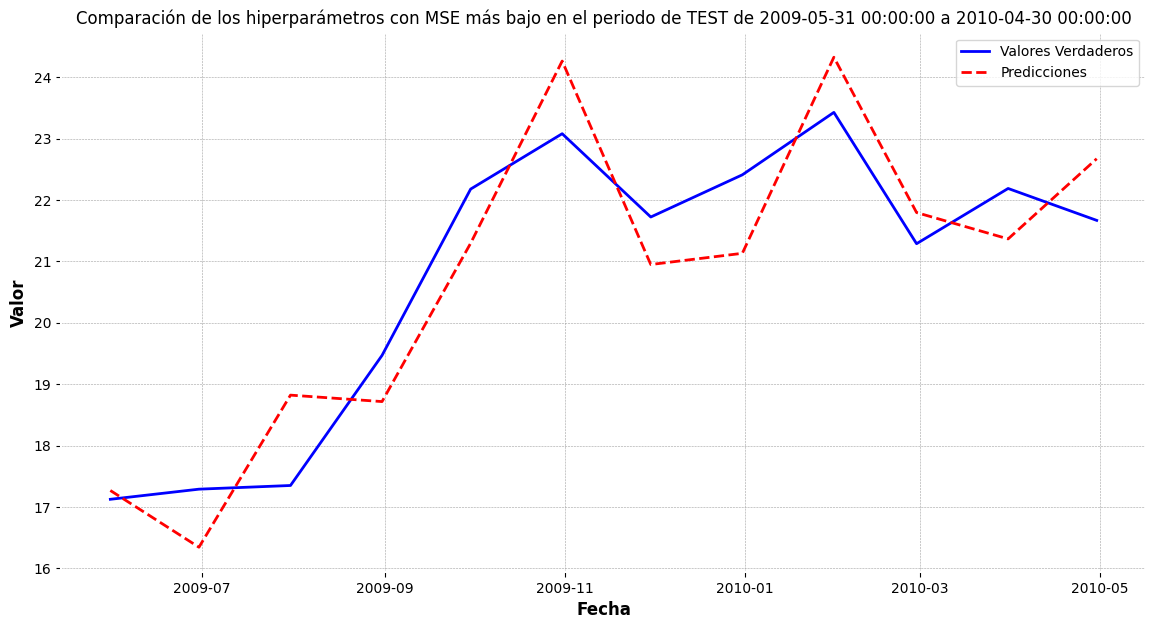

**************************************************
Índice: 273
Fecha de inicio de TEST: 2010-05-31 00:00:00
Fecha de finalización de TEST: 2011-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 1.5905001603156732
Hiperparámetros: {'learning_rate': 0.1971939238445361, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.6226846372597297}


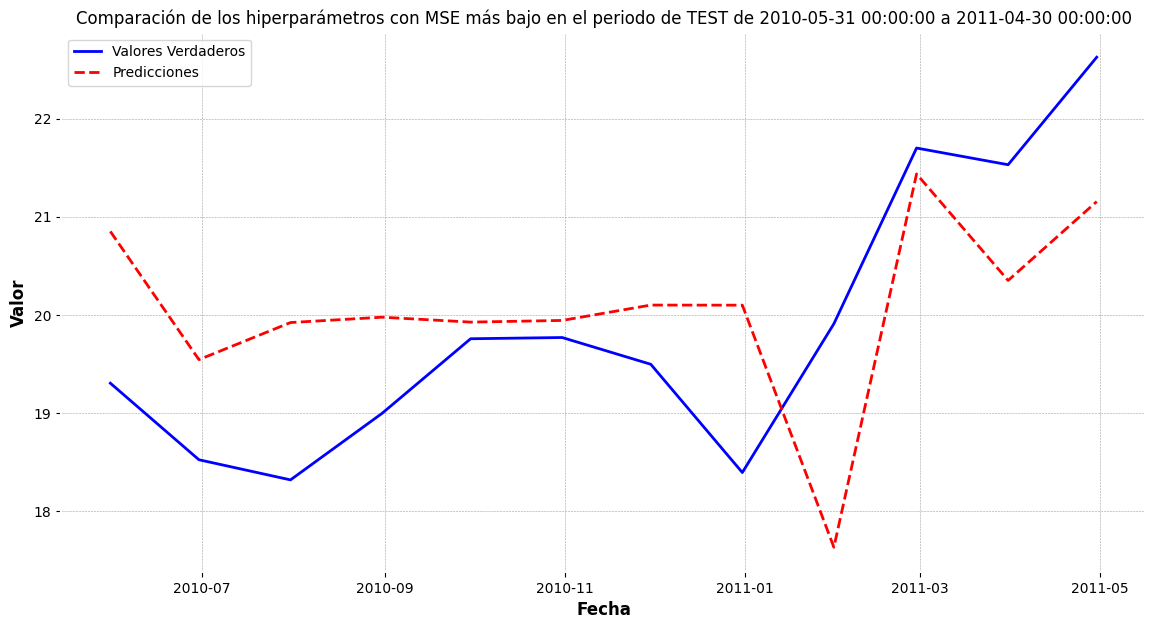

**************************************************
Índice: 426
Fecha de inicio de TEST: 2011-05-31 00:00:00
Fecha de finalización de TEST: 2012-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 1.5539553436350584
Hiperparámetros: {'learning_rate': 0.15165427372753648, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.6930785534816764}


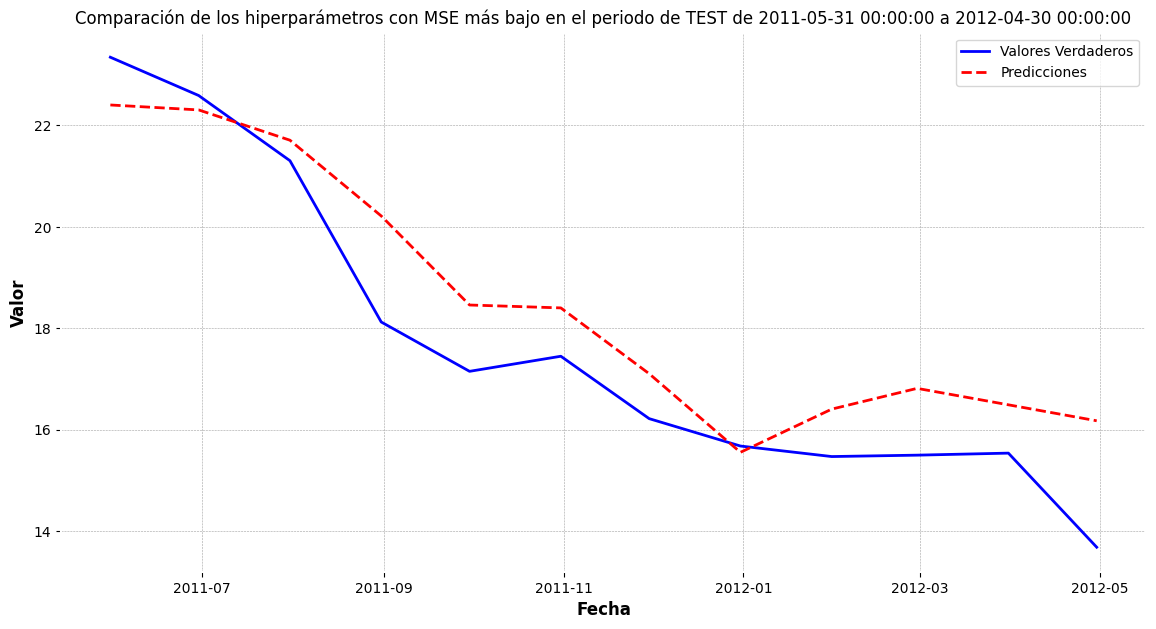

**************************************************
Índice: 465
Fecha de inicio de TEST: 2012-05-31 00:00:00
Fecha de finalización de TEST: 2013-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 1.1784130016134464
Hiperparámetros: {'learning_rate': 0.18978115379676513, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7013802243030709}


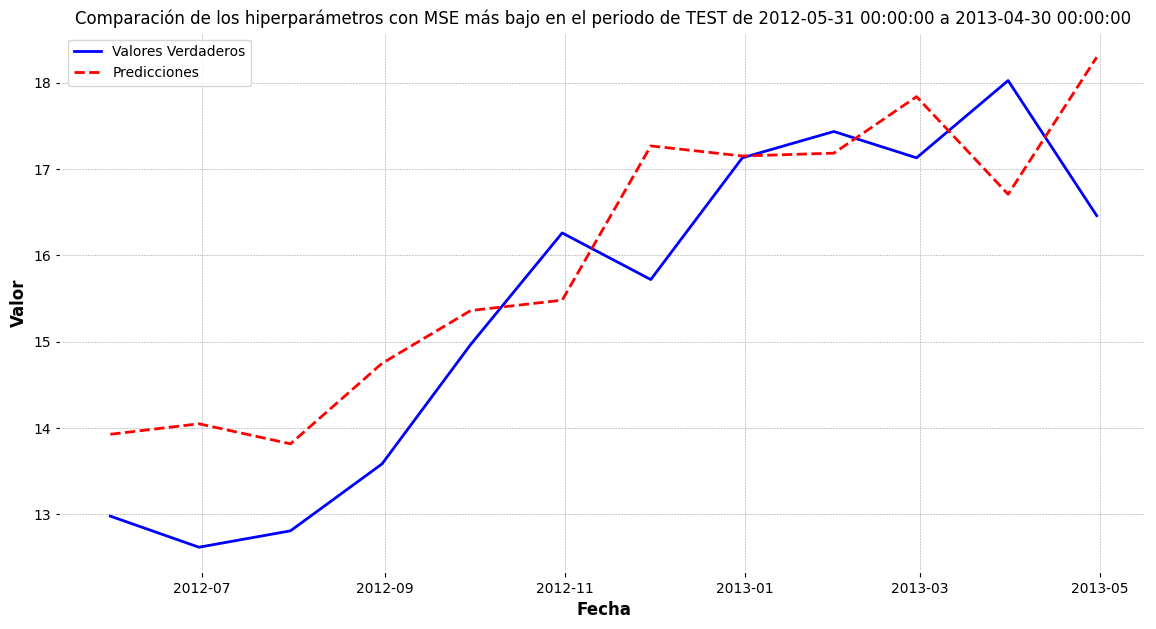

**************************************************
Índice: 613
Fecha de inicio de TEST: 2013-05-31 00:00:00
Fecha de finalización de TEST: 2014-04-30 00:00:00
Lags utilizados: 10
MSE más bajo: 10.84457893557771
Hiperparámetros: {'learning_rate': 0.11654241240895166, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'subsample': 0.7841080544891307}


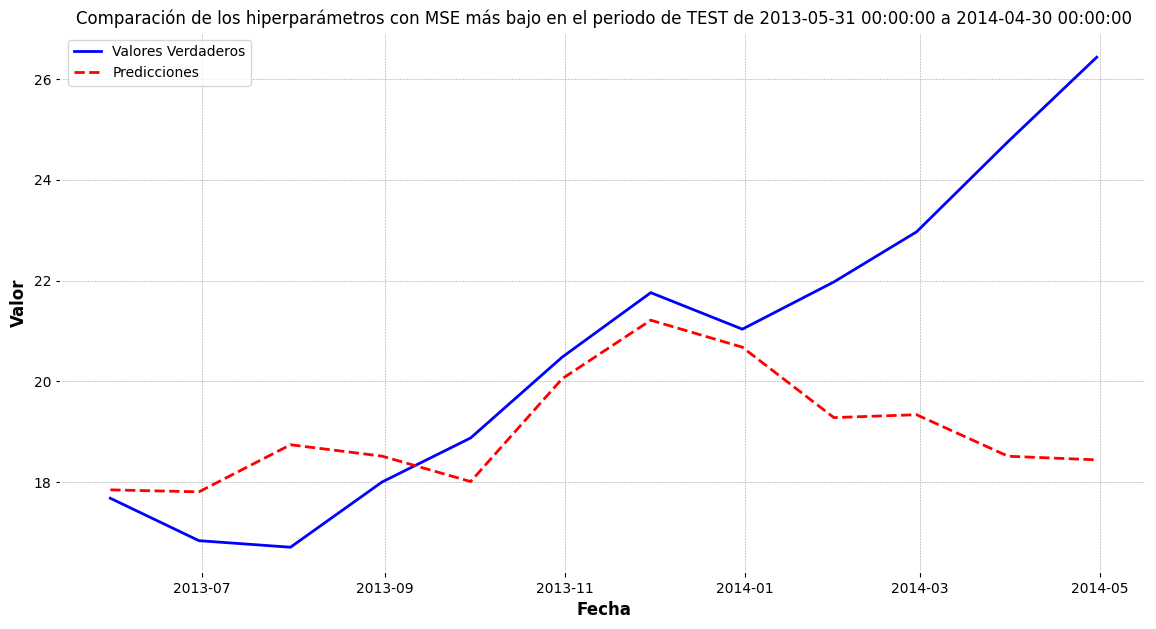

**************************************************
Índice: 663
Fecha de inicio de TEST: 2014-05-31 00:00:00
Fecha de finalización de TEST: 2015-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 14.684878488412295
Hiperparámetros: {'learning_rate': 0.09229751541514342, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8026030110028619}


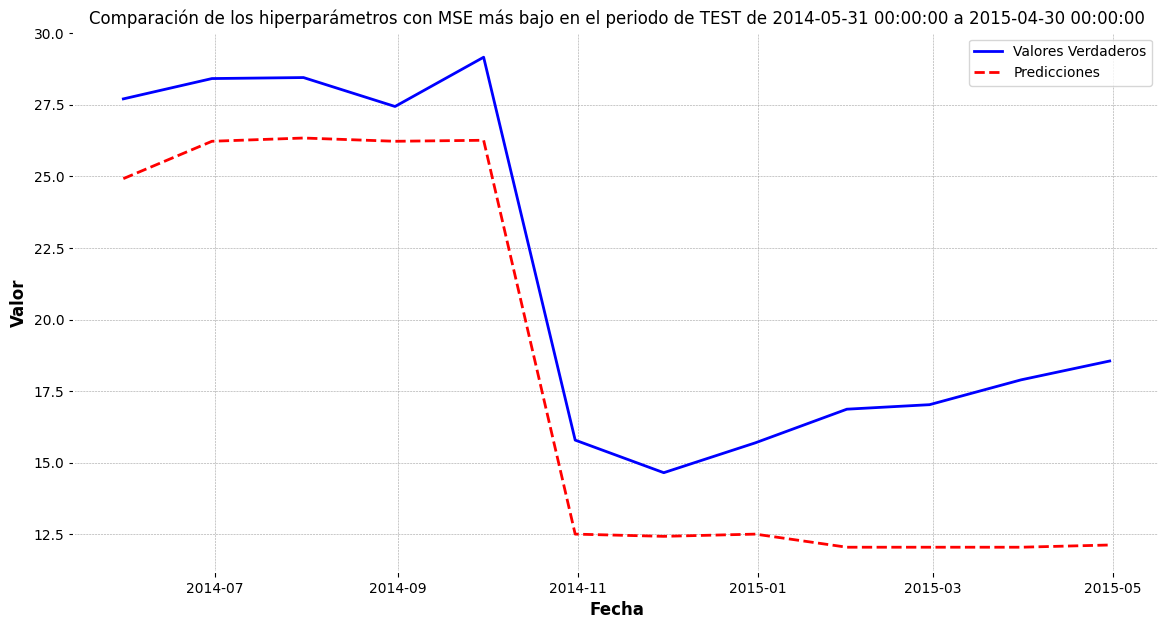

**************************************************
Índice: 730
Fecha de inicio de TEST: 2015-05-31 00:00:00
Fecha de finalización de TEST: 2016-04-30 00:00:00
Lags utilizados: 10
MSE más bajo: 1.1038822003666444
Hiperparámetros: {'learning_rate': 0.05932698714205117, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.6870254705516132}


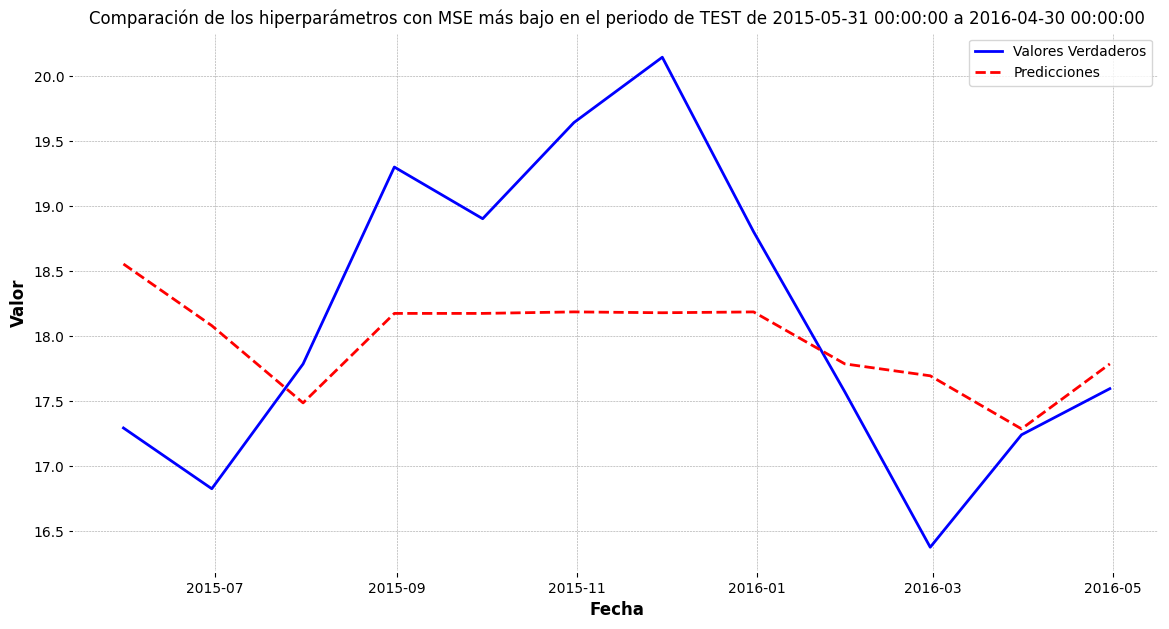

**************************************************
Índice: 843
Fecha de inicio de TEST: 2016-05-31 00:00:00
Fecha de finalización de TEST: 2017-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 4.672106564555288
Hiperparámetros: {'learning_rate': 0.09229751541514342, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8026030110028619}


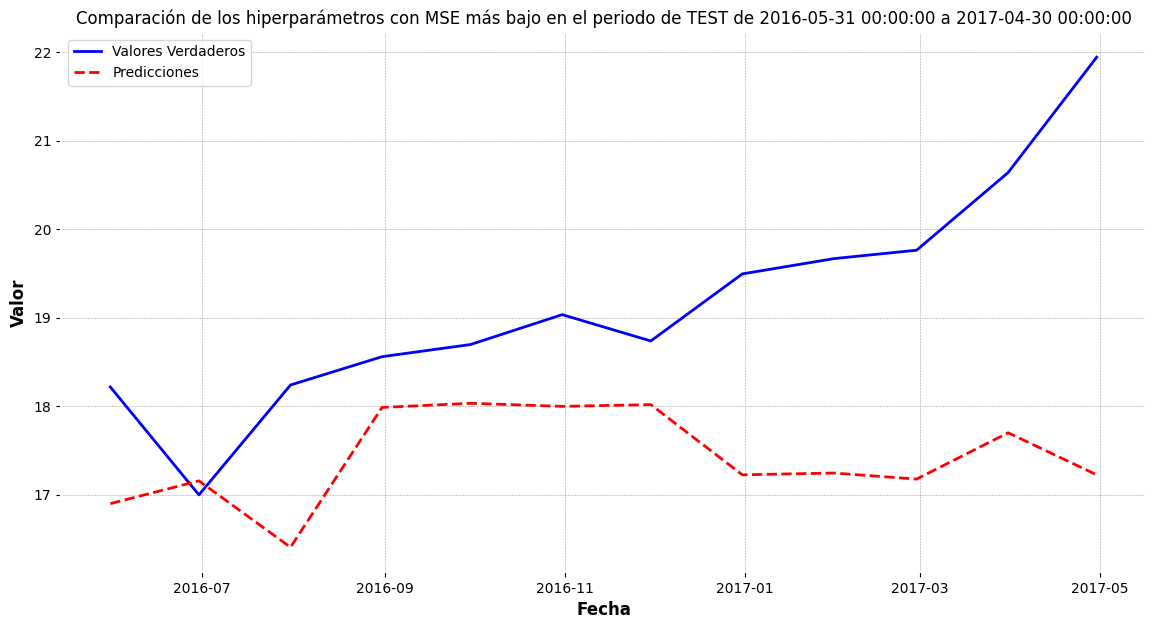

**************************************************
Índice: 938
Fecha de inicio de TEST: 2017-05-31 00:00:00
Fecha de finalización de TEST: 2018-04-30 00:00:00
Lags utilizados: 20
MSE más bajo: 0.7315825415442868
Hiperparámetros: {'learning_rate': 0.17440523692005605, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7808640806257001}


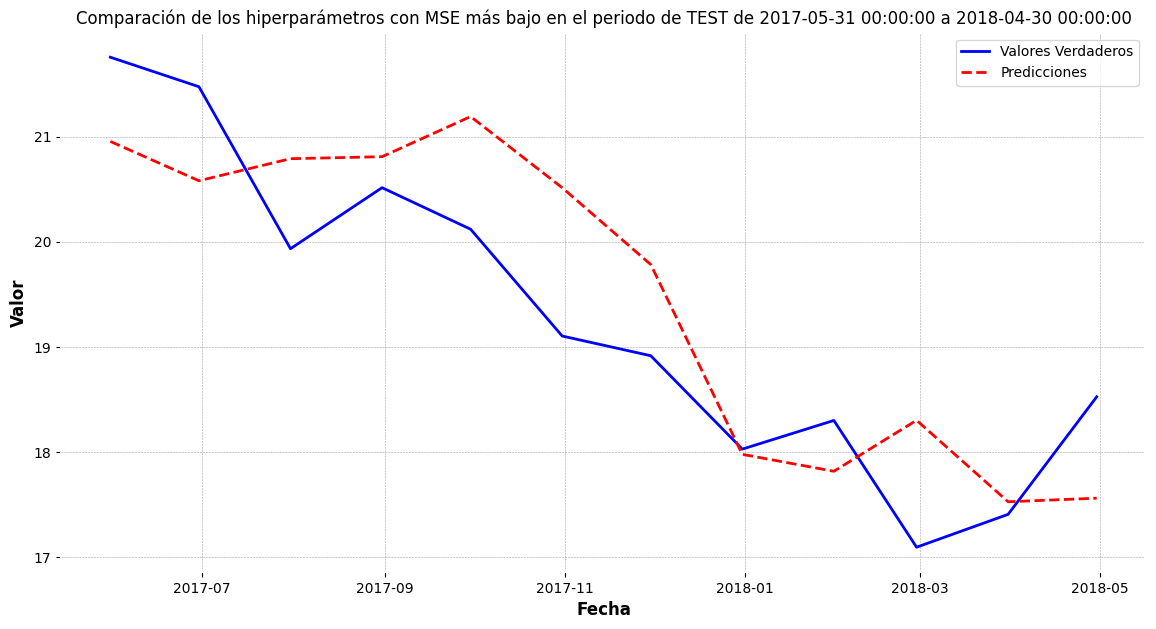

**************************************************
Índice: 1061
Fecha de inicio de TEST: 2018-05-31 00:00:00
Fecha de finalización de TEST: 2019-04-30 00:00:00
Lags utilizados: 20
MSE más bajo: 3.293956119373501
Hiperparámetros: {'learning_rate': 0.1921293196194629, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6279408787904085}


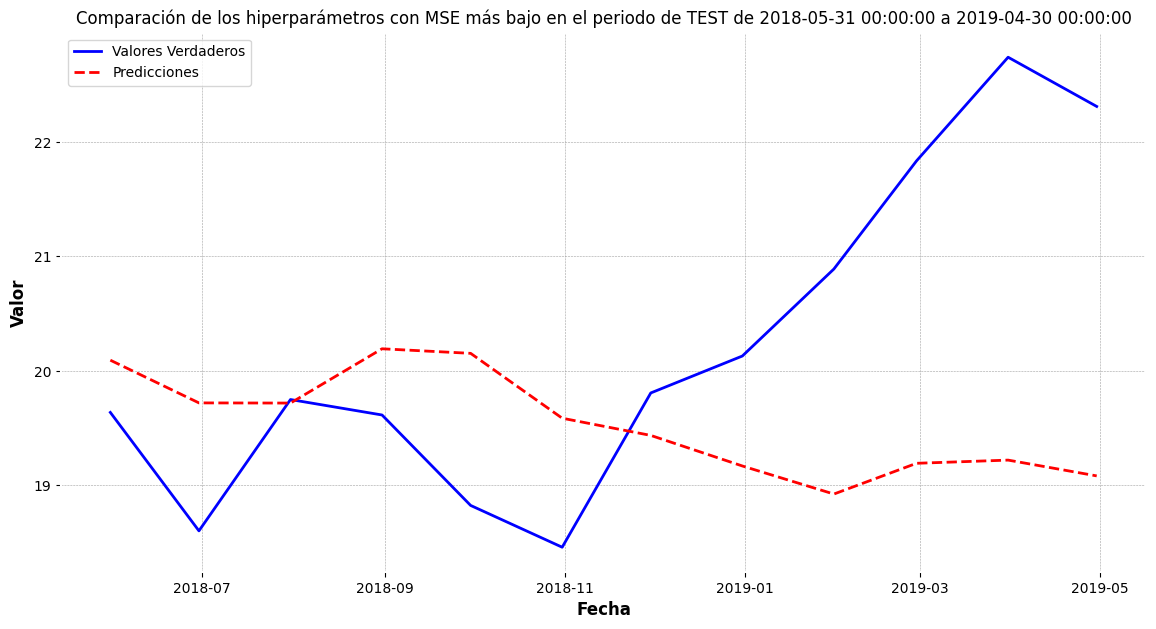

**************************************************
Índice: 1093
Fecha de inicio de TEST: 2019-05-31 00:00:00
Fecha de finalización de TEST: 2020-04-30 00:00:00
Lags utilizados: 10
MSE más bajo: 3.8291177309659137
Hiperparámetros: {'learning_rate': 0.16233182956977532, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 400, 'subsample': 0.7145975110379919}


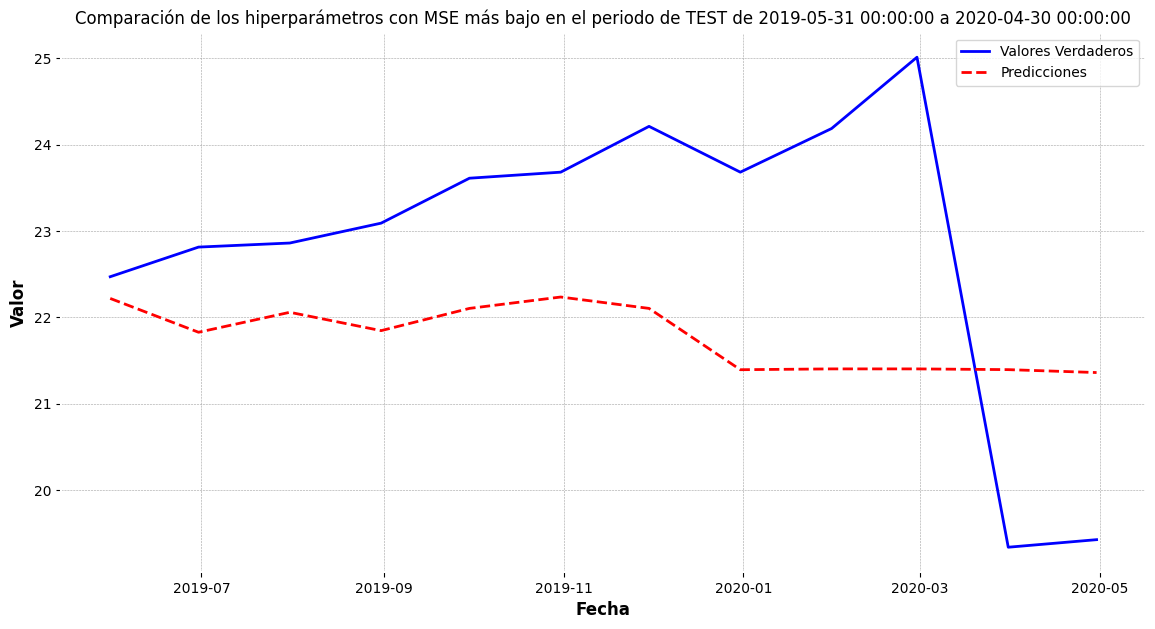

**************************************************
Índice: 1185
Fecha de inicio de TEST: 2020-05-31 00:00:00
Fecha de finalización de TEST: 2021-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 0.7585163552248605
Hiperparámetros: {'learning_rate': 0.18978115379676513, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7013802243030709}


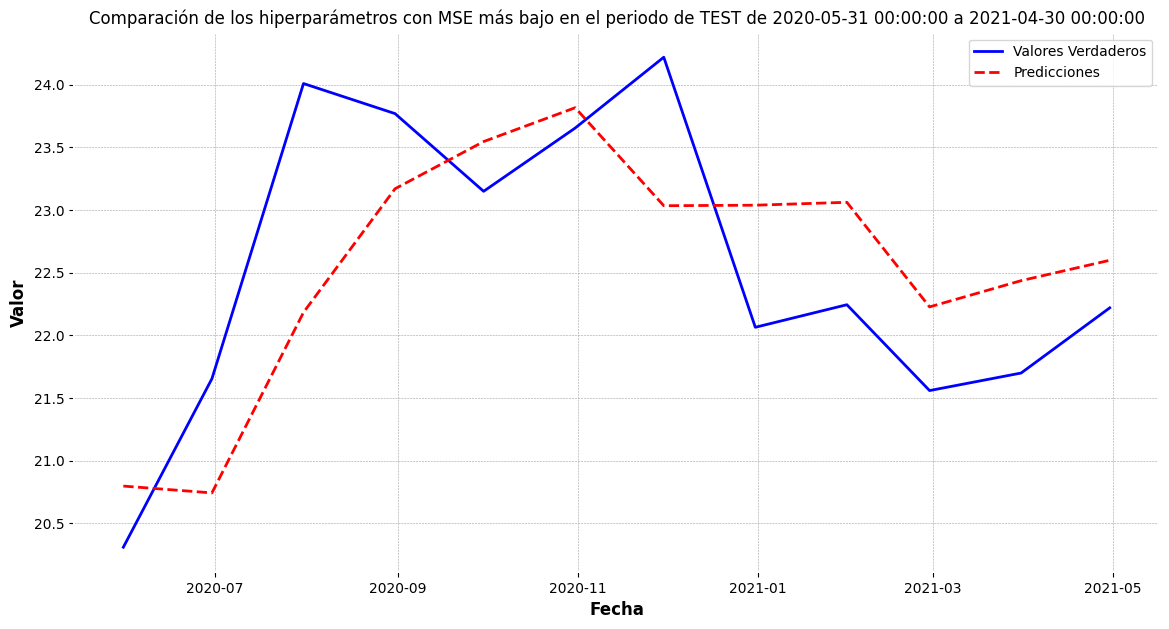

**************************************************
Índice: 1329
Fecha de inicio de TEST: 2021-05-31 00:00:00
Fecha de finalización de TEST: 2022-04-30 00:00:00
Lags utilizados: 5
MSE más bajo: 0.7070210158677214
Hiperparámetros: {'learning_rate': 0.1921293196194629, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6279408787904085}


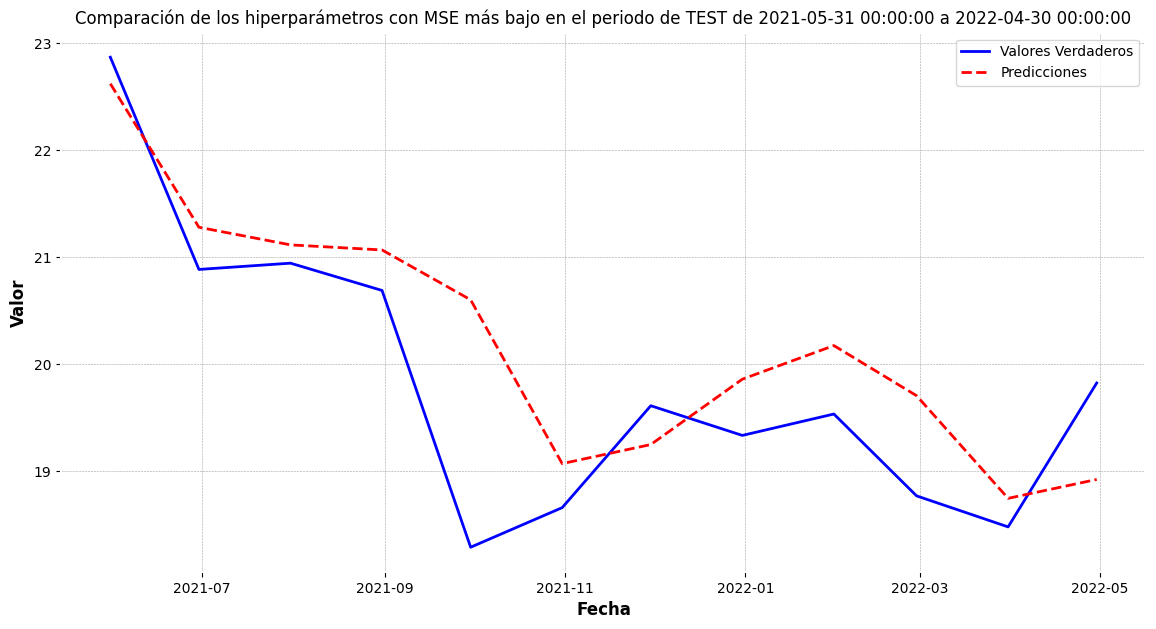

**************************************************
Índice: 1382
Fecha de inicio de TEST: 2022-05-31 00:00:00
Fecha de finalización de TEST: 2023-04-30 00:00:00
Lags utilizados: 20
MSE más bajo: 1.0145637416047877
Hiperparámetros: {'learning_rate': 0.16764787474447002, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.7130389516955076}


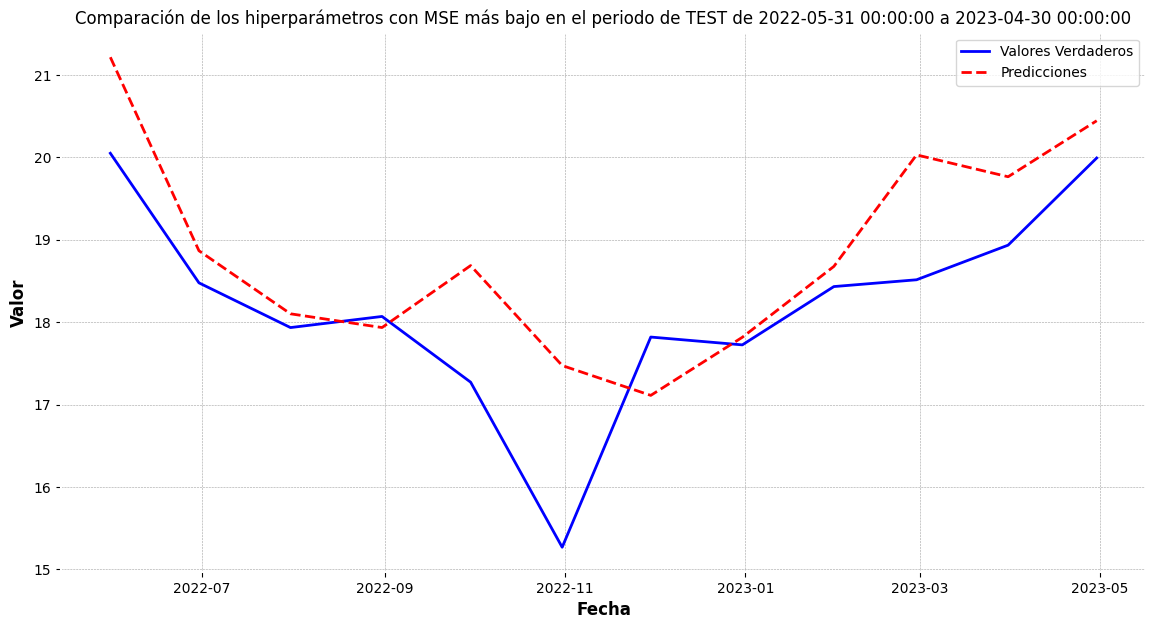

**************************************************


In [44]:
resultados_mse_minimos_gpt = resultados_xgb_gpt.loc[resultados_xgb_gpt.groupby(['start_test_date', 'end_test_date'])
                                            ['mse'].idxmin()]

resultados_mse_minimos_sorted_gpt = resultados_mse_minimos_gpt.sort_values(by='start_test_date')

for index, row in resultados_mse_minimos_sorted_gpt.iterrows():
    print(f"Índice: {index}")
    print(f"Fecha de inicio de TEST: {row['start_test_date']}")
    print(f"Fecha de finalización de TEST: {row['end_test_date']}")
    print(f"Lags utilizados: {row['lags']}")
    print(f"MSE más bajo: {row['mse']}")
    print(f"Hiperparámetros: {row['hyper']}")
    
    dates = pd.date_range(start=row['start_test_date'], end=row['end_test_date'], freq='M')
    
    lista_dividendos = dividendos_acumulados.reindex(dates, fill_value=0)
    
    row_real = row['real'] - lista_dividendos.values
    row_preds = row['preds'] - lista_dividendos.values
    
    plt.figure(figsize=(14, 7)) 
    plt.plot(dates, row_real, label='Valores Verdaderos', color='blue')
    plt.plot(dates, row_preds, label='Predicciones', color='red', linestyle='--')

    plt.title(f"Comparación de los hiperparámetros con MSE más bajo en el periodo de TEST de {row['start_test_date']} a {row['end_test_date']}")
    plt.xlabel('Fecha')
    plt.ylabel('Valor')

    plt.legend()

    plt.grid(True)

    plt.show()

    print("*"*50)

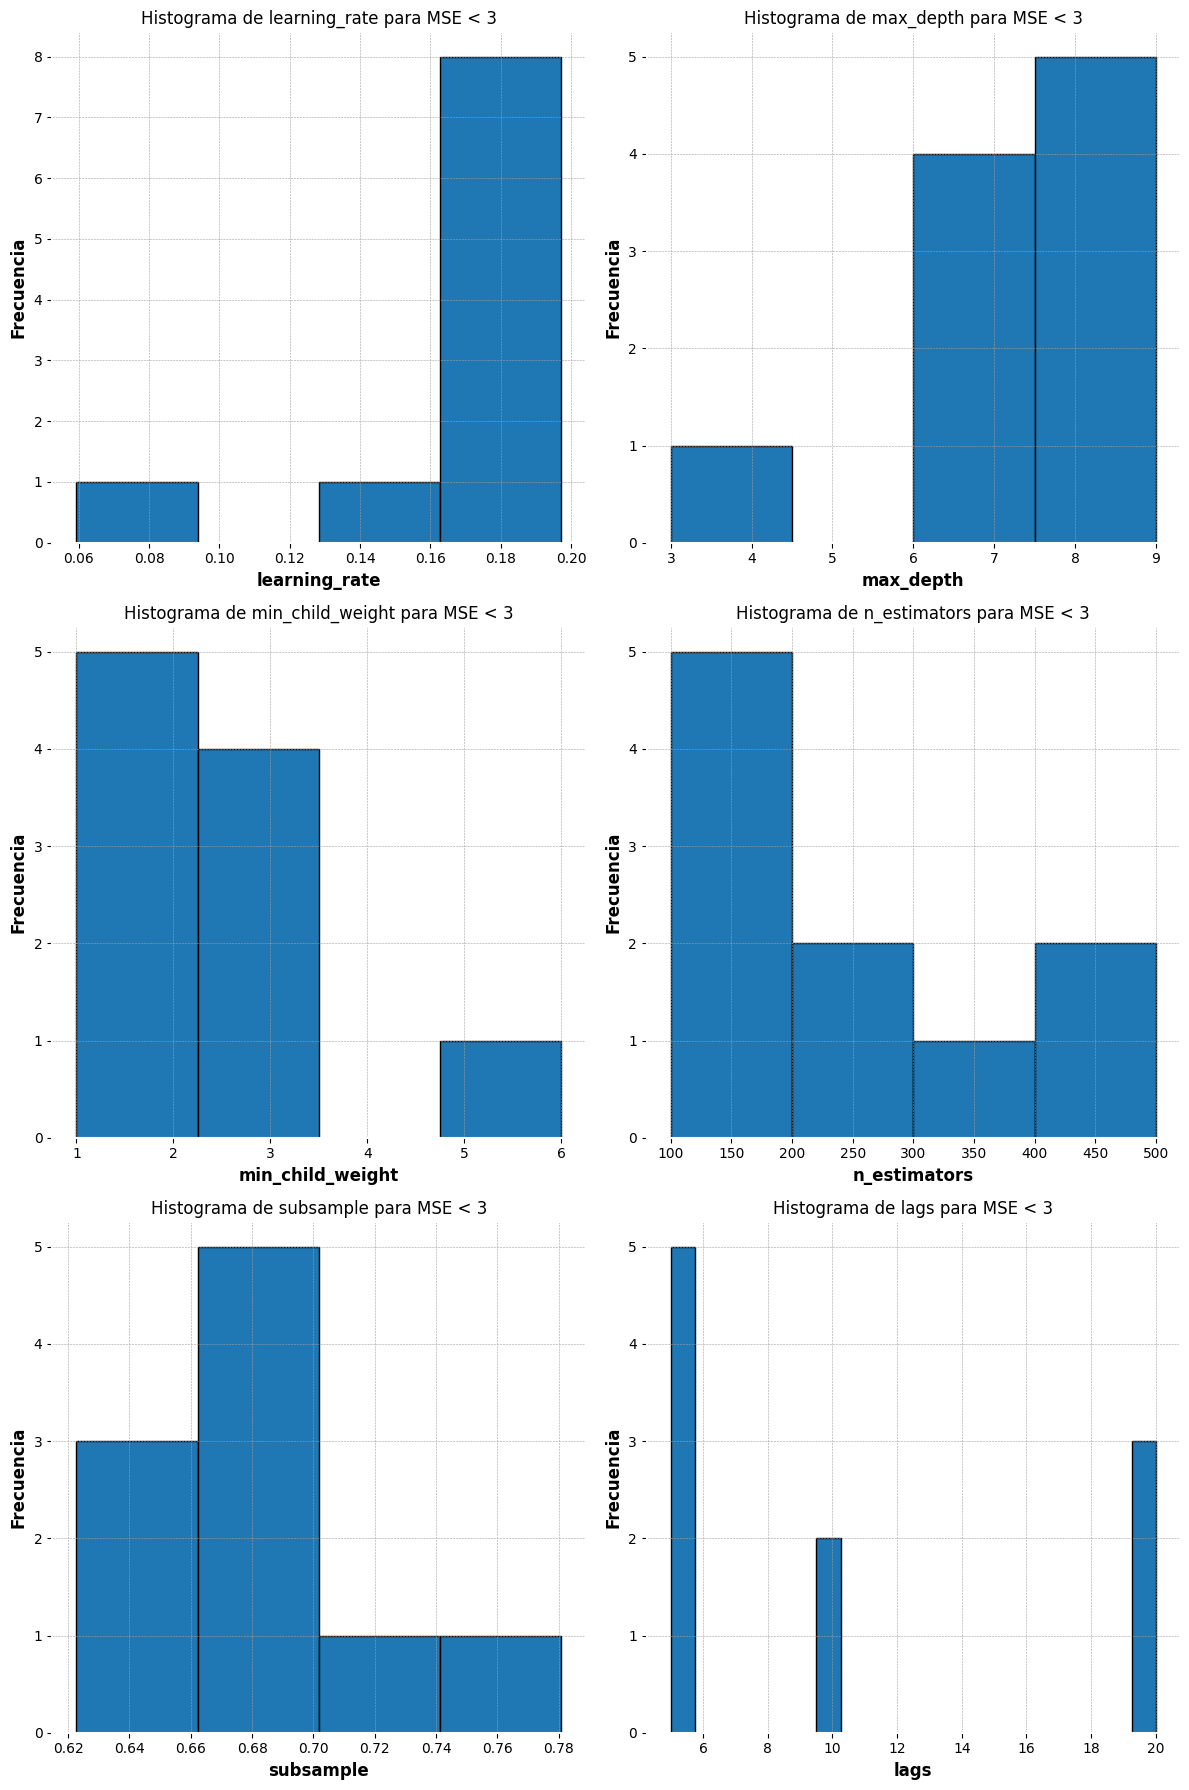

In [45]:
learning_rates_gpt = resultados_mse_minimos_sorted_gpt[resultados_mse_minimos_sorted_gpt['mse'] < 3]['hyper'].apply(lambda x: x['learning_rate'])
max_depth_gpt = resultados_mse_minimos_sorted_gpt[resultados_mse_minimos_sorted_gpt['mse'] < 3]['hyper'].apply(lambda x: x['max_depth'])
min_child_weight_gpt = resultados_mse_minimos_sorted_gpt[resultados_mse_minimos_sorted_gpt['mse'] < 3]['hyper'].apply(lambda x: x['min_child_weight'])
n_estimators_gpt = resultados_mse_minimos_sorted_gpt[resultados_mse_minimos_sorted_gpt['mse'] < 3]['hyper'].apply(lambda x: x['n_estimators'])
subsample_gpt = resultados_mse_minimos_sorted_gpt[resultados_mse_minimos_sorted_gpt['mse'] < 3]['hyper'].apply(lambda x: x['subsample'])
lags_gpt = resultados_mse_minimos_sorted_gpt[resultados_mse_minimos_sorted_gpt['mse'] < 3]['lags']

plt.figure(figsize=(12, 18))

# Histograma de learning_rate
plt.subplot(3, 2, 1)  
learning_rates_gpt.hist(bins=4, edgecolor='black')
plt.xlabel('learning_rate')
plt.ylabel('Frecuencia')
plt.title('Histograma de learning_rate para MSE < 3')
plt.grid(True)

# Histograma de max_depth
plt.subplot(3, 2, 2)  
max_depth_gpt.hist(bins=4, edgecolor='black')
plt.xlabel('max_depth')
plt.ylabel('Frecuencia')
plt.title('Histograma de max_depth para MSE < 3')
plt.grid(True)

# Histograma de min_child_weight
plt.subplot(3, 2, 3)  
min_child_weight_gpt.hist(bins=4, edgecolor='black')
plt.xlabel('min_child_weight')
plt.ylabel('Frecuencia')
plt.title('Histograma de min_child_weight para MSE < 3')
plt.grid(True)

# Histograma de n_estimators
plt.subplot(3, 2, 4)  
n_estimators_gpt.hist(bins=4, edgecolor='black')
plt.xlabel('n_estimators')
plt.ylabel('Frecuencia')
plt.title('Histograma de n_estimators para MSE < 3')
plt.grid(True)

# Histograma de subsample
plt.subplot(3, 2, 5)  
subsample_gpt.hist(bins=4, edgecolor='black')
plt.xlabel('subsample')
plt.ylabel('Frecuencia')
plt.title('Histograma de subsample para MSE < 3')
plt.grid(True)

# Histograma de lags
plt.subplot(3, 2, 6)  
lags_gpt.hist(bins=20, edgecolor='black')
plt.xlabel('lags')
plt.ylabel('Frecuencia')
plt.title('Histograma de lags para MSE < 3')
plt.grid(True)

plt.tight_layout()

plt.show()

In [46]:
resultados_mse_minimos

start_train_date end_train_date start_test_date end_test_date  lags  \
12         2002-09-30     2005-08-31      2005-09-30    2006-08-31     5   
155        2003-09-30     2006-08-31      2006-09-30    2007-08-31    20   
267        2004-09-30     2007-08-31      2007-09-30    2008-08-31     5   
332        2005-09-30     2008-08-31      2008-09-30    2009-08-31    20   
448        2006-09-30     2009-08-31      2009-09-30    2010-08-31    10   
477        2007-09-30     2010-08-31      2010-09-30    2011-08-31     5   
612        2008-09-30     2011-08-31      2011-09-30    2012-08-31     5   
689        2009-09-30     2012-08-31      2012-09-30    2013-08-31    20   
750        2010-09-30     2013-08-31      2013-09-30    2014-08-31     5   
879        2011-09-30     2014-08-31      2014-09-30    2015-08-31     5   
977        2012-09-30     2015-08-31      2015-09-30    2016-08-31    20   
1034       2013-09-30     2016-08-31      2016-09-30    2017-08-31    20   
1103       2014-09-30     2017-08-31      2017-09-30    2018-08-31    20   
1256       2015-09-30     2018-08-31      2018-09-30    2019-08-31    20   
1312       2016-09-30     2019-08-31      2019-09-30    2020-08-31    10   
1433       2017-09-30     2020-08-31      2020-09-30    2021-08-31    20   
1452       2018-09-30     2021-08-31      2021-09-30    2022-08-31     5   

                                                  hyper  \
12    {'learning_rate': 0.1985601852649278, 'max_dep...   
155   {'learning_rate': 0.08225614224702102, 'max_de...   
267   {'learning_rate': 0.19140651720691315, 'max_de...   
332   {'learning_rate': 0.10039167499119235, 'max_de...   
448   {'learning_rate': 0.19140651720691315, 'max_de...   
477   {'learning_rate': 0.09743498396263106, 'max_de...   
612   {'learning_rate': 0.19137962279321052, 'max_de...   
689   {'learning_rate': 0.1987621188937611, 'max_dep...   
750   {'learning_rate': 0.1866777753021937, 'max_dep...   
879   {'learning_rate': 0.08363549996324043, 'max_de...   
977   {'learning_rate': 0.10235330968403245, 'max_de...   
1034  {'learning_rate': 0.1719786002406973, 'max_dep...   
1103  {'learning_rate': 0.06947608221473132, 'max_de...   
1256  {'learning_rate': 0.19325075279317233, 'max_de...   
1312  {'learning_rate': 0.17371310095079479, 'max_de...   
1433  {'learning_rate': 0.10899057363797315, 'max_de...   
1452  {'learning_rate': 0.1985601852649278, 'max_dep...   

                                                   real  \
12    [24.371199961853026, 24.7062, 24.6712001525878...   
155   [33.617860152587895, 39.08786137329102, 40.642...   
267   [46.662860839233396, 43.967859237060544, 43.04...   
332   [38.478860686645504, 30.918859313354492, 31.85...   
448   [36.27586030517578, 37.17835950408936, 35.8208...   
477   [34.881360648498536, 34.89386045776367, 34.621...   
612   [33.293360152587894, 33.59086076293946, 32.360...   
689   [31.714359732971193, 33.006860228881834, 32.46...   
750   [35.62186, 37.226859542236326, 38.506860228881...   
879   [47.40685984741211, 47.831859084472654, 46.694...   
977   [51.704360152587896, 52.44435992370606, 52.946...   
1034  [52.52536022888184, 52.86285984741211, 52.5653...   
1103  [55.280860839233405, 54.26586049591065, 54.078...   
1256  [55.367860762939465, 55.00285908447267, 56.350...   
1312  [61.579860610351574, 61.64986030517579, 62.179...   
1433  [62.5948605722046, 63.099859732971204, 63.6648...   
1452  [59.748459961853044, 60.118459847412126, 61.07...   

                                                  preds         mse  
12    [22.07487, 22.07487, 22.07487, 22.07487, 22.07...   43.905582  
155   [31.66025, 31.39993, 31.275528, 31.275528, 31....  146.641788  
267   [45.858772, 45.858772, 45.858772, 44.363377, 4...    7.826761  
332   [36.522724, 37.750988, 31.138702, 32.376892, 3...   10.040182  
448   [37.128494, 37.13118, 35.70822, 36.34357, 37.7...    0.772011  
477   [34.672516, 35.092785, 35.016808, 34.66441, 34...    1.893922  
612   [33.854958, 34

In [47]:
resultados_mse_minimos_gpt

start_train_date end_train_date start_test_date end_test_date  lags  \
71         2004-05-31     2007-04-30      2007-05-31    2008-04-30    20   
93         2005-05-31     2008-04-30      2008-05-31    2009-04-30     5   
196        2006-05-31     2009-04-30      2009-05-31    2010-04-30    10   
273        2007-05-31     2010-04-30      2010-05-31    2011-04-30     5   
426        2008-05-31     2011-04-30      2011-05-31    2012-04-30     5   
465        2009-05-31     2012-04-30      2012-05-31    2013-04-30     5   
613        2010-05-31     2013-04-30      2013-05-31    2014-04-30    10   
663        2011-05-31     2014-04-30      2014-05-31    2015-04-30     5   
730        2012-05-31     2015-04-30      2015-05-31    2016-04-30    10   
843        2013-05-31     2016-04-30      2016-05-31    2017-04-30     5   
938        2014-05-31     2017-04-30      2017-05-31    2018-04-30    20   
1061       2015-05-31     2018-04-30      2018-05-31    2019-04-30    20   
1093       2016-05-31     2019-04-30      2019-05-31    2020-04-30    10   
1185       2017-05-31     2020-04-30      2020-05-31    2021-04-30     5   
1329       2018-05-31     2021-04-30      2021-05-31    2022-04-30     5   
1382       2019-05-31     2022-04-30      2022-05-31    2023-04-30    20   

                                                  hyper  \
71    {'learning_rate': 0.1921293196194629, 'max_dep...   
93    {'learning_rate': 0.1971939238445361, 'max_dep...   
196   {'learning_rate': 0.18978115379676513, 'max_de...   
273   {'learning_rate': 0.1971939238445361, 'max_dep...   
426   {'learning_rate': 0.15165427372753648, 'max_de...   
465   {'learning_rate': 0.18978115379676513, 'max_de...   
613   {'learning_rate': 0.11654241240895166, 'max_de...   
663   {'learning_rate': 0.09229751541514342, 'max_de...   
730   {'learning_rate': 0.05932698714205117, 'max_de...   
843   {'learning_rate': 0.09229751541514342, 'max_de...   
938   {'learning_rate': 0.17440523692005605, 'max_de...   
1061  {'learning_rate': 0.1921293196194629, 'max_dep...   
1093  {'learning_rate': 0.16233182956977532, 'max_de...   
1185  {'learning_rate': 0.18978115379676513, 'max_de...   
1329  {'learning_rate': 0.1921293196194629, 'max_dep...   
1382  {'learning_rate': 0.16764787474447002, 'max_de...   

                                                   real  \
71    [45.637858703002934, 45.55785877929688, 46.002...   
93    [38.81785961853027, 40.237859694824216, 36.318...   
196   [31.220860000000002, 31.38585996185303, 31.445...   
273   [33.90086030517578, 33.120859618530275, 33.443...   
426   [38.96886026702881, 38.21386015258789, 37.4458...   
465   [29.120860019073486, 28.760859885559082, 29.55...   
613   [34.42435977111816, 33.58186003814697, 33.4518...   
663   [45.95185992370605, 46.66186091552734, 46.6968...   
730   [49.71435954223633, 49.24685980926514, 50.5868...   
843   [51.419359732971195, 50.82686, 52.067859771118...   
938   [56.28286011444092, 56.63535912261963, 55.0958...   
1061  [55.498359809265146, 55.14585984741212, 56.292...   
1093  [59.71285931335451, 60.78285996185304, 60.8298...   
1185  [58.97986041961671, 61.099860305175795, 63.454...   
1329  [63.014860839233414, 62.34486076293947, 62.403...   
1382  [62.00846019073488, 61.373459961853044, 60.830...   

                                                  preds        mse  
71    [45.56495, 45.593693, 45.541668, 45.538082, 45...   2.852587  
93    [40.60912, 39.303043, 39.607925, 41.233204, 40...  12.212097  
196   [31.364359, 30.439857, 32.918293, 32.813183, 3...   0.901307  
273   [35.446686, 34.140606, 35.046364, 35.100887, 3...   1.590500  
426   [38.027443, 37.930035, 37.8498, 36.3565, 34.60...   1.553955  
465   [30.069056, 30.19051, 30.56427, 31.496466, 32....   1.178413  
613   [34.590954, 34.551456, 35.486313, 35.260483, 3...  10.844579  
663   [43.16682, 44.471848, 44.585567, 44.471848, 44...  14.684878  
730   [50.97583, 50.501484, 50.287296, 50.97583, 50....   1.103882  
843   [50.1019

## En general, los resultados del modelo sin GPT son bastante peores que los del modelo con GPT.

In [48]:
print(f"La mediana de error MSE sin GPT es {resultados_mse_minimos['mse'].median()}, y la media {resultados_mse_minimos['mse'].mean()}")

La mediana de error MSE sin GPT es 3.598898601644917, y la media 17.2771017196013


In [49]:
print(f"La mediana de error MSE con GPT es {resultados_mse_minimos_gpt['mse'].median()}, y la media {resultados_mse_minimos_gpt['mse'].mean()}")

La mediana de error MSE con GPT es 1.5722277519753658, y la media 3.870566496777998


## Reentrenamos el último modelo con todos los datos en train salvo el último periodo 2022-05-31	2023-04-30, que utilizaremos para validación. 

## De este modelo obtendremos el Feature Importances, de cara a saber qué tipos de noticias, lags, ... son más importantes a la hora de determinar la predicción.

## Utilizaremos los hiperparámetros óptimos seǵun los histogramas del apartado _gpt

In [50]:
lags = [5] #, 10, 20]

hyper = {
    'learning_rate': 0.15,
    'max_depth': 5,
    'min_child_weight': 2,
    'n_estimators': 350,
    'subsample': 0.72
}

ventana_final = [['2002-09-30', '2021-08-31', '2021-09-30', '2022-08-31']]

resultados_xgb_gpt_final = []
for start_train_date, end_train_date, start_test_date, end_test_date in ventana_final:
    for lg in lags:
        print(f"Probamos con Train desde {start_train_date} hasta {end_train_date} y con Test desde {start_test_date} hasta {end_test_date}")
        print(f"Con {lg} lags.")
        print(f"Con los siguientes hiperparámetros: {hyper}")

        train = cotizacion_gpt[(cotizacion_gpt.index >= start_train_date) & (cotizacion_gpt.index <= end_train_date)]
        test = cotizacion_gpt[(cotizacion_gpt.index > end_train_date) & (cotizacion_gpt.index <= end_test_date)]

        X_train, y_train = train.drop('Close', axis=1), train['Close']
        X_test, y_test = test.drop('Close', axis=1), test['Close'].tolist()

        X_train = X_train.iloc[:, list(range(lg)) + list(range(20, 31))]
        X_test = X_test.iloc[:, list(range(lg)) + list(range(20, 31))]

        model = xgb.XGBRegressor(**hyper)
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        print(f"Obteniendo un MSE de: {mse}")
        print("*"*50)

        iteracion = {
            'start_train_date': start_train_date, 
            'end_train_date': end_train_date, 
            'start_test_date': start_test_date, 
            'end_test_date': end_test_date,
            'lags': lg,
            'hyper': hyper,
            'real': y_test,
            'preds': preds,
            'mse': mse 
        }
        resultados_xgb_gpt_final.append(iteracion)

resultados_xgb_gpt_final = pd.DataFrame(resultados_xgb_gpt_final)

Probamos con Train desde 2002-09-30 hasta 2021-08-31 y con Test desde 2021-09-30 hasta 2022-08-31
Con 5 lags.
Con los siguientes hiperparámetros: {'learning_rate': 0.15, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 350, 'subsample': 0.72}
Obteniendo un MSE de: 0.8672621440442416
**************************************************


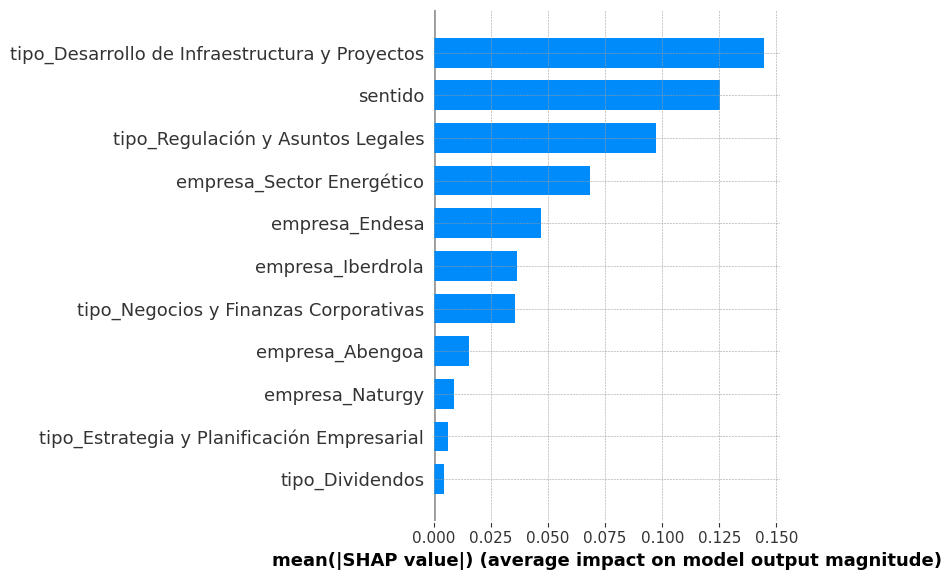

In [51]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

selected_features = [col for col in X_train.columns if col not in ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
selected_indices = [X_train.columns.get_loc(c) for c in selected_features]

shap_values_selected = shap_values[:, selected_indices]
shap.summary_plot(shap_values_selected, X_train[selected_features], plot_type="bar")

## A partir de este punto, probamos sin hiperparametrización (usamos los parámetros que hemos descubierto como óptimos) y tratamos de mejorar el resultado en base a modificaciones al dataset.

In [52]:
cotizacion_gpt.head()

Close   lag_1   lag_2   lag_3   lag_4   lag_5   lag_6   lag_7  \
Date                                                                         
2004-05-31  17.039  17.634  17.079  17.899  17.344  16.290  15.720  15.425   
2004-06-30  18.019  17.039  17.634  17.079  17.899  17.344  16.290  15.720   
2004-07-31  18.043  18.019  17.039  17.634  17.079  17.899  17.344  16.290   
2004-08-31  17.668  18.043  18.019  17.039  17.634  17.079  17.899  17.344   
2004-09-30  18.243  17.668  18.043  18.019  17.039  17.634  17.079  17.899   

             lag_8   lag_9  ...  empresa_Abengoa  empresa_Endesa  \
Date                        ...                                    
2004-05-31  15.985  16.185  ...              0.0             0.0   
2004-06-30  15.425  15.985  ...              0.0             1.0   
2004-07-31  15.720  15.425  ...              0.0             0.0   
2004-08-31  16.290  15.720  ...              0.0             0.0   
2004-09-30  17.344  16.290  ...              0.0             0.0   

            empresa_Iberdrola  empresa_Naturgy  empresa_Sector Energético  \
Date                                                                        
2004-05-31                0.0              0.0                        2.0   
2004-06-30                0.0              0.0                        1.0   
2004-07-31                0.0              0.0                        0.0   
2004-08-31                0.0              0.0                        0.0   
2004-09-30                0.0              0.0                        0.0   

            tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
Date                                                                          
2004-05-31                                             1.0              0.0   
2004-06-30                                             1.0              0.0   
2004-07-31                                             0.0              0.0   
2004-08-31                                             0.0              0.0   
2004-09-30                                             0.0              0.0   

            tipo_Estrategia y Planificación Empresarial  \
Date                                                      
2004-05-31                                          1.0   
2004-06-30                                          0.0   
2004-07-31                                          0.0   
2004-08-31                                          0.0   
2004-09-30                                          0.0   

            tipo_Negocios y Finanzas Corporativas  \
Date                                                
2004-05-31                                    0.0   
2004-06-30                                    0.0   
2004-07-31                                    0.0   
2004-08-31                                    0.0   
2004-09-30                                    0.0   

            tipo_Regulación y Asuntos Legales  
Date                                           
2004-05-31                                0.0  
2004-06-30                                1.0  
2004-07-31                                0.0  
2004-08-31                                0.0  
2004-09-30                                0.0  

[5 rows x 32 columns]

Eliminamos los LAG no deseados (6 en adelante). 
Incorporamos el sentido a los valores de 'tipo de noticias'.

In [53]:
drop_columnas = ['lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 
               'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 
               'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20']

cotizacion_gpt = cotizacion_gpt.drop(columns=drop_columnas)
cotizacion_gpt.head()

Close   lag_1   lag_2   lag_3   lag_4   lag_5  sentido  \
Date                                                                  
2004-05-31  17.039  17.634  17.079  17.899  17.344  16.290      0.3   
2004-06-30  18.019  17.039  17.634  17.079  17.899  17.344     -0.3   
2004-07-31  18.043  18.019  17.039  17.634  17.079  17.899      0.0   
2004-08-31  17.668  18.043  18.019  17.039  17.634  17.079      0.0   
2004-09-30  18.243  17.668  18.043  18.019  17.039  17.634      0.0   

            empresa_Abengoa  empresa_Endesa  empresa_Iberdrola  \
Date                                                             
2004-05-31              0.0             0.0                0.0   
2004-06-30              0.0             1.0                0.0   
2004-07-31              0.0             0.0                0.0   
2004-08-31              0.0             0.0                0.0   
2004-09-30              0.0             0.0                0.0   

            empresa_Naturgy  empresa_Sector Energético  \
Date                                                     
2004-05-31              0.0                        2.0   
2004-06-30              0.0                        1.0   
2004-07-31              0.0                        0.0   
2004-08-31              0.0                        0.0   
2004-09-30              0.0                        0.0   

            tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
Date                                                                          
2004-05-31                                             1.0              0.0   
2004-06-30                                             1.0              0.0   
2004-07-31                                             0.0              0.0   
2004-08-31                                             0.0              0.0   
2004-09-30                                             0.0              0.0   

            tipo_Estrategia y Planificación Empresarial  \
Date                                                      
2004-05-31                                          1.0   
2004-06-30                                          0.0   
2004-07-31                                          0.0   
2004-08-31                                          0.0   
2004-09-30                                          0.0   

            tipo_Negocios y Finanzas Corporativas  \
Date                                                
2004-05-31                                    0.0   
2004-06-30                                    0.0   
2004-07-31                                    0.0   
2004-08-31                                    0.0   
2004-09-30                                    0.0   

            tipo_Regulación y Asuntos Legales  
Date                                           
2004-05-31                                0.0  
2004-06-30                                1.0  
2004-07-31                                0.0  
2004-08-31                                0.0  
2004-09-30                                0.0

In [54]:
tipo_columns = [col for col in cotizacion_gpt.columns if col.startswith('tipo')]
cotizacion_gpt[tipo_columns] = cotizacion_gpt[tipo_columns].apply(lambda x: x * cotizacion_gpt['sentido'])
cotizacion_gpt = cotizacion_gpt.drop(columns=['sentido'])
cotizacion_gpt.head()

Close   lag_1   lag_2   lag_3   lag_4   lag_5  empresa_Abengoa  \
Date                                                                          
2004-05-31  17.039  17.634  17.079  17.899  17.344  16.290              0.0   
2004-06-30  18.019  17.039  17.634  17.079  17.899  17.344              0.0   
2004-07-31  18.043  18.019  17.039  17.634  17.079  17.899              0.0   
2004-08-31  17.668  18.043  18.019  17.039  17.634  17.079              0.0   
2004-09-30  18.243  17.668  18.043  18.019  17.039  17.634              0.0   

            empresa_Endesa  empresa_Iberdrola  empresa_Naturgy  \
Date                                                             
2004-05-31             0.0                0.0              0.0   
2004-06-30             1.0                0.0              0.0   
2004-07-31             0.0                0.0              0.0   
2004-08-31             0.0                0.0              0.0   
2004-09-30             0.0                0.0              0.0   

            empresa_Sector Energético  \
Date                                    
2004-05-31                        2.0   
2004-06-30                        1.0   
2004-07-31                        0.0   
2004-08-31                        0.0   
2004-09-30                        0.0   

            tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
Date                                                                          
2004-05-31                                             0.3              0.0   
2004-06-30                                            -0.3             -0.0   
2004-07-31                                             0.0              0.0   
2004-08-31                                             0.0              0.0   
2004-09-30                                             0.0              0.0   

            tipo_Estrategia y Planificación Empresarial  \
Date                                                      
2004-05-31                                          0.3   
2004-06-30                                         -0.0   
2004-07-31                                          0.0   
2004-08-31                                          0.0   
2004-09-30                                          0.0   

            tipo_Negocios y Finanzas Corporativas  \
Date                                                
2004-05-31                                    0.0   
2004-06-30                                   -0.0   
2004-07-31                                    0.0   
2004-08-31                                    0.0   
2004-09-30                                    0.0   

            tipo_Regulación y Asuntos Legales  
Date                                           
2004-05-31                                0.0  
2004-06-30                               -0.3  
2004-07-31                                0.0  
2004-08-31                                0.0  
2004-09-30                                0.0

In [55]:
hyper = {
    'learning_rate': 0.15,
    'max_depth': 5,
    'min_child_weight': 2,
    'n_estimators': 350,
    'subsample': 0.72
}

ventana_final = [['2002-09-30', '2021-08-31', '2021-09-30', '2022-08-31']]

resultados_xgb_gpt_final = []
for start_train_date, end_train_date, start_test_date, end_test_date in ventana_final:
    print(f"Probamos con Train desde {start_train_date} hasta {end_train_date} y con Test desde {start_test_date} hasta {end_test_date}")
    print(f"Con los siguientes hiperparámetros: {hyper}")

    train = cotizacion_gpt[(cotizacion_gpt.index >= start_train_date) & (cotizacion_gpt.index <= end_train_date)]
    test = cotizacion_gpt[(cotizacion_gpt.index > end_train_date) & (cotizacion_gpt.index <= end_test_date)]

    X_train, y_train = train.drop('Close', axis=1), train['Close']
    X_test, y_test = test.drop('Close', axis=1), test['Close'].tolist()

    model = xgb.XGBRegressor(**hyper)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"Obteniendo un MSE de: {mse}")
    print("*"*50)

    iteracion = {
        'start_train_date': start_train_date, 
        'end_train_date': end_train_date, 
        'start_test_date': start_test_date, 
        'end_test_date': end_test_date,
        'lags': lg,
        'hyper': hyper,
        'real': y_test,
        'preds': preds,
        'mse': mse 
    }
    resultados_xgb_gpt_final.append(iteracion)

resultados_xgb_gpt_final = pd.DataFrame(resultados_xgb_gpt_final)

Probamos con Train desde 2002-09-30 hasta 2021-08-31 y con Test desde 2021-09-30 hasta 2022-08-31
Con los siguientes hiperparámetros: {'learning_rate': 0.15, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 350, 'subsample': 0.72}
Obteniendo un MSE de: 1.0026513617846342
**************************************************


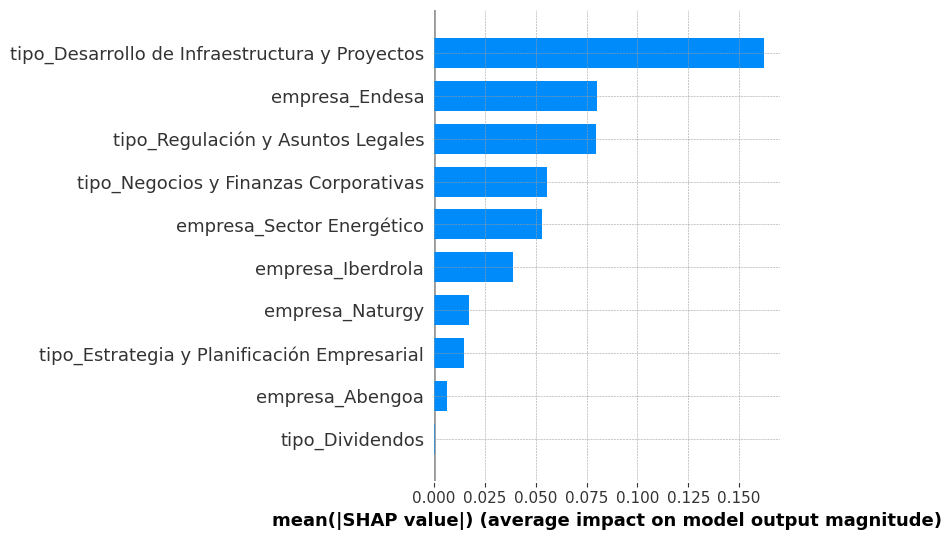

In [56]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

selected_features = [col for col in X_train.columns if col not in ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
selected_indices = [X_train.columns.get_loc(c) for c in selected_features]

shap_values_selected = shap_values[:, selected_indices]
shap.summary_plot(shap_values_selected, X_train[selected_features], plot_type="bar")

### Incorporamos todas las 'empresas' que no sean Endesa a la categoría 'Sector Energético' en lugar de tenerlas desglosadas, y volvermos a probar el modelo.

In [57]:
cotizacion_gpt['empresa_Abengoa'] = cotizacion_gpt['empresa_Abengoa'].fillna(0).astype(int)
cotizacion_gpt['empresa_Iberdrola'] = cotizacion_gpt['empresa_Iberdrola'].fillna(0).astype(int)
cotizacion_gpt['empresa_Naturgy'] = cotizacion_gpt['empresa_Naturgy'].fillna(0).astype(int)

cotizacion_gpt['empresa_Sector Energético'] = cotizacion_gpt['empresa_Abengoa'] | cotizacion_gpt['empresa_Iberdrola'] | cotizacion_gpt['empresa_Naturgy']
cotizacion_gpt.drop(['empresa_Abengoa', 'empresa_Iberdrola', 'empresa_Naturgy'], axis=1, inplace=True)

cotizacion_gpt.head()

Close   lag_1   lag_2   lag_3   lag_4   lag_5  empresa_Endesa  \
Date                                                                         
2004-05-31  17.039  17.634  17.079  17.899  17.344  16.290             0.0   
2004-06-30  18.019  17.039  17.634  17.079  17.899  17.344             1.0   
2004-07-31  18.043  18.019  17.039  17.634  17.079  17.899             0.0   
2004-08-31  17.668  18.043  18.019  17.039  17.634  17.079             0.0   
2004-09-30  18.243  17.668  18.043  18.019  17.039  17.634             0.0   

            empresa_Sector Energético  \
Date                                    
2004-05-31                          0   
2004-06-30                          0   
2004-07-31                          0   
2004-08-31                          0   
2004-09-30                          0   

            tipo_Desarrollo de Infraestructura y Proyectos  tipo_Dividendos  \
Date                                                                          
2004-05-31                                             0.3              0.0   
2004-06-30                                            -0.3             -0.0   
2004-07-31                                             0.0              0.0   
2004-08-31                                             0.0              0.0   
2004-09-30                                             0.0              0.0   

            tipo_Estrategia y Planificación Empresarial  \
Date                                                      
2004-05-31                                          0.3   
2004-06-30                                         -0.0   
2004-07-31                                          0.0   
2004-08-31                                          0.0   
2004-09-30                                          0.0   

            tipo_Negocios y Finanzas Corporativas  \
Date                                                
2004-05-31                                    0.0   
2004-06-30                                   -0.0   
2004-07-31                                    0.0   
2004-08-31                                    0.0   
2004-09-30                                    0.0   

            tipo_Regulación y Asuntos Legales  
Date                                           
2004-05-31                                0.0  
2004-06-30                               -0.3  
2004-07-31                                0.0  
2004-08-31                                0.0  
2004-09-30                                0.0

In [58]:
hyper = {
    'learning_rate': 0.15,
    'max_depth': 5,
    'min_child_weight': 2,
    'n_estimators': 350,
    'subsample': 0.72
}

ventana_final = [['2002-09-30', '2021-08-31', '2021-09-30', '2022-08-31']]

resultados_xgb_gpt_final = []
for start_train_date, end_train_date, start_test_date, end_test_date in ventana_final:
    print(f"Probamos con Train desde {start_train_date} hasta {end_train_date} y con Test desde {start_test_date} hasta {end_test_date}")
    print(f"Con los siguientes hiperparámetros: {hyper}")

    train = cotizacion_gpt[(cotizacion_gpt.index >= start_train_date) & (cotizacion_gpt.index <= end_train_date)]
    test = cotizacion_gpt[(cotizacion_gpt.index > end_train_date) & (cotizacion_gpt.index <= end_test_date)]

    X_train, y_train = train.drop('Close', axis=1), train['Close']
    X_test, y_test = test.drop('Close', axis=1), test['Close'].tolist()

    model = xgb.XGBRegressor(**hyper)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"Obteniendo un MSE de: {mse}")
    print("*"*50)

    iteracion = {
        'start_train_date': start_train_date, 
        'end_train_date': end_train_date, 
        'start_test_date': start_test_date, 
        'end_test_date': end_test_date,
        'lags': lg,
        'hyper': hyper,
        'real': y_test,
        'preds': preds,
        'mse': mse 
    }
    resultados_xgb_gpt_final.append(iteracion)

resultados_xgb_gpt_final = pd.DataFrame(resultados_xgb_gpt_final)

Probamos con Train desde 2002-09-30 hasta 2021-08-31 y con Test desde 2021-09-30 hasta 2022-08-31
Con los siguientes hiperparámetros: {'learning_rate': 0.15, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 350, 'subsample': 0.72}
Obteniendo un MSE de: 1.3887587631245253
**************************************************


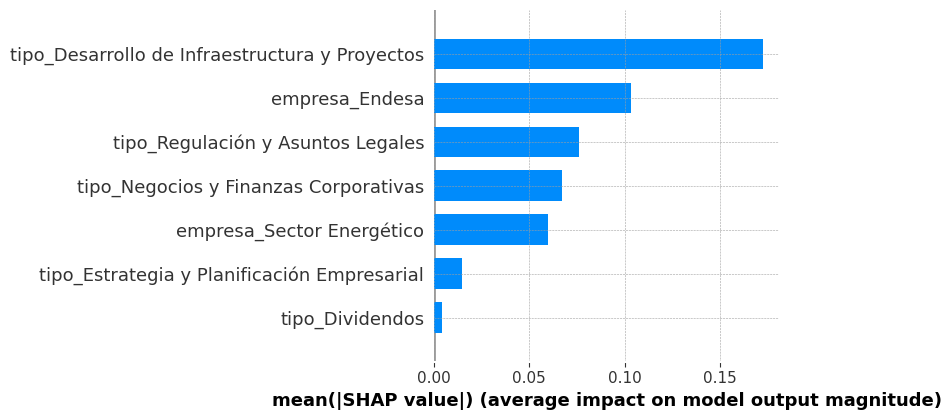

In [59]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

selected_features = [col for col in X_train.columns if col not in ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']]
selected_indices = [X_train.columns.get_loc(c) for c in selected_features]

shap_values_selected = shap_values[:, selected_indices]
shap.summary_plot(shap_values_selected, X_train[selected_features], plot_type="bar")

COMPARATIVA

In [66]:
df_resultadosholtwinters.sort_values(['MSE'])

Ventana        MSE  \
13  (2014-01-31 00:00:00, 2016-12-31 00:00:00, 201...   1.387505   
18  (2019-01-31 00:00:00, 2021-12-31 00:00:00, 202...   1.613606   
17  (2018-01-31 00:00:00, 2020-12-31 00:00:00, 202...   1.666215   
14  (2015-01-31 00:00:00, 2017-12-31 00:00:00, 201...   2.777410   
12  (2013-01-31 00:00:00, 2015-12-31 00:00:00, 201...   2.993666   
0   (2001-01-31 00:00:00, 2003-12-31 00:00:00, 200...   3.151619   
8   (2009-01-31 00:00:00, 2011-12-31 00:00:00, 201...   4.103148   
9   (2010-01-31 00:00:00, 2012-12-31 00:00:00, 201...   4.526795   
6   (2007-01-31 00:00:00, 2009-12-31 00:00:00, 201...   4.642787   
16  (2017-01-31 00:00:00, 2019-12-31 00:00:00, 202...   6.396092   
1   (2002-01-31 00:00:00, 2004-12-31 00:00:00, 200...  11.840223   
11  (2012-01-31 00:00:00, 2014-12-31 00:00:00, 201...  12.210791   
5   (2006-01-31 00:00:00, 2008-12-31 00:00:00, 200...  12.623541   
15  (2016-01-31 00:00:00, 2018-12-31 00:00:00, 201...  12.939492   
7   (2008-01-31 00:00:00, 2010-12-31 00:00:00, 201...  17.500362   
3   (2004-01-31 00:00:00, 2006-12-31 00:00:00, 200...  27.739198   
4   (2005-01-31 00:00:00, 2007-12-31 00:00:00, 200...  55.481546   
10  (2011-01-31 00:00:00, 2013-12-31 00:00:00, 201...  66.632932   
2   (2003-01-31 00:00:00, 2005-12-31 00:00:00, 200...  78.149793   

                                                 real  \
13  [54.19535954223633, 54.29035980926514, 55.1678...   
18  [61.493459847412126, 60.72846045776369, 60.438...   
17  [62.3898598855591, 61.7048594659424, 61.844860...   
14  [54.163359771118174, 52.95835984741212, 53.270...   
12  [50.77185969482422, 49.57686, 50.4418597711181...   
0   [17.34400005722046, 17.89900036239624, 17.0790...   
8   [31.613360324249268, 31.64086, 31.680859961853...   
9   [34.18185946594238, 33.876860114440916, 34.771...   
6   [38.02586030517578, 35.88585996185303, 36.7858...   
16  [62.8548594659424, 63.67986022888185, 58.00986...   
1   [19.954999198913576, 20.724999656677248, 20.29...   
11  [49.2918608392334, 49.44936015258789, 50.31686...   
5   [33.64886076293945, 32.298859427795406, 29.052...   
15  [58.13286034332277, 59.07786003814699, 59.9828...   
7   [35.53385984741211, 37.32385980926514, 37.1538...   
3   [42.977858855590824, 43.67786152587891, 44.177...   
4   [41.782861678466794, 40.01785847412109, 39.907...   
10  [40.21935984741211, 41.21435973297119, 43.0068...   
2   [26.47119908447266, 28.536199618530276, 31.221...   

                                           prediccion  
13  [53.817559137962874, 53.425730557452056, 54.22...  
18  [61.49583715550679, 61.76409313444048, 60.1290...  
17  [62.49522091170306, 62.45210367229936, 60.7365...  
14  [53.39018051846958, 52.96217526277721, 53.7182...  
12  [52.823808876591585, 52.588498168521745, 53.25...  
0   [16.4998212591159, 16.670375649241226, 16.7225...  
8   [33.589686922866775, 33.024745580650205, 32.18...  
9   [34.91041630715261, 34.889415679803335, 35.232...  
6   [35.07993656227327, 34.49432208804337, 33.7615...  
16  [62.51915923842787, 62.23279912347158, 62.6997...  
1   [20.076135250778133, 20.080565162215876, 19.88...  
11  [48.40838945763364, 48.18097040517148, 48.6235...  
5   [34.9145426303509, 35.0133124975623, 35.803774...  
15  [57.29395186577931, 56.34417400428267, 56.8477...  
7   [34.34447845560334, 32.79881480405018, 32.1859...  
3   [40.498944208220394, 40.98581274354187, 40.822...  
4   [44.63675971271292, 45.129542549558394, 45.363...  
10  [37.738648517472505, 38.181522595798924, 38.37...  
2   [25.50907490290599, 25.505661816179735, 24.735...

In [65]:
resultados_xgb.sort_values(['mse'])

start_train_date end_train_date start_test_date end_test_date  lags  \
1433       2017-09-30     2020-08-31      2020-09-30    2021-08-31    20   
1412       2017-09-30     2020-08-31      2020-09-30    2021-08-31    20   
1388       2017-09-30     2020-08-31      2020-09-30    2021-08-31    20   
1403       2017-09-30     2020-08-31      2020-09-30    2021-08-31    20   
1406       2017-09-30     2020-08-31      2020-09-30    2021-08-31    20   
...               ...            ...             ...           ...   ...   
132        2003-09-30     2006-08-31      2006-09-30    2007-08-31     5   
162        2003-09-30     2006-08-31      2006-09-30    2007-08-31     5   
105        2003-09-30     2006-08-31      2006-09-30    2007-08-31     5   
153        2003-09-30     2006-08-31      2006-09-30    2007-08-31     5   
129        2003-09-30     2006-08-31      2006-09-30    2007-08-31     5   

                                                  hyper  \
1433  {'learning_rate': 0.10899057363797315, 'max_de...   
1412  {'learning_rate': 0.10039167499119235, 'max_de...   
1388  {'learning_rate': 0.11132709354713555, 'max_de...   
1403  {'learning_rate': 0.17371310095079479, 'max_de...   
1406  {'learning_rate': 0.17087664324785606, 'max_de...   
...                                                 ...   
132   {'learning_rate': 0.1719786002406973, 'max_dep...   
162   {'learning_rate': 0.19137962279321052, 'max_de...   
105   {'learning_rate': 0.0563878810957137, 'max_dep...   
153   {'learning_rate': 0.08225614224702102, 'max_de...   
129   {'learning_rate': 0.10710844180420977, 'max_de...   

                                                   real  \
1433  [62.5948605722046, 63.099859732971204, 63.6648...   
1412  [62.5948605722046, 63.099859732971204, 63.6648...   
1388  [62.5948605722046, 63.099859732971204, 63.6648...   
1403  [62.5948605722046, 63.099859732971204, 63.6648...   
1406  [62.5948605722046, 63.099859732971204, 63.6648...   
...                                                 ...   
132   [33.617860152587895, 39.08786137329102, 40.642...   
162   [33.617860152587895, 39.08786137329102, 40.642...   
105   [33.617860152587895, 39.08786137329102, 40.642...   
153   [33.617860152587895, 39.08786137329102, 40.642...   
129   [33.617860152587895, 39.08786137329102, 40.642...   

                                                  preds         mse  
1433  [62.892685, 62.705585, 62.406628, 62.61258, 62...    0.214918  
1412  [62.916245, 62.561237, 62.29911, 62.512276, 62...    0.247539  
1388  [62.65072, 62.17475, 62.111267, 62.313976, 62....    0.347096  
1403  [63.159973, 63.159973, 62.72189, 62.89195, 62....    0.403114  
1406  [62.77211, 62.06703, 61.91975, 62.243877, 62.2...    0.434930  
...                                                 ...         ...  
132   [30.789787, 29.967272, 29.967272, 29.967272, 2...  178.471686  
162   [31.134296, 29.958536, 29.958536, 29.958536, 2...  178.538888  
105   [30.991812, 30.218134, 29.930628, 29.930628, 2...  178.870459  
153   [30.960857, 30.246382, 29.916935, 29.916935, 2...  179.166826  
129   [30.927227, 30.30862, 29.867535, 29.867535, 29...  180.263484  

[1530 rows x 9 columns]

In [61]:
resultados_xgb_gpt_final

start_train_date end_train_date start_test_date end_test_date  lags  \
0       2002-09-30     2021-08-31      2021-09-30    2022-08-31     5   

                                               hyper  \
0  {'learning_rate': 0.15, 'max_depth': 5, 'min_c...   

                                                real  \
0  [59.748459961853044, 60.118459847412126, 61.07...   

                                               preds       mse  
0  [62.15451, 59.770866, 60.238644, 61.713795, 62...  1.388759